In [1]:
import logging
import os
import re
from typing import Optional, List

import scanpy as sc 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import wandb
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler, BatchSampler
from torchvision.transforms import ColorJitter, Normalize, RandomHorizontalFlip, RandomVerticalFlip, RandomAdjustSharpness
from timm import create_model
from einops import rearrange, reduce
from skimage.color import label2rgb
from skimage.measure import regionprops_table

In [3]:
wandb.login()

wandb: Currently logged in as: estorrs (tme-st). Use `wandb login --relogin` to force relogin


True

#### train/val data

In [118]:
def construct_tile_expression(padded_exp, masks, n_voxels):
    tile = torch.zeros((masks.shape[1], masks.shape[2], padded_exp.shape[1]))
    for exp, m in list(zip(padded_exp, masks))[:n_voxels]:
        tile[m==1] = exp
    return tile


def get_n_voxels(padded_voxel_idxs):
    idx = padded_voxel_idxs.flip((0,)).nonzero()[0].item()
    return len(padded_voxel_idxs[:-idx])

In [29]:
ls = torch.tensor([0, 1, 2, 3, 4, 0, 0, 0])
idx = ls.flip((0,)).nonzero()[0].item()
ls[:-idx]

tensor([0, 1, 2, 3, 4])

In [104]:
class DirectorySTDataset(Dataset):
    def __init__(self, directory, normalize=True):
        super().__init__()
        self.dir = directory
        self.fps = [os.path.join(self.dir, fp) for fp in os.listdir(self.dir) if fp[-3:]=='.pt']
        
        if normalize:
            self.normalize = Normalize((0.771, 0.651, 0.752), (0.229, 0.288, 0.224)) # from HT397B1-H2 ffpe H&E image
        else:
            self.normalize = nn.Identity()
        
    def __len__(self):
        return len(self.fps)

    def __getitem__(self, idx):
        
        fp = self.fps[idx]
        obj = torch.load(fp)
        
        
        
        return {
            'he': self.normalize(TF.convert_image_dtype(obj['he'], dtype=torch.float32)),
            'he_orig': TF.convert_image_dtype(obj['he'], dtype=torch.float32),
            'masks': obj['masks'],
            'voxel_idxs': obj['voxel_idxs'],
            'exp': obj['exp'].to(torch.float32),
            'n_voxels': get_n_voxels(obj['voxel_idxs']),
            'b': torch.tensor([1.])
        }

In [105]:
train_ds = DirectorySTDataset('../data/pytorch_datasets/pdac_v1/train')
len(train_ds)

39400

In [106]:
val_ds = DirectorySTDataset('../data/pytorch_datasets/pdac_v1/val')
len(val_ds)

3234

In [7]:
train_adata = sc.read_h5ad('../data/pytorch_datasets/pdac_v1/train/adata.h5ad')
train_adata

AnnData object with n_obs × n_vars = 3940 × 2001
    obs: 'in_tissue', 'array_row', 'array_col', 'clusters', 'spot_index'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'full_res_he', 'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'rescaled_he', 'rescaled_spot_masks', 'rescaled_spot_metadata', 'spatial', 'trimmed', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_16X_notrim', 'spatial_16X_trimmed', 'spatial_1X_notrim', 'spatial_1X_trimmed', 'spatial_2X_notrim', 'spatial_2X_trimmed', 'spatial_4X_notrim', 'spatial_4X_trimmed', 'spatial_8X_notrim', 'spatial_8X_trimmed', 'spatial_trimmed'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [8]:
val_adata = sc.read_h5ad('../data/pytorch_datasets/pdac_v1/val/adata.h5ad')
val_adata

AnnData object with n_obs × n_vars = 3234 × 2001
    obs: 'in_tissue', 'array_row', 'array_col', 'clusters', 'spot_index'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'full_res_he', 'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'rescaled_he', 'rescaled_spot_masks', 'rescaled_spot_metadata', 'spatial', 'trimmed', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_16X_notrim', 'spatial_16X_trimmed', 'spatial_1X_notrim', 'spatial_1X_trimmed', 'spatial_2X_notrim', 'spatial_2X_trimmed', 'spatial_4X_notrim', 'spatial_4X_trimmed', 'spatial_8X_notrim', 'spatial_8X_trimmed', 'spatial_trimmed'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [130]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

In [131]:
batch = next(iter(train_dl))

###### data inspection

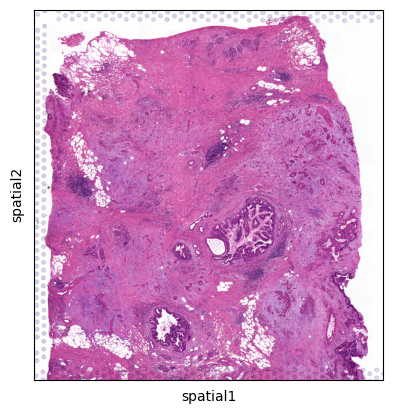

In [107]:
sc.pl.spatial(train_adata)

In [108]:
i = 401

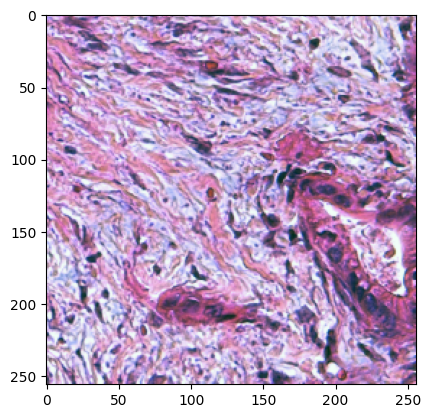

In [109]:
img = rearrange(train_ds[i]['he'], 'c h w -> h w c')
img -= img.min()
img /= img.max()
plt.imshow(img)

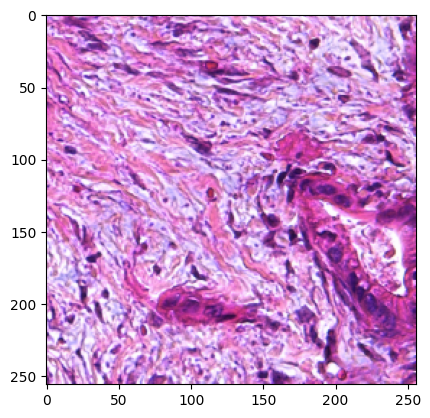

In [110]:
img = rearrange(train_ds[i]['he_orig'], 'c h w -> h w c')
plt.imshow(img)

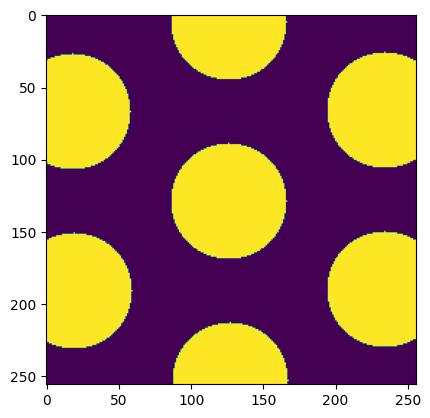

In [111]:
plt.imshow(torch.sum(train_ds[i]['masks'], dim=0))

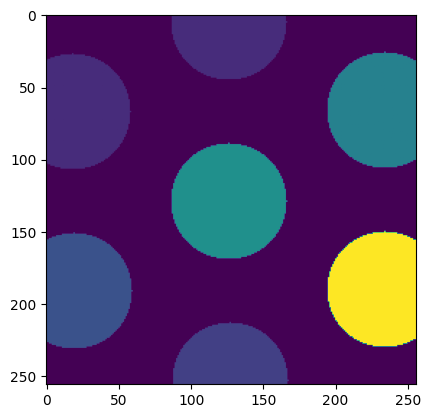

In [120]:
gene = 'EPCAM'
recon = construct_tile_expression(train_ds[i]['exp'], train_ds[i]['masks'], train_ds[i]['n_voxels'])
plt.imshow(recon[:, :, train_adata.var.index.to_list().index(gene)])

In [16]:
train_ds[i]['exp']

tensor([[1., 1., 1.,  ..., 3., 0., 0.],
        [4., 0., 2.,  ..., 1., 0., 0.],
        [2., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [64]:
train_adata.obs['spot_index']

AAACAACGAATAGTTC-1       1
AAACAAGTATCTCCCA-1       2
AAACAATCTACTAGCA-1       3
AAACACCAATAACTGC-1       4
AAACAGAGCGACTCCT-1       5
                      ... 
TTGTTGTGTGTCAAGA-1    3936
TTGTTTCACATCCAGG-1    3937
TTGTTTCATTAGTCTA-1    3938
TTGTTTCCATACAACT-1    3939
TTGTTTGTGTAAATTC-1    3940
Name: spot_index, Length: 3940, dtype: int64

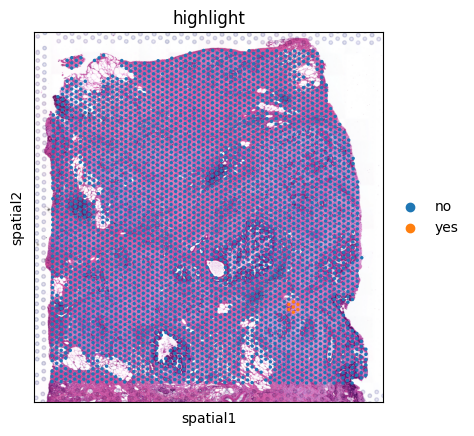

In [65]:
pool = set(train_ds[i]['voxel_idxs'][:train_ds[i]['n_voxels']].detach().numpy())
train_adata.obs['highlight'] = ['yes' if i in pool else 'no'
                               for i in train_adata.obs['spot_index']]
sc.pl.spatial(train_adata, color='highlight')

In [121]:
i = 99

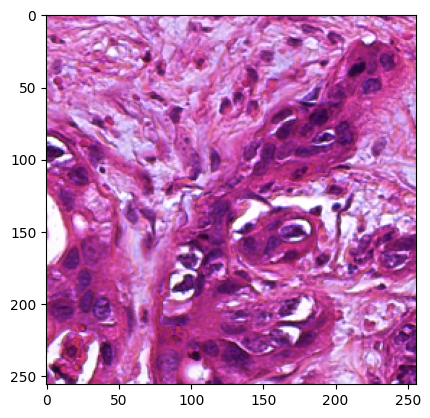

In [122]:
img = rearrange(val_ds[i]['he_orig'], 'c h w -> h w c')
plt.imshow(img)

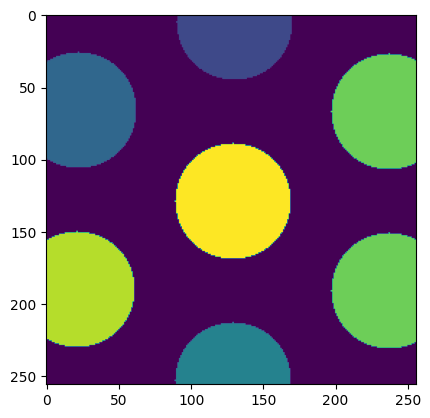

In [123]:
gene = 'EPCAM'
recon = construct_tile_expression(val_ds[i]['exp'], val_ds[i]['masks'], val_ds[i]['n_voxels'])
plt.imshow(recon[:, :, val_adata.var.index.to_list().index(gene)])

#### model

In [124]:
"""
modified from https://gist.github.com/rwightman/f8b24f4e6f5504aba03e999e02460d31
"""
class Unet(nn.Module):
    """Unet is a fully convolution neural network for image semantic segmentation
    Args:
        encoder_name: name of classification model (without last dense layers) used as feature
            extractor to build segmentation model.
        encoder_weights: one of ``None`` (random initialization), ``imagenet`` (pre-training on ImageNet).
        decoder_channels: list of numbers of ``Conv2D`` layer filters in decoder blocks
        decoder_use_batchnorm: if ``True``, ``BatchNormalisation`` layer between ``Conv2D`` and ``Activation`` layers
            is used.
        num_classes: a number of classes for output (output shape - ``(batch, classes, h, w)``).
        center: if ``True`` add ``Conv2dReLU`` block on encoder head
    NOTE: This is based off an old version of Unet in https://github.com/qubvel/segmentation_models.pytorch
    """

    def __init__(
            self,
            backbone='resnet34',
            backbone_kwargs=None,
            backbone_indices=None,
            decoder_use_batchnorm=True,
            decoder_channels=(256, 128, 64, 32, 16),
            in_chans=1,
            num_classes=5,
            center=False,
            norm_layer=nn.BatchNorm2d,
    ):
        super().__init__()
        backbone_kwargs = backbone_kwargs or {}
        # NOTE some models need different backbone indices specified based on the alignment of features
        # and some models won't have a full enough range of feature strides to work properly.
        encoder = create_model(
            backbone, features_only=True, out_indices=backbone_indices, in_chans=in_chans,
            pretrained=False, **backbone_kwargs)
        encoder_channels = encoder.feature_info.channels()[::-1]
        self.encoder = encoder

        if not decoder_use_batchnorm:
            norm_layer = None
        self.decoder = UnetDecoder(
            encoder_channels=encoder_channels,
            decoder_channels=decoder_channels,
            final_channels=num_classes,
            norm_layer=norm_layer,
            center=center,
        )

    def forward(self, x: torch.Tensor):
        x = self.encoder(x)
        x.reverse()  # torchscript doesn't work with [::-1]
        x = self.decoder(x)
        return x


class Conv2dBnAct(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding=0,
                 stride=1, act_layer=nn.ReLU, norm_layer=nn.BatchNorm2d):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, bias=False)
        self.bn = norm_layer(out_channels)
        self.act = act_layer(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        return x


class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, scale_factor=2.0, act_layer=nn.ReLU, norm_layer=nn.BatchNorm2d):
        super().__init__()
        conv_args = dict(kernel_size=3, padding=1, act_layer=act_layer)
        self.scale_factor = scale_factor
        if norm_layer is None:
            self.conv1 = Conv2dBnAct(in_channels, out_channels, **conv_args)
            self.conv2 = Conv2dBnAct(out_channels, out_channels,  **conv_args)
        else:
            self.conv1 = Conv2dBnAct(in_channels, out_channels, norm_layer=norm_layer, **conv_args)
            self.conv2 = Conv2dBnAct(out_channels, out_channels, norm_layer=norm_layer, **conv_args)

    def forward(self, x, skip: Optional[torch.Tensor] = None):
        if self.scale_factor != 1.0:
            x = F.interpolate(x, scale_factor=self.scale_factor, mode='nearest')
        if skip is not None:
            x = torch.cat([x, skip], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x


class UnetDecoder(nn.Module):

    def __init__(
            self,
            encoder_channels,
            decoder_channels=(256, 128, 64, 32, 16),
            final_channels=1,
            norm_layer=nn.BatchNorm2d,
            center=False,
    ):
        super().__init__()

        if center:
            channels = encoder_channels[0]
            self.center = DecoderBlock(channels, channels, scale_factor=1.0, norm_layer=norm_layer)
        else:
            self.center = nn.Identity()

        in_channels = [in_chs + skip_chs for in_chs, skip_chs in zip(
            [encoder_channels[0]] + list(decoder_channels[:-1]),
            list(encoder_channels[1:]) + [0])]
        out_channels = decoder_channels

        self.blocks = nn.ModuleList()
        for in_chs, out_chs in zip(in_channels, out_channels):
            self.blocks.append(DecoderBlock(in_chs, out_chs, norm_layer=norm_layer))
        self.final_conv = nn.Conv2d(out_channels[-1], final_channels, kernel_size=(1, 1))

        self._init_weight()

    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def forward(self, x: List[torch.Tensor]):
        encoder_head = x[0]
        skips = x[1:]
        x = self.center(encoder_head)
        for i, b in enumerate(self.blocks):
            skip = skips[i] if i < len(skips) else None
            x = b(x, skip)
        x = self.final_conv(x)
        return x

In [125]:
class xFuse(nn.Module):
    def __init__(self, genes, n_covariates, encoder_input_shape=(3, 256, 256),
                 n_metagenes=20, latent_dim=64, in_channels=3, decoder_channels=(128, 64, 32, 16, 8),
                 kl_scaler = .0001, latent_scaler=1., L_scaler=1., E_scaler=1., F_scaler=1.,
                 he_scaler = .001):
        super().__init__()
        self.genes = genes
        self.n_genes = len(genes)
        self.n_covariates = n_covariates
        self.n_metagenes = n_metagenes
        self.latent_dim = latent_dim
        
        self.unet = Unet(backbone='resnet34',
                         decoder_channels=decoder_channels,
                         in_chans=in_channels,
                         num_classes=latent_dim)
        
        # scalers for KL loss on q for latent, L, E, and F
        self.latent_scaler = latent_scaler
        self.L_scaler = L_scaler
        self.E_scaler = E_scaler
        self.F_scaler = F_scaler
        self.kl_scaler = kl_scaler
        
        # scaler for he loss
        self.he_scaler = he_scaler
        
        # gene-wise baselines for r and p
        self.t = nn.Parameter(torch.rand(self.n_genes))
        self.u = nn.Parameter(torch.rand(self.n_genes))
        
        # latent mu and var
        self.latent_mu = nn.Conv2d(in_channels=self.latent_dim, out_channels=self.latent_dim, kernel_size=1)
        self.latent_var = nn.Conv2d(in_channels=self.latent_dim, out_channels=self.latent_dim, kernel_size=1)
        
        # creates initial metagene matrix - (b, m, H, W)
        self.h = nn.Sequential(
            nn.Conv2d(in_channels=latent_dim, out_channels=self.n_metagenes, kernel_size=1),
            nn.Softmax(dim=1)
        )
        
        # creates scale factor for each pixel - (1, H, W)
        self.s = nn.Sequential(
            nn.Conv2d(in_channels=latent_dim, out_channels=1, kernel_size=1),
            nn.Softplus()
        )
        
        # gene activity matrix - (m, g)
        self.L = nn.Parameter(torch.rand(self.n_metagenes, self.n_genes))
        self.L_mu = nn.Linear(in_features=self.n_genes, out_features=self.n_genes)
        self.L_var = nn.Linear(in_features=self.n_genes, out_features=self.n_genes)
        
        # E - (D, g) - covariate matrix for r
        self.E = nn.Parameter(torch.rand(self.n_covariates, self.n_genes))
        self.E_mu = nn.Linear(in_features=self.n_genes, out_features=self.n_genes)
        self.E_var = nn.Linear(in_features=self.n_genes, out_features=self.n_genes)
        
        # F - (D, g) - covariate matrix for p
        self.F = nn.Parameter(torch.rand(self.n_covariates, self.n_genes))
        self.F_mu = nn.Linear(in_features=self.n_genes, out_features=self.n_genes)
        self.F_var = nn.Linear(in_features=self.n_genes, out_features=self.n_genes)
        
        # reconstructs he image
        self.he_mu = nn.Sequential(
            nn.Conv2d(in_channels=latent_dim, out_channels=3, kernel_size=1),
            nn.Tanh()
        )
        self.he_var = nn.Sequential(
            nn.Conv2d(in_channels=latent_dim, out_channels=3, kernel_size=1),
            nn.Softplus()
        )
        
        self.reconstruction_loss = nn.MSELoss()
        
    def _sample_q(self, mu, log_var, use_means=False):
        # sample z from parameterized distributions
        std = torch.exp(log_var / 2)
        q = torch.distributions.Normal(mu, std)
        # get our latent
        if use_means:
            z = mu
        else:
            z = q.rsample()

        return z, mu, std
    
    def _kl_divergence(self, z, mu, std):
        # lightning imp.
        # Monte carlo KL divergence
        p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
        q = torch.distributions.Normal(mu, std)

        log_qzx = q.log_prob(z)
        log_pz = p.log_prob(z)

        kl = (log_qzx - log_pz)
        kl = kl.sum(-1)

        return kl
    
    def calculate_loss(self, x_raw, he, result):
        nb = torch.distributions.NegativeBinomial(result['r'], result['p'])
        reconstruction_loss = torch.mean(-nb.log_prob(x_raw))
        
        norm = torch.distributions.Normal(result['he_mu'], result['he_std'])
        image_loss = torch.mean(-norm.log_prob(he))
        
        latent_loss = torch.mean(self._kl_divergence(result['z'], result['z_mu'], result['z_std']))
        L_loss = torch.mean(self._kl_divergence(result['L'], result['L_mu'], result['L_std']))
        E_loss = torch.mean(self._kl_divergence(result['E'], result['E_mu'], result['E_std']))
        F_loss = torch.mean(self._kl_divergence(result['F'], result['F_mu'], result['F_std']))

        kl_loss = latent_loss * self.latent_scaler +  L_loss * self.L_scaler + E_loss * self.E_scaler + F_loss * self.F_scaler
                
        return {
            'overall_loss': reconstruction_loss + self.kl_scaler * kl_loss + image_loss * self.he_scaler,
            'reconstruction_loss': reconstruction_loss,
            'kl_loss': kl_loss,
            'latent_loss': latent_loss,
            'L_loss': L_loss,
            'E_loss': E_loss,
            'F_loss': F_loss,
            'image_loss': image_loss
        }
        
    def encode(self, x, use_means=False):
        x_encoded = self.unet(x)
        mu, log_var = self.latent_mu(x_encoded), self.latent_var(x_encoded)
        return self._sample_q(mu, log_var, use_means=use_means)
        
    def sample_L(self, use_means=False):
        mu, log_var = self.L_mu(self.L), self.L_var(self.L)

        return self._sample_q(mu, log_var, use_means=use_means)
    
    def sample_E(self, use_means=False):
        mu, log_var = self.E_mu(self.E), self.E_var(self.E)

        return self._sample_q(mu, log_var, use_means=use_means)
    
    def sample_F(self, use_means=False):
        mu, log_var = self.F_mu(self.F), self.F_var(self.F)

        return self._sample_q(mu, log_var, use_means=use_means)
    
    def sample_he(self, z, use_means=False):
        mu, log_var = self.he_mu(z), self.he_var(z)

        return self._sample_q(mu, log_var, use_means=use_means)
        
    def metagenes_from_latent(self, z):
        h = self.h(z) # (b, m, H, W)
        s = self.s(z) # (b, 1, H, W)
        return rearrange(h * s, 'b c h w -> b h w c')
    
    def parameterize_nb(self, z, b, masks,
                        voxel_level=True, use_means=False, return_intermediates=False):
        """
        reconstruct expression from latent z and covariate vector b
        
        z - (b, H, W, latent_dim)
        b - (b, D)
        """
        h = self.metagenes_from_latent(z) # (b, H, W, m)
        
        if voxel_level:
            h = reduce_to_voxel_level(h, masks) # (b, v, m)
        else:
            h = rearrange(h, 'b h w m -> b (h w) m')
        
        # calculate r for each gene
        L_matrix, L_mu, L_std = self.sample_L(use_means=use_means) # (m, g)

        r = h@L_matrix # (b, v, g)
        # adjust for covariates
        E_matrix, E_mu, E_std = self.sample_E(use_means=use_means) # (D, g)
        adj = torch.exp(b@E_matrix + self.t) # (b, g)
        adj = adj.unsqueeze(dim=1) # (b, 1, g)
        r *= adj # (b, v, g)
        
        r = F.softplus(r)
        r += .00000001
        
        # calculate p
        F_matrix, F_mu, F_std = self.sample_F(use_means=use_means)
        p = torch.sigmoid(b@F_matrix + self.u) # (b, g)
        p = p.unsqueeze(dim=1)
        
        if return_intermediates:
            return {
                'L': L_matrix,
                'L_mu': L_mu,
                'L_std': L_std,
                'E': E_matrix,
                'E_mu': E_mu,
                'E_std': E_std,
                'F': F_matrix,
                'F_mu': F_mu,
                'F_std': F_std,
                'metagene_matrix': h,
                'r': r,
                'p': p
            }
        
        return r, p
    
    def forward_with_expression(self, x, b, masks,
                                use_means=False, voxel_level=True):
        result = self.forward(x, b, masks, voxel_level=voxel_level,
                              use_means=use_means, return_intermediates=True)
        r, p = result['r'], result['p']
        
        # get expression from negative binomial
        nb = torch.distributions.NegativeBinomial(r, p)
        result['expression'] = nb.mean

        return result
    
    def forward(self, x, b, masks,
                voxel_level=True, use_means=False, return_intermediates=True):
        z, z_mu, z_std = self.encode(x, use_means=use_means)
        result = self.parameterize_nb(z, b, masks, voxel_level=voxel_level,
                                      use_means=use_means, return_intermediates=return_intermediates)
        
        he_recon, he_mu, he_std = self.sample_he(z, use_means=use_means) # (3, H, W)
        
        result.update({
            'z': z,
            'z_mu': z_mu,
            'z_std': z_std,
            'he_recon': he_recon,
            'he_mu': he_mu,
            'he_std': he_std,
        })
        
        return result
    

In [126]:
def reduce_to_voxel_level(x, masks):
    """
    x - (b, h, w, m)
    masks - (b, v, h, w)
    
    out - (b, v, m)
    """
    masks = masks.unsqueeze(dim=-1) # (b, v, h, w, 1)
    x = x.unsqueeze(dim=1).repeat(1, 16, 1, 1, 1) # (b, v, h, w, m)
    x *= masks 
    return x.sum(dim=(-3, -2)) # (b, v, m)

def mask_nb_params(r, p, voxel_idxs):
    mask = torch.zeros_like(voxel_idxs, dtype=torch.bool)
    if r.is_cuda:
        mask = mask.cuda()
        
    mask[voxel_idxs == 0] = 1

    mask = mask.unsqueeze(dim=-1)
    masked_p = p.masked_fill(mask, 0.)
    masked_r = r.masked_fill(mask, 0.)
    
    return masked_r, masked_p

In [127]:
def construct_tile_expression(padded_exp, masks, n_voxels, normalize=True):
    tile = torch.zeros((masks.shape[0], masks.shape[-2], masks.shape[-1], padded_exp.shape[-1]),
                       device=padded_exp.device)
    for b in range(tile.shape[0]):
        for exp, m in zip(padded_exp[b], masks[b]):
            tile[b, :, :][m==1] = exp
            
    tile = rearrange(tile, 'b h w c -> b c h w')
    tile = tile.detach().cpu().numpy()
    
    tile /= np.expand_dims(tile.max(axis=(0, -2, -1)), (0, -2, -1))

    return rearrange(tile, 'b c h w -> b h w c')

def log_intermediates(logger, batch, result, plot_genes, model_genes, idxs=(0)):

    img = batch['he_tiles_orig']['2X']
    logger.log_image(
        key="he",
        images=[img],
        caption=['he tile 2x']
    )
    
    
    img = result['he_recon'] # (b c h w)
#     img = TF.convert_image_dtype(img, dtype=torch.uint8)
    img -= img.min()
    img /= img.max()
    logger.log_image(
        key="he_recon",
        images=[img],
        caption=['he tile recon']
    )

    orig_recon = construct_tile_expression(batch['X'], batch['masks'], batch['n_voxels'])
    recon = orig_recon[:, :, :, [True if g in plot_genes else False for g in model_genes]]
    recon = torch.tensor(rearrange(recon, 'b h w c -> c b 1 h w'))
    logger.log_image(
        key=f"groundtruth",
        images=[img for img in recon],
        caption=[g for g in plot_genes]
    )

    model_recon = construct_tile_expression(result['expression'], batch['masks'], batch['n_voxels'])
    recon = model_recon[:, :, :, [True if g in plot_genes else False for g in model_genes]]
    recon = torch.tensor(rearrange(recon, 'b h w c -> c b 1 h w'))
    logger.log_image(
        key=f"reconstruction",
        images=[img for img in recon],
        caption=[g for g in plot_genes]
    )

In [128]:
class xFuseLightning(pl.LightningModule):
    def __init__(self, xfuse, lr=1e-3, plot_idxs=(0), plot_genes=['IL7R', 'MS4A1', 'BGN']):
        super().__init__()
        
        self.xfuse = xfuse
        self.lr = lr
        self.plot_genes = plot_genes
        self.plot_idxs = np.asarray(plot_idxs)
        
        self.save_hyperparameters(ignore=['xfuse'])

    def training_step(self, batch, batch_idx):
        x, b, masks, voxel_idxs, exp = batch['he'], batch['b'], batch['masks'], batch['voxel_idxs'], batch['exp']
        result = self.xfuse(x, b, masks)
        result['r'], result['p'] = mask_nb_params(result['r'], result['p'], voxel_idxs)
        losses = self.xfuse.calculate_loss(exp, x, result)
        losses = {f'train/{k}':v for k, v in losses.items()}
        self.log_dict(losses, on_step=False, on_epoch=True, prog_bar=True)
        losses['loss'] = losses['train/overall_loss']
        
        return losses
    
    def validation_step(self, batch, batch_idx):
        x, b, masks, voxel_idxs, exp = batch['he'], batch['b'], batch['masks'], batch['voxel_idxs'], batch['exp']
        result = self.xfuse.forward_with_expression(x, b, masks)
        result['r'], result['p'] = mask_nb_params(result['r'], result['p'], voxel_idxs)
        losses = self.xfuse.calculate_loss(exp, x, result)
        losses = {f'val/{k}':v for k, v in losses.items()}
        self.log_dict(losses, on_step=False, on_epoch=True, prog_bar=True)
        
        # plot intermediates if index is in batch
        idxs = [i for i in batch['voxel_idx'].detach().cpu().numpy() if i in self.plot_idxs]
        if len(idxs):
            log_intermediates(self.logger, batch, result, self.plot_genes, self.xfuse.genes, idxs=idxs)
        
        return losses

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

###### fit model

In [75]:
project = 'xFuse'
log_dir = '../logs'

In [76]:
from pytorch_lightning.loggers import WandbLogger
logger = WandbLogger(project=project, save_dir=log_dir)

In [24]:
# wandb.finish()

In [129]:
config = {
    'n_genes': train_adata.shape[1],
    'genes': train_adata.var.index.to_list(),
    'n_covariates': 1,
    'n_metagenes': 20,
    'latent_dim': 64,
    'encoder': {
        'model': 'unet',
        'channels': [128, 64, 32, 16, 8]
    },
    'kl_scalers': {
        'overall_scaler': .0001,
        'latent_scaler': 1.,
        'L_scaler': 1.,
        'E_scaler': 1.,
        'F_scaler': 1.,
        'he_scaler': .1,
    },
    'training': {
        'train_samples': ['HT270P1-S1H1U1'],
        'val_samples': ['HT264P1-S1H2U1'],
        'plot_voxel_idxs': [99],
        'max_epochs': 1000,
        'check_val_every_n_epoch': 10,
        'log_every_n_steps': 1,
        'accelerator': 'gpu',
        'devices': 1,
        'limit_train_batches': 100,
        'limit_val_batches': 1.,
        'lr': 1e-4,
        'batch_size': batch_size,
        'precision': 32
    },
}

NameError: name 'batch_size' is not defined

In [26]:
logger.experiment.config.update(config)

In [27]:
xfuse = xFuse(
    config['genes'], config['n_covariates'],
    n_metagenes=config['n_metagenes'], latent_dim=config['latent_dim'], in_channels=3,
    decoder_channels=config['encoder']['channels'],
    kl_scaler = config['kl_scalers']['overall_scaler'], latent_scaler=config['kl_scalers']['latent_scaler'],
    L_scaler=config['kl_scalers']['L_scaler'], E_scaler=config['kl_scalers']['E_scaler'],
    F_scaler=config['kl_scalers']['F_scaler'], he_scaler=config['kl_scalers']['he_scaler']
)
model = xFuseLightning(xfuse, lr=config['training']['lr'], plot_idxs=config['training']['plot_voxel_idxs'])

In [28]:
trainer = pl.Trainer(
    devices=config['training']['devices'],
    accelerator=config['training']['accelerator'],
    check_val_every_n_epoch=config['training']['check_val_every_n_epoch'],
    enable_checkpointing=False,
    limit_val_batches=config['training']['limit_val_batches'],
    limit_train_batches=config['training']['limit_train_batches'],
    log_every_n_steps=config['training']['log_every_n_steps'],
    max_epochs=config['training']['max_epochs'],
    precision=config['training']['precision'],
    logger=logger
)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..


In [31]:
x = torch.rand(64, 16, 256, 256)
x = torch.sum(x, dim=(-2, -1), keepdim=True)
x.shape

torch.Size([64, 16, 1, 1])

In [29]:
trainer.fit(model=model, train_dataloaders=train_dl, val_dataloaders=val_dl)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]

  | Name  | Type  | Params
--------------------------------
0 | xfuse | xFuse | 22.6 M
--------------------------------
22.6 M    Trainable params
0         Non-trainable params
22.6 M    Total params
90.308    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/miniconda/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:225: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 80 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/miniconda/lib/python3.9/site-packages/pytorch_lightning/core/module.py:555: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=self.device)
/miniconda/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:225: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 80 which is th

Training: 0it [00:00, ?it/s]

ValueError: Expected parameter loc (Tensor of shape (16, 64, 256, 256)) of distribution Normal(loc: torch.Size([16, 64, 256, 256]), scale: torch.Size([16, 64, 256, 256])) to satisfy the constraint Real(), but found invalid values:
tensor([[[[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         ...,

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]]],


        [[[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         ...,

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]]],


        [[[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         ...,

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]]],


        ...,


        [[[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         ...,

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]]],


        [[[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         ...,

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]]],


        [[[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         ...,

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]]]], device='cuda:0',
       grad_fn=<ConvolutionBackward0>)

###### expression validation check

In [69]:
batch = next(iter(train_dl))
x, b, masks, voxel_idxs, exp = batch['he_tiles']['2X'], batch['b'], batch['masks'], batch['voxel_idxs'], batch['X']

In [71]:
result = xfuse(x, b, masks)

In [72]:
result.keys()

dict_keys(['L', 'L_mu', 'L_std', 'E', 'E_mu', 'E_std', 'F', 'F_mu', 'F_std', 'metagene_matrix', 'r', 'p', 'z', 'z_mu', 'z_std'])

In [74]:
result['r'].shape

torch.Size([32, 16, 4])

In [201]:
idx = 725 - 1
# 70,  725,  901, 1547, 2692, 2704, 3165
d = val_ds[idx]
x, b, masks, voxel_idxs, exp = d['he_tiles']['2X'], d['b'], d['masks'], d['voxel_idxs'], d['X']

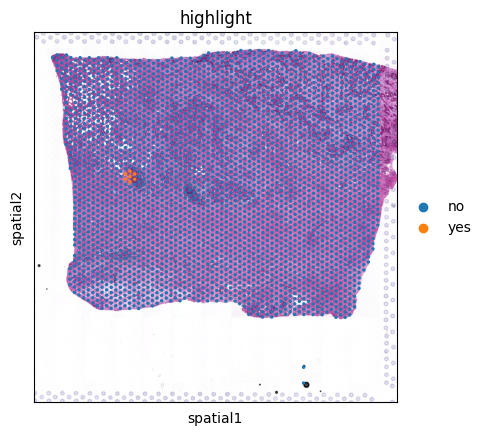

In [202]:
val_adata.obs['highlight'] = ['yes' if i in d['voxel_idxs'][:d['n_voxels']] else 'no'
                               for i in val_adata.obs['spot_index']]
sc.pl.spatial(val_adata, color='highlight')

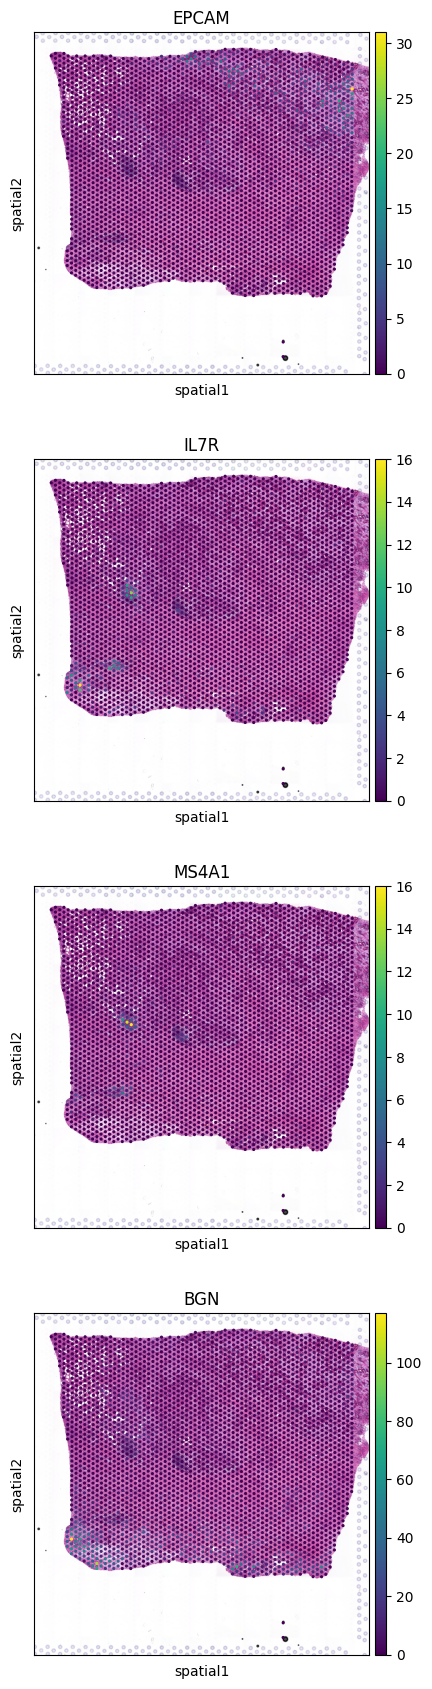

In [173]:
sc.pl.spatial(val_adata, color=genes, ncols=1)

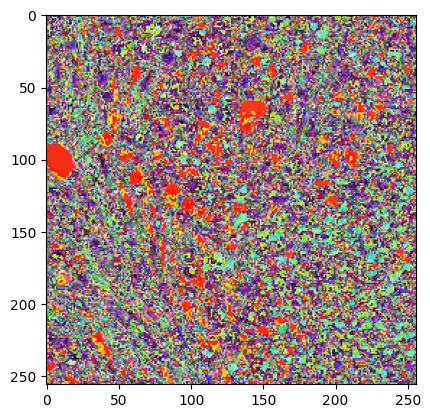

In [203]:
tile = rearrange(TF.convert_image_dtype(d['he_tiles']['2X'], torch.uint8), 'c h w -> h w c')
plt.imshow(tile)

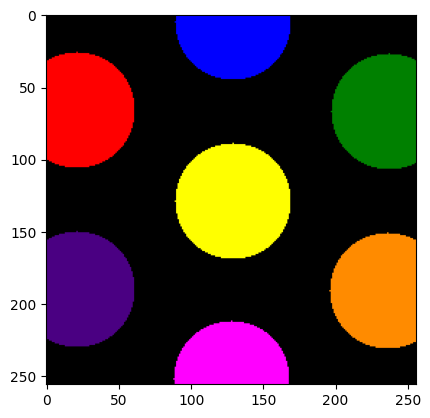

In [204]:
tile = label2rgb(d['mask_tiles']['2X'].numpy())
plt.imshow(tile)

In [205]:
d['X'], genes

(tensor([[ 0.0000,  0.0000,  1.6496,  0.0000],
         [ 0.0000,  1.1734,  1.7601,  0.5867],
         [ 0.0000,  2.0004,  8.0016,  5.0010],
         [ 0.0000,  0.5554,  1.6663,  1.1109],
         [ 0.0000,  5.4838,  1.5668,  3.1336],
         [ 0.0000,  0.0000,  0.0000,  4.1240],
         [ 0.0000,  6.3803, 11.9630,  2.3926],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000]]),
 ['EPCAM', 'IL7R', 'MS4A1', 'BGN'])

In [206]:
d['masks'].shape

torch.Size([16, 256, 256])

In [207]:
d['voxel_idxs']

array([ 275,  418,  725,  901, 1243, 1547, 3165,    0,    0,    0,    0,
          0,    0,    0,    0,    0])

In [271]:
def construct_tile_expression(padded_exp, masks, n_voxels):
    tile = torch.zeros((masks.shape[1], masks.shape[2], padded_exp.shape[1]))
    for exp, m in list(zip(padded_exp, masks))[:n_voxels]:
        tile[m==1] = exp
    return tile

In [209]:
recon = construct_tile_expression(d['X'], d['masks'], d['n_voxels'])
recon.shape

(256, 256, 4)

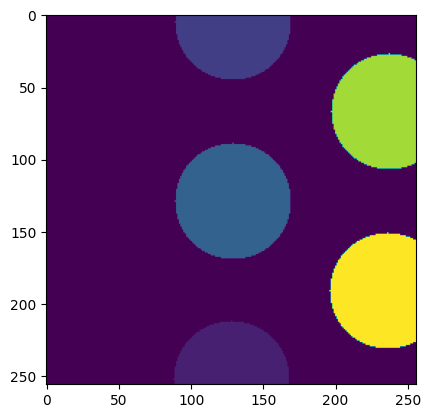

In [211]:
plt.imshow(recon[:, :, 1])

In [260]:
d = test_ds[0]

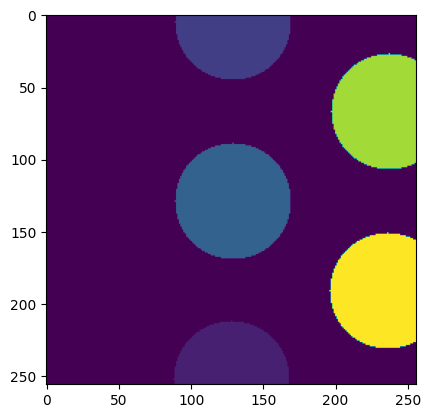

In [238]:
recon = construct_tile_expression(d['X'], d['masks'], d['n_voxels'])
plt.imshow(recon[:, :, 1])

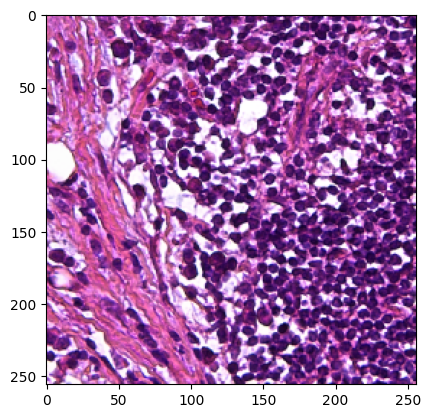

In [261]:
tile = rearrange(TF.convert_image_dtype(d['he_tiles_orig']['2X'], torch.uint8), 'c h w -> h w c')
plt.imshow(tile)

In [266]:
batch['he_tiles']['2X'].shape

torch.Size([1, 3, 256, 256])

In [268]:
batch = next(iter(test_dl))
result = xfuse.forward_with_expression(batch['he_tiles']['2X'], batch['b'], batch['masks'], use_means=True)
result.keys()

dict_keys(['L', 'L_mu', 'L_std', 'E', 'E_mu', 'E_std', 'F', 'F_mu', 'F_std', 'metagene_matrix', 'r', 'p', 'z', 'z_mu', 'z_std', 'expression'])

In [273]:
result['expression'].shape

torch.Size([1, 16, 4])

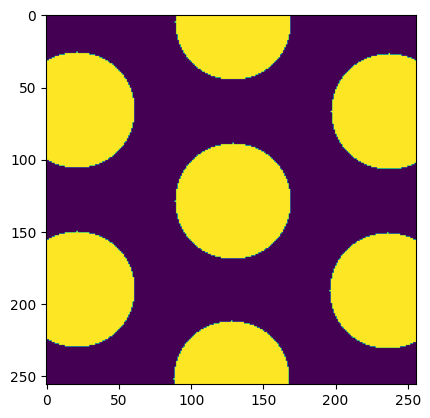

In [275]:
recon = construct_tile_expression(result['expression'][0], batch['masks'][0], batch['n_voxels'][0])
plt.imshow(recon[:, :, 1].detach().numpy())

#### training loop

In [20]:
n_genes = train_ds.adata.shape[1]
n_covariates = 1

In [21]:
model = xFuse(
    n_genes, n_covariates,
    n_metagenes=20, latent_dim=64, in_channels=3, decoder_channels=(128, 64, 32, 16, 8),
    kl_scaler = .01, latent_scaler=1., L_scaler=1., E_scaler=1., F_scaler=1.)

In [22]:
model = model.cuda()

In [23]:
n_steps = 10000
val_interval = 10000
lr = .0001

opt = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    opt, max_lr=lr, total_steps=n_steps)

In [24]:
train_history = []
val_history = []
use_cuda = next(model.parameters()).is_cuda
model.train()
for step in range(n_steps):
    print('train')
    logging.info(f'step {step}')
    batch = next(iter(train_dl))
    x, b, masks, voxel_idxs, exp = batch['he_tiles']['2X'], batch['b'], batch['masks'], batch['voxel_idxs'], batch['X']
    if use_cuda:
        x, b, masks, voxel_idxs, exp = x.cuda(), b.cuda(), masks.cuda(), voxel_idxs.cuda(), exp.cuda()
    opt.zero_grad()
    result = model(x, b, masks)
    result['r'], result['p'] = mask_nb_params(result['r'], result['p'], voxel_idxs)
    losses = model.calculate_loss(exp, result)
    
    losses['overall_loss'].backward()
    opt.step()
    train_losses = {k:v.detach().cpu() for k, v in losses.items()}
    print(step, train_losses)
    train_history.append(train_losses)
#     scheduler.step()
    
    if step % val_interval == 0 and step != 0:
        model.eval()
        batch_val_losses = []
        print('validation')
        with torch.no_grad():
            for i, batch in enumerate(val_dl):
                x, b, masks, voxel_idxs, exp = batch['he_tiles']['2X'], batch['b'], batch['masks'], batch['voxel_idxs'], batch['X']
                if use_cuda:
                    x, b, masks, voxel_idxs, exp = x.cuda(), b.cuda(), masks.cuda(), voxel_idxs.cuda(), exp.cuda()
                result = model(x, b, masks)
                result['r'], result['p'] = mask_nb_params(result['r'], result['p'], voxel_idxs)
                losses = model.calculate_loss(exp, result)
                val_losses = {k:v.detach().cpu() for k, v in losses.items()}
                batch_val_losses.append(val_losses)
        val_losses = {
            k:np.mean([d[k] for d in batch_val_losses])
            for k in batch_val_losses[0].keys()
        }
        print(val_losses)
        val_history.append(val_losses)
        
        ot, ov = train_losses['overall_loss'], val_losses['overall_loss']
        rt, rv = train_losses['reconstruction_loss'], val_losses['reconstruction_loss']
        kt, kv = train_losses['kl_loss'], val_losses['kl_loss']
        print(f'step: {step}, train loss: {ot:.3f}, val loss: {ov:.3f}, \
train recon loss: {rt:.3f}, val recon loss: {rv:.3f}, \
train kl loss: {kt:.3f}, val kl loss: {kv:.3f}')
        
        model.train()
    

train
0 {'overall_loss': tensor(349.0402), 'reconstruction_loss': tensor(346.6165), 'kl_loss': tensor(242.3727), 'latent_loss': tensor(241.1023), 'L_loss': tensor(0.7840), 'E_loss': tensor(-0.0270), 'F_loss': tensor(0.5134)}
train
1 {'overall_loss': tensor(43.0404), 'reconstruction_loss': tensor(40.7769), 'kl_loss': tensor(226.3472), 'latent_loss': tensor(224.8978), 'L_loss': tensor(1.1314), 'E_loss': tensor(-0.0658), 'F_loss': tensor(0.3839)}
train
2 {'overall_loss': tensor(369.3163), 'reconstruction_loss': tensor(367.1995), 'kl_loss': tensor(211.6833), 'latent_loss': tensor(210.3194), 'L_loss': tensor(1.0892), 'E_loss': tensor(1.1683), 'F_loss': tensor(-0.8936)}
train
3 {'overall_loss': tensor(534.2597), 'reconstruction_loss': tensor(532.2582), 'kl_loss': tensor(200.1445), 'latent_loss': tensor(198.2685), 'L_loss': tensor(0.7508), 'E_loss': tensor(0.5296), 'F_loss': tensor(0.5956)}
train
4 {'overall_loss': tensor(264.1695), 'reconstruction_loss': tensor(262.1858), 'kl_loss': tensor(1

37 {'overall_loss': tensor(143.1817), 'reconstruction_loss': tensor(141.7459), 'kl_loss': tensor(143.5740), 'latent_loss': tensor(142.1260), 'L_loss': tensor(0.3568), 'E_loss': tensor(0.3257), 'F_loss': tensor(0.7655)}
train
38 {'overall_loss': tensor(765.1899), 'reconstruction_loss': tensor(763.7629), 'kl_loss': tensor(142.6917), 'latent_loss': tensor(142.0966), 'L_loss': tensor(0.3864), 'E_loss': tensor(-0.1483), 'F_loss': tensor(0.3569)}
train
39 {'overall_loss': tensor(1267.4407), 'reconstruction_loss': tensor(1266.0271), 'kl_loss': tensor(141.3617), 'latent_loss': tensor(141.0963), 'L_loss': tensor(0.7228), 'E_loss': tensor(-0.3944), 'F_loss': tensor(-0.0631)}
train
40 {'overall_loss': tensor(491.3548), 'reconstruction_loss': tensor(489.9171), 'kl_loss': tensor(143.7726), 'latent_loss': tensor(141.3420), 'L_loss': tensor(1.7857), 'E_loss': tensor(0.8901), 'F_loss': tensor(-0.2452)}
train
41 {'overall_loss': tensor(167.6010), 'reconstruction_loss': tensor(166.1872), 'kl_loss': tens

74 {'overall_loss': tensor(58.4564), 'reconstruction_loss': tensor(57.1605), 'kl_loss': tensor(129.5895), 'latent_loss': tensor(127.6300), 'L_loss': tensor(1.3790), 'E_loss': tensor(0.0284), 'F_loss': tensor(0.5522)}
train
75 {'overall_loss': tensor(459.5188), 'reconstruction_loss': tensor(458.2375), 'kl_loss': tensor(128.1265), 'latent_loss': tensor(127.1406), 'L_loss': tensor(0.5479), 'E_loss': tensor(0.9762), 'F_loss': tensor(-0.5381)}
train
76 {'overall_loss': tensor(516.3351), 'reconstruction_loss': tensor(515.0375), 'kl_loss': tensor(129.7670), 'latent_loss': tensor(127.2273), 'L_loss': tensor(1.2091), 'E_loss': tensor(0.5123), 'F_loss': tensor(0.8184)}
train
77 {'overall_loss': tensor(1099.6281), 'reconstruction_loss': tensor(1098.3492), 'kl_loss': tensor(127.8866), 'latent_loss': tensor(126.2159), 'L_loss': tensor(1.2397), 'E_loss': tensor(1.0315), 'F_loss': tensor(-0.6005)}
train
78 {'overall_loss': tensor(641.8281), 'reconstruction_loss': tensor(640.5099), 'kl_loss': tensor(1

111 {'overall_loss': tensor(401.7604), 'reconstruction_loss': tensor(400.5427), 'kl_loss': tensor(121.7736), 'latent_loss': tensor(119.3509), 'L_loss': tensor(1.1910), 'E_loss': tensor(0.5772), 'F_loss': tensor(0.6545)}
train
112 {'overall_loss': tensor(8.1276), 'reconstruction_loss': tensor(6.9141), 'kl_loss': tensor(121.3489), 'latent_loss': tensor(118.7384), 'L_loss': tensor(0.6744), 'E_loss': tensor(0.8933), 'F_loss': tensor(1.0428)}
train
113 {'overall_loss': tensor(142.3566), 'reconstruction_loss': tensor(141.1638), 'kl_loss': tensor(119.2761), 'latent_loss': tensor(118.6979), 'L_loss': tensor(0.6061), 'E_loss': tensor(-0.3529), 'F_loss': tensor(0.3249)}
train
114 {'overall_loss': tensor(45.6842), 'reconstruction_loss': tensor(44.4924), 'kl_loss': tensor(119.1731), 'latent_loss': tensor(119.4339), 'L_loss': tensor(0.8075), 'E_loss': tensor(0.3907), 'F_loss': tensor(-1.4591)}
train
115 {'overall_loss': tensor(104.7492), 'reconstruction_loss': tensor(103.5377), 'kl_loss': tensor(12

148 {'overall_loss': tensor(9.5521), 'reconstruction_loss': tensor(8.3997), 'kl_loss': tensor(115.2355), 'latent_loss': tensor(113.4906), 'L_loss': tensor(0.7844), 'E_loss': tensor(-0.5230), 'F_loss': tensor(1.4834)}
train
149 {'overall_loss': tensor(45.7568), 'reconstruction_loss': tensor(44.6006), 'kl_loss': tensor(115.6157), 'latent_loss': tensor(113.5535), 'L_loss': tensor(1.0662), 'E_loss': tensor(0.7276), 'F_loss': tensor(0.2683)}
train
150 {'overall_loss': tensor(301.8554), 'reconstruction_loss': tensor(300.7219), 'kl_loss': tensor(113.3512), 'latent_loss': tensor(113.2784), 'L_loss': tensor(0.6541), 'E_loss': tensor(-0.1679), 'F_loss': tensor(-0.4134)}
train
151 {'overall_loss': tensor(398.7816), 'reconstruction_loss': tensor(397.6317), 'kl_loss': tensor(114.9887), 'latent_loss': tensor(113.4538), 'L_loss': tensor(1.0619), 'E_loss': tensor(0.0850), 'F_loss': tensor(0.3881)}
train
152 {'overall_loss': tensor(292.1740), 'reconstruction_loss': tensor(291.0264), 'kl_loss': tensor(1

185 {'overall_loss': tensor(114.3359), 'reconstruction_loss': tensor(113.2398), 'kl_loss': tensor(109.6092), 'latent_loss': tensor(108.6784), 'L_loss': tensor(1.0037), 'E_loss': tensor(-0.8808), 'F_loss': tensor(0.8079)}
train
186 {'overall_loss': tensor(554.4609), 'reconstruction_loss': tensor(553.3698), 'kl_loss': tensor(109.1169), 'latent_loss': tensor(108.9767), 'L_loss': tensor(0.4178), 'E_loss': tensor(-0.6666), 'F_loss': tensor(0.3889)}
train
187 {'overall_loss': tensor(223.6386), 'reconstruction_loss': tensor(222.5308), 'kl_loss': tensor(110.7797), 'latent_loss': tensor(108.8211), 'L_loss': tensor(0.8306), 'E_loss': tensor(0.9601), 'F_loss': tensor(0.1679)}
train
188 {'overall_loss': tensor(685.2878), 'reconstruction_loss': tensor(684.1923), 'kl_loss': tensor(109.5608), 'latent_loss': tensor(108.9785), 'L_loss': tensor(0.7305), 'E_loss': tensor(0.4621), 'F_loss': tensor(-0.6103)}
train
189 {'overall_loss': tensor(116.8188), 'reconstruction_loss': tensor(115.7185), 'kl_loss': te

222 {'overall_loss': tensor(578.5181), 'reconstruction_loss': tensor(577.4568), 'kl_loss': tensor(106.1347), 'latent_loss': tensor(105.3864), 'L_loss': tensor(1.2263), 'E_loss': tensor(-0.3787), 'F_loss': tensor(-0.0993)}
train
223 {'overall_loss': tensor(1399.4849), 'reconstruction_loss': tensor(1398.4233), 'kl_loss': tensor(106.1468), 'latent_loss': tensor(105.4246), 'L_loss': tensor(1.2508), 'E_loss': tensor(-0.3721), 'F_loss': tensor(-0.1565)}
train
224 {'overall_loss': tensor(975.8518), 'reconstruction_loss': tensor(974.7723), 'kl_loss': tensor(107.9489), 'latent_loss': tensor(105.5521), 'L_loss': tensor(1.4538), 'E_loss': tensor(0.1457), 'F_loss': tensor(0.7972)}
train
225 {'overall_loss': tensor(152.8667), 'reconstruction_loss': tensor(151.8133), 'kl_loss': tensor(105.3366), 'latent_loss': tensor(105.1204), 'L_loss': tensor(0.7663), 'E_loss': tensor(-0.6225), 'F_loss': tensor(0.0724)}
train
226 {'overall_loss': tensor(263.1931), 'reconstruction_loss': tensor(262.1481), 'kl_loss'

259 {'overall_loss': tensor(227.9073), 'reconstruction_loss': tensor(226.8729), 'kl_loss': tensor(103.4450), 'latent_loss': tensor(101.5981), 'L_loss': tensor(0.4692), 'E_loss': tensor(1.2336), 'F_loss': tensor(0.1442)}
train
260 {'overall_loss': tensor(106.8085), 'reconstruction_loss': tensor(105.7785), 'kl_loss': tensor(102.9971), 'latent_loss': tensor(101.2691), 'L_loss': tensor(0.7362), 'E_loss': tensor(0.2542), 'F_loss': tensor(0.7376)}
train
261 {'overall_loss': tensor(81.6092), 'reconstruction_loss': tensor(80.5938), 'kl_loss': tensor(101.5401), 'latent_loss': tensor(101.0975), 'L_loss': tensor(0.8187), 'E_loss': tensor(-0.2952), 'F_loss': tensor(-0.0809)}
train
262 {'overall_loss': tensor(638.8899), 'reconstruction_loss': tensor(637.8830), 'kl_loss': tensor(100.6918), 'latent_loss': tensor(100.9335), 'L_loss': tensor(1.5369), 'E_loss': tensor(-0.8596), 'F_loss': tensor(-0.9190)}
train
263 {'overall_loss': tensor(60.6997), 'reconstruction_loss': tensor(59.6693), 'kl_loss': tenso

296 {'overall_loss': tensor(182.7894), 'reconstruction_loss': tensor(181.7982), 'kl_loss': tensor(99.1294), 'latent_loss': tensor(98.7968), 'L_loss': tensor(0.5744), 'E_loss': tensor(-0.0005), 'F_loss': tensor(-0.2414)}
train
297 {'overall_loss': tensor(17.4144), 'reconstruction_loss': tensor(16.4242), 'kl_loss': tensor(99.0212), 'latent_loss': tensor(98.7926), 'L_loss': tensor(0.5832), 'E_loss': tensor(-0.9426), 'F_loss': tensor(0.5880)}
train
298 {'overall_loss': tensor(282.4304), 'reconstruction_loss': tensor(281.4269), 'kl_loss': tensor(100.3445), 'latent_loss': tensor(98.4147), 'L_loss': tensor(0.9283), 'E_loss': tensor(0.8387), 'F_loss': tensor(0.1628)}
train
299 {'overall_loss': tensor(339.9980), 'reconstruction_loss': tensor(338.9961), 'kl_loss': tensor(100.1946), 'latent_loss': tensor(98.4984), 'L_loss': tensor(0.7843), 'E_loss': tensor(-0.4577), 'F_loss': tensor(1.3696)}
train
300 {'overall_loss': tensor(41.2063), 'reconstruction_loss': tensor(40.2012), 'kl_loss': tensor(100.

333 {'overall_loss': tensor(437.1247), 'reconstruction_loss': tensor(436.1361), 'kl_loss': tensor(98.8578), 'latent_loss': tensor(96.4981), 'L_loss': tensor(0.9728), 'E_loss': tensor(0.9845), 'F_loss': tensor(0.4023)}
train
334 {'overall_loss': tensor(143.7622), 'reconstruction_loss': tensor(142.7903), 'kl_loss': tensor(97.1898), 'latent_loss': tensor(96.1468), 'L_loss': tensor(1.4880), 'E_loss': tensor(-0.4348), 'F_loss': tensor(-0.0103)}
train
335 {'overall_loss': tensor(1149.0518), 'reconstruction_loss': tensor(1148.0725), 'kl_loss': tensor(97.9249), 'latent_loss': tensor(96.8088), 'L_loss': tensor(0.8460), 'E_loss': tensor(0.5740), 'F_loss': tensor(-0.3039)}
train
336 {'overall_loss': tensor(3.5934), 'reconstruction_loss': tensor(2.6118), 'kl_loss': tensor(98.1633), 'latent_loss': tensor(96.1990), 'L_loss': tensor(0.3718), 'E_loss': tensor(0.8847), 'F_loss': tensor(0.7078)}
train
337 {'overall_loss': tensor(440.3454), 'reconstruction_loss': tensor(439.3662), 'kl_loss': tensor(97.92

370 {'overall_loss': tensor(223.7492), 'reconstruction_loss': tensor(222.7497), 'kl_loss': tensor(99.9510), 'latent_loss': tensor(97.3660), 'L_loss': tensor(0.9271), 'E_loss': tensor(0.3600), 'F_loss': tensor(1.2980)}
train
371 {'overall_loss': tensor(151.4455), 'reconstruction_loss': tensor(150.4703), 'kl_loss': tensor(97.5243), 'latent_loss': tensor(97.3099), 'L_loss': tensor(0.4963), 'E_loss': tensor(0.2928), 'F_loss': tensor(-0.5748)}
train
372 {'overall_loss': tensor(120.9240), 'reconstruction_loss': tensor(119.9374), 'kl_loss': tensor(98.6555), 'latent_loss': tensor(97.3721), 'L_loss': tensor(0.9913), 'E_loss': tensor(0.2564), 'F_loss': tensor(0.0357)}
train
373 {'overall_loss': tensor(699.0020), 'reconstruction_loss': tensor(698.0137), 'kl_loss': tensor(98.8319), 'latent_loss': tensor(97.4490), 'L_loss': tensor(1.4594), 'E_loss': tensor(-0.0452), 'F_loss': tensor(-0.0313)}
train
374 {'overall_loss': tensor(340.5486), 'reconstruction_loss': tensor(339.5919), 'kl_loss': tensor(95.

407 {'overall_loss': tensor(78.8527), 'reconstruction_loss': tensor(77.9207), 'kl_loss': tensor(93.2043), 'latent_loss': tensor(92.5333), 'L_loss': tensor(0.8256), 'E_loss': tensor(0.0548), 'F_loss': tensor(-0.2094)}
train
408 {'overall_loss': tensor(505.4528), 'reconstruction_loss': tensor(504.5266), 'kl_loss': tensor(92.6224), 'latent_loss': tensor(92.3447), 'L_loss': tensor(0.4010), 'E_loss': tensor(-0.2178), 'F_loss': tensor(0.0945)}
train
409 {'overall_loss': tensor(332.8932), 'reconstruction_loss': tensor(331.9637), 'kl_loss': tensor(92.9466), 'latent_loss': tensor(92.4080), 'L_loss': tensor(0.7162), 'E_loss': tensor(-0.0800), 'F_loss': tensor(-0.0977)}
train
410 {'overall_loss': tensor(109.0153), 'reconstruction_loss': tensor(108.0646), 'kl_loss': tensor(95.0679), 'latent_loss': tensor(92.4434), 'L_loss': tensor(0.5367), 'E_loss': tensor(1.9165), 'F_loss': tensor(0.1712)}
train
411 {'overall_loss': tensor(777.5366), 'reconstruction_loss': tensor(776.5959), 'kl_loss': tensor(94.0

444 {'overall_loss': tensor(517.1130), 'reconstruction_loss': tensor(516.1889), 'kl_loss': tensor(92.4112), 'latent_loss': tensor(90.7790), 'L_loss': tensor(1.5696), 'E_loss': tensor(-0.6934), 'F_loss': tensor(0.7560)}
train
445 {'overall_loss': tensor(140.5574), 'reconstruction_loss': tensor(139.6285), 'kl_loss': tensor(92.8956), 'latent_loss': tensor(90.8067), 'L_loss': tensor(0.5956), 'E_loss': tensor(1.2050), 'F_loss': tensor(0.2884)}
train
446 {'overall_loss': tensor(195.0167), 'reconstruction_loss': tensor(194.0892), 'kl_loss': tensor(92.7490), 'latent_loss': tensor(90.5190), 'L_loss': tensor(1.3628), 'E_loss': tensor(0.0187), 'F_loss': tensor(0.8485)}
train
447 {'overall_loss': tensor(332.7124), 'reconstruction_loss': tensor(331.7888), 'kl_loss': tensor(92.3626), 'latent_loss': tensor(90.6621), 'L_loss': tensor(0.9351), 'E_loss': tensor(0.4789), 'F_loss': tensor(0.2865)}
train
448 {'overall_loss': tensor(164.0323), 'reconstruction_loss': tensor(163.0998), 'kl_loss': tensor(93.24

481 {'overall_loss': tensor(733.9617), 'reconstruction_loss': tensor(733.0361), 'kl_loss': tensor(92.5557), 'latent_loss': tensor(90.6497), 'L_loss': tensor(0.4600), 'E_loss': tensor(1.0755), 'F_loss': tensor(0.3705)}
train
482 {'overall_loss': tensor(98.9689), 'reconstruction_loss': tensor(98.0436), 'kl_loss': tensor(92.5332), 'latent_loss': tensor(90.7132), 'L_loss': tensor(0.5332), 'E_loss': tensor(0.3366), 'F_loss': tensor(0.9502)}
train
483 {'overall_loss': tensor(33.6777), 'reconstruction_loss': tensor(32.7324), 'kl_loss': tensor(94.5305), 'latent_loss': tensor(90.6159), 'L_loss': tensor(1.2492), 'E_loss': tensor(0.5383), 'F_loss': tensor(2.1271)}
train
484 {'overall_loss': tensor(57.3038), 'reconstruction_loss': tensor(56.3808), 'kl_loss': tensor(92.2983), 'latent_loss': tensor(90.5892), 'L_loss': tensor(0.5457), 'E_loss': tensor(0.2837), 'F_loss': tensor(0.8798)}
train
485 {'overall_loss': tensor(218.1420), 'reconstruction_loss': tensor(217.2142), 'kl_loss': tensor(92.7782), 'l

518 {'overall_loss': tensor(82.8821), 'reconstruction_loss': tensor(81.9656), 'kl_loss': tensor(91.6437), 'latent_loss': tensor(89.2464), 'L_loss': tensor(0.8702), 'E_loss': tensor(0.4471), 'F_loss': tensor(1.0801)}
train
519 {'overall_loss': tensor(1025.8500), 'reconstruction_loss': tensor(1024.9458), 'kl_loss': tensor(90.4219), 'latent_loss': tensor(89.1543), 'L_loss': tensor(0.7877), 'E_loss': tensor(0.8861), 'F_loss': tensor(-0.4062)}
train
520 {'overall_loss': tensor(27.5379), 'reconstruction_loss': tensor(26.6402), 'kl_loss': tensor(89.7734), 'latent_loss': tensor(89.3014), 'L_loss': tensor(0.7102), 'E_loss': tensor(-0.5040), 'F_loss': tensor(0.2658)}
train
521 {'overall_loss': tensor(59.8522), 'reconstruction_loss': tensor(58.9568), 'kl_loss': tensor(89.5349), 'latent_loss': tensor(89.1681), 'L_loss': tensor(0.8916), 'E_loss': tensor(-0.4827), 'F_loss': tensor(-0.0422)}
train
522 {'overall_loss': tensor(375.0964), 'reconstruction_loss': tensor(374.1823), 'kl_loss': tensor(91.412

555 {'overall_loss': tensor(389.9162), 'reconstruction_loss': tensor(389.0186), 'kl_loss': tensor(89.7689), 'latent_loss': tensor(89.7446), 'L_loss': tensor(0.3876), 'E_loss': tensor(0.4189), 'F_loss': tensor(-0.7822)}
train
556 {'overall_loss': tensor(768.7989), 'reconstruction_loss': tensor(767.8901), 'kl_loss': tensor(90.8748), 'latent_loss': tensor(90.0429), 'L_loss': tensor(0.7424), 'E_loss': tensor(-1.1532), 'F_loss': tensor(1.2427)}
train
557 {'overall_loss': tensor(95.1754), 'reconstruction_loss': tensor(94.2596), 'kl_loss': tensor(91.5746), 'latent_loss': tensor(89.7289), 'L_loss': tensor(0.4280), 'E_loss': tensor(0.9022), 'F_loss': tensor(0.5156)}
train
558 {'overall_loss': tensor(66.2371), 'reconstruction_loss': tensor(65.3170), 'kl_loss': tensor(92.0131), 'latent_loss': tensor(89.8967), 'L_loss': tensor(1.0782), 'E_loss': tensor(-0.1375), 'F_loss': tensor(1.1758)}
train
559 {'overall_loss': tensor(144.2312), 'reconstruction_loss': tensor(143.3207), 'kl_loss': tensor(91.0536

592 {'overall_loss': tensor(136.3370), 'reconstruction_loss': tensor(135.4284), 'kl_loss': tensor(90.8566), 'latent_loss': tensor(88.5527), 'L_loss': tensor(1.3620), 'E_loss': tensor(0.0153), 'F_loss': tensor(0.9267)}
train
593 {'overall_loss': tensor(167.9433), 'reconstruction_loss': tensor(167.0500), 'kl_loss': tensor(89.3205), 'latent_loss': tensor(88.3675), 'L_loss': tensor(0.9339), 'E_loss': tensor(-0.2491), 'F_loss': tensor(0.2682)}
train
594 {'overall_loss': tensor(289.9044), 'reconstruction_loss': tensor(289.0062), 'kl_loss': tensor(89.8184), 'latent_loss': tensor(88.3094), 'L_loss': tensor(1.3686), 'E_loss': tensor(0.0468), 'F_loss': tensor(0.0937)}
train
595 {'overall_loss': tensor(34.3531), 'reconstruction_loss': tensor(33.4683), 'kl_loss': tensor(88.4879), 'latent_loss': tensor(88.2562), 'L_loss': tensor(0.4243), 'E_loss': tensor(-0.8926), 'F_loss': tensor(0.6999)}
train
596 {'overall_loss': tensor(115.7075), 'reconstruction_loss': tensor(114.8205), 'kl_loss': tensor(88.699

629 {'overall_loss': tensor(14.6170), 'reconstruction_loss': tensor(13.7306), 'kl_loss': tensor(88.6360), 'latent_loss': tensor(87.9540), 'L_loss': tensor(0.8607), 'E_loss': tensor(-0.1301), 'F_loss': tensor(-0.0486)}
train
630 {'overall_loss': tensor(396.3890), 'reconstruction_loss': tensor(395.4986), 'kl_loss': tensor(89.0415), 'latent_loss': tensor(87.9683), 'L_loss': tensor(0.3624), 'E_loss': tensor(0.9339), 'F_loss': tensor(-0.2232)}
train
631 {'overall_loss': tensor(720.4948), 'reconstruction_loss': tensor(719.6066), 'kl_loss': tensor(88.8155), 'latent_loss': tensor(88.0017), 'L_loss': tensor(0.9550), 'E_loss': tensor(-0.0495), 'F_loss': tensor(-0.0917)}
train
632 {'overall_loss': tensor(108.8207), 'reconstruction_loss': tensor(107.9273), 'kl_loss': tensor(89.3446), 'latent_loss': tensor(88.1111), 'L_loss': tensor(0.7602), 'E_loss': tensor(0.4166), 'F_loss': tensor(0.0567)}
train
633 {'overall_loss': tensor(170.3575), 'reconstruction_loss': tensor(169.4546), 'kl_loss': tensor(90.

666 {'overall_loss': tensor(125.8962), 'reconstruction_loss': tensor(125.0051), 'kl_loss': tensor(89.1145), 'latent_loss': tensor(87.8670), 'L_loss': tensor(1.1069), 'E_loss': tensor(-0.0792), 'F_loss': tensor(0.2198)}
train
667 {'overall_loss': tensor(651.1603), 'reconstruction_loss': tensor(650.2616), 'kl_loss': tensor(89.8656), 'latent_loss': tensor(88.0741), 'L_loss': tensor(1.1598), 'E_loss': tensor(0.9927), 'F_loss': tensor(-0.3609)}
train
668 {'overall_loss': tensor(26.8159), 'reconstruction_loss': tensor(25.9134), 'kl_loss': tensor(90.2464), 'latent_loss': tensor(88.0572), 'L_loss': tensor(1.0084), 'E_loss': tensor(0.6350), 'F_loss': tensor(0.5457)}
train
669 {'overall_loss': tensor(212.4377), 'reconstruction_loss': tensor(211.5366), 'kl_loss': tensor(90.1147), 'latent_loss': tensor(88.0576), 'L_loss': tensor(1.2055), 'E_loss': tensor(0.2924), 'F_loss': tensor(0.5592)}
train
670 {'overall_loss': tensor(242.9476), 'reconstruction_loss': tensor(242.0679), 'kl_loss': tensor(87.969

703 {'overall_loss': tensor(114.1240), 'reconstruction_loss': tensor(113.2269), 'kl_loss': tensor(89.7119), 'latent_loss': tensor(87.7249), 'L_loss': tensor(1.3354), 'E_loss': tensor(0.5109), 'F_loss': tensor(0.1407)}
train
704 {'overall_loss': tensor(133.9839), 'reconstruction_loss': tensor(133.0989), 'kl_loss': tensor(88.4960), 'latent_loss': tensor(87.8918), 'L_loss': tensor(0.5846), 'E_loss': tensor(-0.3260), 'F_loss': tensor(0.3457)}
train
705 {'overall_loss': tensor(1356.0995), 'reconstruction_loss': tensor(1355.2002), 'kl_loss': tensor(89.9313), 'latent_loss': tensor(87.6823), 'L_loss': tensor(1.2884), 'E_loss': tensor(0.4268), 'F_loss': tensor(0.5338)}
train
706 {'overall_loss': tensor(107.2025), 'reconstruction_loss': tensor(106.3219), 'kl_loss': tensor(88.0551), 'latent_loss': tensor(87.8714), 'L_loss': tensor(0.6876), 'E_loss': tensor(-0.1766), 'F_loss': tensor(-0.3273)}
train
707 {'overall_loss': tensor(214.4013), 'reconstruction_loss': tensor(213.4963), 'kl_loss': tensor(9

740 {'overall_loss': tensor(117.2779), 'reconstruction_loss': tensor(116.3817), 'kl_loss': tensor(89.6223), 'latent_loss': tensor(87.4778), 'L_loss': tensor(0.7528), 'E_loss': tensor(0.6374), 'F_loss': tensor(0.7543)}
train
741 {'overall_loss': tensor(22.4463), 'reconstruction_loss': tensor(21.5737), 'kl_loss': tensor(87.2559), 'latent_loss': tensor(87.5601), 'L_loss': tensor(0.8028), 'E_loss': tensor(-1.1868), 'F_loss': tensor(0.0798)}
train
742 {'overall_loss': tensor(359.7391), 'reconstruction_loss': tensor(358.8534), 'kl_loss': tensor(88.5788), 'latent_loss': tensor(87.5757), 'L_loss': tensor(0.5538), 'E_loss': tensor(0.3774), 'F_loss': tensor(0.0719)}
train
743 {'overall_loss': tensor(227.7728), 'reconstruction_loss': tensor(226.8804), 'kl_loss': tensor(89.2314), 'latent_loss': tensor(87.5910), 'L_loss': tensor(1.1298), 'E_loss': tensor(-0.3307), 'F_loss': tensor(0.8412)}
train
744 {'overall_loss': tensor(166.2626), 'reconstruction_loss': tensor(165.3719), 'kl_loss': tensor(89.071

777 {'overall_loss': tensor(683.4672), 'reconstruction_loss': tensor(682.5826), 'kl_loss': tensor(88.4637), 'latent_loss': tensor(87.3226), 'L_loss': tensor(0.9745), 'E_loss': tensor(-0.0636), 'F_loss': tensor(0.2301)}
train
778 {'overall_loss': tensor(116.9374), 'reconstruction_loss': tensor(116.0390), 'kl_loss': tensor(89.8336), 'latent_loss': tensor(87.3777), 'L_loss': tensor(0.9591), 'E_loss': tensor(0.0516), 'F_loss': tensor(1.4453)}
train
779 {'overall_loss': tensor(507.6526), 'reconstruction_loss': tensor(506.7824), 'kl_loss': tensor(87.0157), 'latent_loss': tensor(87.2518), 'L_loss': tensor(1.2329), 'E_loss': tensor(-0.1651), 'F_loss': tensor(-1.3039)}
train
780 {'overall_loss': tensor(899.7214), 'reconstruction_loss': tensor(898.8392), 'kl_loss': tensor(88.2150), 'latent_loss': tensor(87.3733), 'L_loss': tensor(0.6429), 'E_loss': tensor(-0.5782), 'F_loss': tensor(0.7771)}
train
781 {'overall_loss': tensor(196.1489), 'reconstruction_loss': tensor(195.2852), 'kl_loss': tensor(86

814 {'overall_loss': tensor(115.3211), 'reconstruction_loss': tensor(114.4442), 'kl_loss': tensor(87.6869), 'latent_loss': tensor(86.7801), 'L_loss': tensor(0.4550), 'E_loss': tensor(-0.2498), 'F_loss': tensor(0.7015)}
train
815 {'overall_loss': tensor(1060.4742), 'reconstruction_loss': tensor(1059.5991), 'kl_loss': tensor(87.5098), 'latent_loss': tensor(86.8150), 'L_loss': tensor(0.5204), 'E_loss': tensor(1.2463), 'F_loss': tensor(-1.0720)}
train
816 {'overall_loss': tensor(81.5305), 'reconstruction_loss': tensor(80.6575), 'kl_loss': tensor(87.3058), 'latent_loss': tensor(86.7509), 'L_loss': tensor(0.5086), 'E_loss': tensor(-0.2459), 'F_loss': tensor(0.2922)}
train
817 {'overall_loss': tensor(23.8159), 'reconstruction_loss': tensor(22.9398), 'kl_loss': tensor(87.6068), 'latent_loss': tensor(87.0446), 'L_loss': tensor(1.2336), 'E_loss': tensor(-0.5973), 'F_loss': tensor(-0.0741)}
train
818 {'overall_loss': tensor(609.0894), 'reconstruction_loss': tensor(608.2217), 'kl_loss': tensor(86.

851 {'overall_loss': tensor(11.4370), 'reconstruction_loss': tensor(10.5700), 'kl_loss': tensor(86.7014), 'latent_loss': tensor(86.2488), 'L_loss': tensor(0.5286), 'E_loss': tensor(-0.5168), 'F_loss': tensor(0.4408)}
train
852 {'overall_loss': tensor(2611.7605), 'reconstruction_loss': tensor(2610.8667), 'kl_loss': tensor(89.3876), 'latent_loss': tensor(86.1799), 'L_loss': tensor(1.3331), 'E_loss': tensor(1.6212), 'F_loss': tensor(0.2534)}
train
853 {'overall_loss': tensor(316.7453), 'reconstruction_loss': tensor(315.8680), 'kl_loss': tensor(87.7233), 'latent_loss': tensor(86.2204), 'L_loss': tensor(0.3892), 'E_loss': tensor(1.6264), 'F_loss': tensor(-0.5127)}
train
854 {'overall_loss': tensor(103.7205), 'reconstruction_loss': tensor(102.8340), 'kl_loss': tensor(88.6523), 'latent_loss': tensor(86.1794), 'L_loss': tensor(0.7666), 'E_loss': tensor(0.6549), 'F_loss': tensor(1.0515)}
train
855 {'overall_loss': tensor(420.6026), 'reconstruction_loss': tensor(419.7434), 'kl_loss': tensor(85.9

888 {'overall_loss': tensor(252.0708), 'reconstruction_loss': tensor(251.2201), 'kl_loss': tensor(85.0723), 'latent_loss': tensor(85.3395), 'L_loss': tensor(0.7274), 'E_loss': tensor(0.5235), 'F_loss': tensor(-1.5180)}
train
889 {'overall_loss': tensor(78.5187), 'reconstruction_loss': tensor(77.6491), 'kl_loss': tensor(86.9597), 'latent_loss': tensor(85.3466), 'L_loss': tensor(0.7870), 'E_loss': tensor(0.6738), 'F_loss': tensor(0.1522)}
train
890 {'overall_loss': tensor(10.3069), 'reconstruction_loss': tensor(9.4370), 'kl_loss': tensor(86.9854), 'latent_loss': tensor(85.4358), 'L_loss': tensor(1.3197), 'E_loss': tensor(-0.5700), 'F_loss': tensor(0.7999)}
train
891 {'overall_loss': tensor(16.7709), 'reconstruction_loss': tensor(15.8958), 'kl_loss': tensor(87.5071), 'latent_loss': tensor(85.3237), 'L_loss': tensor(1.1958), 'E_loss': tensor(0.3882), 'F_loss': tensor(0.5993)}
train
892 {'overall_loss': tensor(410.7063), 'reconstruction_loss': tensor(409.8466), 'kl_loss': tensor(85.9658), '

925 {'overall_loss': tensor(142.2006), 'reconstruction_loss': tensor(141.3424), 'kl_loss': tensor(85.8140), 'latent_loss': tensor(85.4722), 'L_loss': tensor(0.8087), 'E_loss': tensor(-0.2712), 'F_loss': tensor(-0.1958)}
train
926 {'overall_loss': tensor(965.3623), 'reconstruction_loss': tensor(964.4850), 'kl_loss': tensor(87.7333), 'latent_loss': tensor(85.4665), 'L_loss': tensor(1.2759), 'E_loss': tensor(-0.4557), 'F_loss': tensor(1.4466)}
train
927 {'overall_loss': tensor(1062.4673), 'reconstruction_loss': tensor(1061.6217), 'kl_loss': tensor(84.5617), 'latent_loss': tensor(85.4433), 'L_loss': tensor(0.5879), 'E_loss': tensor(-0.5250), 'F_loss': tensor(-0.9446)}
train
928 {'overall_loss': tensor(159.4256), 'reconstruction_loss': tensor(158.5672), 'kl_loss': tensor(85.8445), 'latent_loss': tensor(85.4908), 'L_loss': tensor(0.2554), 'E_loss': tensor(-0.0786), 'F_loss': tensor(0.1769)}
train
929 {'overall_loss': tensor(308.2662), 'reconstruction_loss': tensor(307.3883), 'kl_loss': tenso

962 {'overall_loss': tensor(233.1527), 'reconstruction_loss': tensor(232.2792), 'kl_loss': tensor(87.3501), 'latent_loss': tensor(85.5751), 'L_loss': tensor(0.2598), 'E_loss': tensor(1.0525), 'F_loss': tensor(0.4627)}
train
963 {'overall_loss': tensor(322.4858), 'reconstruction_loss': tensor(321.6171), 'kl_loss': tensor(86.8649), 'latent_loss': tensor(85.6202), 'L_loss': tensor(0.4504), 'E_loss': tensor(0.3213), 'F_loss': tensor(0.4730)}
train
964 {'overall_loss': tensor(954.7035), 'reconstruction_loss': tensor(953.8521), 'kl_loss': tensor(85.1426), 'latent_loss': tensor(85.6184), 'L_loss': tensor(0.6767), 'E_loss': tensor(0.6087), 'F_loss': tensor(-1.7612)}
train
965 {'overall_loss': tensor(670.1642), 'reconstruction_loss': tensor(669.2706), 'kl_loss': tensor(89.3591), 'latent_loss': tensor(85.4462), 'L_loss': tensor(1.6675), 'E_loss': tensor(1.5296), 'F_loss': tensor(0.7158)}
train
966 {'overall_loss': tensor(197.9354), 'reconstruction_loss': tensor(197.0628), 'kl_loss': tensor(87.25

999 {'overall_loss': tensor(73.5465), 'reconstruction_loss': tensor(72.6750), 'kl_loss': tensor(87.1500), 'latent_loss': tensor(85.2945), 'L_loss': tensor(0.8620), 'E_loss': tensor(0.7280), 'F_loss': tensor(0.2655)}
train
1000 {'overall_loss': tensor(150.4622), 'reconstruction_loss': tensor(149.5824), 'kl_loss': tensor(87.9845), 'latent_loss': tensor(85.4432), 'L_loss': tensor(0.6374), 'E_loss': tensor(1.0490), 'F_loss': tensor(0.8549)}
train
1001 {'overall_loss': tensor(1091.1368), 'reconstruction_loss': tensor(1090.2917), 'kl_loss': tensor(84.5108), 'latent_loss': tensor(85.3134), 'L_loss': tensor(0.6121), 'E_loss': tensor(-0.1058), 'F_loss': tensor(-1.3090)}
train
1002 {'overall_loss': tensor(142.6473), 'reconstruction_loss': tensor(141.7800), 'kl_loss': tensor(86.7290), 'latent_loss': tensor(85.3706), 'L_loss': tensor(0.6876), 'E_loss': tensor(0.0824), 'F_loss': tensor(0.5884)}
train
1003 {'overall_loss': tensor(66.5638), 'reconstruction_loss': tensor(65.6985), 'kl_loss': tensor(86

1036 {'overall_loss': tensor(18.9405), 'reconstruction_loss': tensor(18.0817), 'kl_loss': tensor(85.8820), 'latent_loss': tensor(84.7637), 'L_loss': tensor(0.8997), 'E_loss': tensor(0.1503), 'F_loss': tensor(0.0682)}
train
1037 {'overall_loss': tensor(174.7284), 'reconstruction_loss': tensor(173.8804), 'kl_loss': tensor(84.8064), 'latent_loss': tensor(84.8019), 'L_loss': tensor(0.8702), 'E_loss': tensor(-0.8288), 'F_loss': tensor(-0.0370)}
train
1038 {'overall_loss': tensor(283.0720), 'reconstruction_loss': tensor(282.2170), 'kl_loss': tensor(85.4964), 'latent_loss': tensor(84.7964), 'L_loss': tensor(0.5137), 'E_loss': tensor(0.3652), 'F_loss': tensor(-0.1789)}
train
1039 {'overall_loss': tensor(178.9425), 'reconstruction_loss': tensor(178.0881), 'kl_loss': tensor(85.4401), 'latent_loss': tensor(84.7637), 'L_loss': tensor(1.2856), 'E_loss': tensor(-0.4106), 'F_loss': tensor(-0.1985)}
train
1040 {'overall_loss': tensor(893.6767), 'reconstruction_loss': tensor(892.8105), 'kl_loss': tenso

1073 {'overall_loss': tensor(206.4752), 'reconstruction_loss': tensor(205.6332), 'kl_loss': tensor(84.2017), 'latent_loss': tensor(84.3883), 'L_loss': tensor(0.7034), 'E_loss': tensor(-0.6216), 'F_loss': tensor(-0.2683)}
train
1074 {'overall_loss': tensor(95.4975), 'reconstruction_loss': tensor(94.6523), 'kl_loss': tensor(84.5239), 'latent_loss': tensor(84.3206), 'L_loss': tensor(1.0914), 'E_loss': tensor(-0.5832), 'F_loss': tensor(-0.3049)}
train
1075 {'overall_loss': tensor(57.2963), 'reconstruction_loss': tensor(56.4339), 'kl_loss': tensor(86.2406), 'latent_loss': tensor(84.4972), 'L_loss': tensor(1.0571), 'E_loss': tensor(-0.1762), 'F_loss': tensor(0.8625)}
train
1076 {'overall_loss': tensor(362.5696), 'reconstruction_loss': tensor(361.7082), 'kl_loss': tensor(86.1459), 'latent_loss': tensor(84.4102), 'L_loss': tensor(1.3075), 'E_loss': tensor(0.5743), 'F_loss': tensor(-0.1461)}
train
1077 {'overall_loss': tensor(394.4003), 'reconstruction_loss': tensor(393.5483), 'kl_loss': tensor

1110 {'overall_loss': tensor(131.8531), 'reconstruction_loss': tensor(131.0028), 'kl_loss': tensor(85.0346), 'latent_loss': tensor(84.2149), 'L_loss': tensor(0.7354), 'E_loss': tensor(-0.0958), 'F_loss': tensor(0.1800)}
train
1111 {'overall_loss': tensor(88.2989), 'reconstruction_loss': tensor(87.4362), 'kl_loss': tensor(86.2728), 'latent_loss': tensor(84.1686), 'L_loss': tensor(1.3037), 'E_loss': tensor(0.6875), 'F_loss': tensor(0.1129)}
train
1112 {'overall_loss': tensor(96.0362), 'reconstruction_loss': tensor(95.1836), 'kl_loss': tensor(85.2523), 'latent_loss': tensor(84.1230), 'L_loss': tensor(1.6306), 'E_loss': tensor(-0.3776), 'F_loss': tensor(-0.1238)}
train
1113 {'overall_loss': tensor(89.1294), 'reconstruction_loss': tensor(88.2774), 'kl_loss': tensor(85.1918), 'latent_loss': tensor(84.2361), 'L_loss': tensor(0.3977), 'E_loss': tensor(-0.3802), 'F_loss': tensor(0.9382)}
train
1114 {'overall_loss': tensor(588.2474), 'reconstruction_loss': tensor(587.3912), 'kl_loss': tensor(85.

1147 {'overall_loss': tensor(3216.1272), 'reconstruction_loss': tensor(3215.2734), 'kl_loss': tensor(85.3643), 'latent_loss': tensor(84.0156), 'L_loss': tensor(0.9151), 'E_loss': tensor(-0.1012), 'F_loss': tensor(0.5349)}
train
1148 {'overall_loss': tensor(393.8720), 'reconstruction_loss': tensor(393.0274), 'kl_loss': tensor(84.4578), 'latent_loss': tensor(84.0114), 'L_loss': tensor(0.7442), 'E_loss': tensor(-0.5073), 'F_loss': tensor(0.2095)}
train
1149 {'overall_loss': tensor(123.2508), 'reconstruction_loss': tensor(122.3903), 'kl_loss': tensor(86.0568), 'latent_loss': tensor(84.2055), 'L_loss': tensor(0.5774), 'E_loss': tensor(0.5937), 'F_loss': tensor(0.6801)}
train
1150 {'overall_loss': tensor(762.5305), 'reconstruction_loss': tensor(761.6593), 'kl_loss': tensor(87.1193), 'latent_loss': tensor(84.2276), 'L_loss': tensor(1.4973), 'E_loss': tensor(0.8796), 'F_loss': tensor(0.5148)}
train
1151 {'overall_loss': tensor(292.4705), 'reconstruction_loss': tensor(291.6220), 'kl_loss': tens

1184 {'overall_loss': tensor(456.4449), 'reconstruction_loss': tensor(455.5836), 'kl_loss': tensor(86.1266), 'latent_loss': tensor(83.6564), 'L_loss': tensor(0.6222), 'E_loss': tensor(1.4352), 'F_loss': tensor(0.4128)}
train
1185 {'overall_loss': tensor(332.3842), 'reconstruction_loss': tensor(331.5347), 'kl_loss': tensor(84.9446), 'latent_loss': tensor(83.6481), 'L_loss': tensor(0.9939), 'E_loss': tensor(-0.0167), 'F_loss': tensor(0.3193)}
train
1186 {'overall_loss': tensor(179.1411), 'reconstruction_loss': tensor(178.2874), 'kl_loss': tensor(85.3644), 'latent_loss': tensor(83.6733), 'L_loss': tensor(0.7927), 'E_loss': tensor(0.1866), 'F_loss': tensor(0.7118)}
train
1187 {'overall_loss': tensor(35.5702), 'reconstruction_loss': tensor(34.7446), 'kl_loss': tensor(82.5629), 'latent_loss': tensor(83.6908), 'L_loss': tensor(0.4283), 'E_loss': tensor(0.0339), 'F_loss': tensor(-1.5901)}
train
1188 {'overall_loss': tensor(162.7848), 'reconstruction_loss': tensor(161.9319), 'kl_loss': tensor(8

1221 {'overall_loss': tensor(216.5261), 'reconstruction_loss': tensor(215.6701), 'kl_loss': tensor(85.5941), 'latent_loss': tensor(84.0517), 'L_loss': tensor(1.1153), 'E_loss': tensor(-0.3931), 'F_loss': tensor(0.8203)}
train
1222 {'overall_loss': tensor(354.2298), 'reconstruction_loss': tensor(353.3920), 'kl_loss': tensor(83.7798), 'latent_loss': tensor(84.1431), 'L_loss': tensor(0.8097), 'E_loss': tensor(-0.7416), 'F_loss': tensor(-0.4314)}
train
1223 {'overall_loss': tensor(533.2892), 'reconstruction_loss': tensor(532.4130), 'kl_loss': tensor(87.6247), 'latent_loss': tensor(84.1795), 'L_loss': tensor(1.5060), 'E_loss': tensor(1.2144), 'F_loss': tensor(0.7248)}
train
1224 {'overall_loss': tensor(199.4327), 'reconstruction_loss': tensor(198.5835), 'kl_loss': tensor(84.9173), 'latent_loss': tensor(84.2393), 'L_loss': tensor(0.9686), 'E_loss': tensor(-0.0786), 'F_loss': tensor(-0.2121)}
train
1225 {'overall_loss': tensor(23.4638), 'reconstruction_loss': tensor(22.6204), 'kl_loss': tenso

1258 {'overall_loss': tensor(167.8913), 'reconstruction_loss': tensor(167.0432), 'kl_loss': tensor(84.8123), 'latent_loss': tensor(83.2790), 'L_loss': tensor(0.7476), 'E_loss': tensor(0.8412), 'F_loss': tensor(-0.0555)}
train
1259 {'overall_loss': tensor(33.0024), 'reconstruction_loss': tensor(32.1652), 'kl_loss': tensor(83.7277), 'latent_loss': tensor(83.2329), 'L_loss': tensor(0.4518), 'E_loss': tensor(0.3924), 'F_loss': tensor(-0.3494)}
train
1260 {'overall_loss': tensor(129.3059), 'reconstruction_loss': tensor(128.4489), 'kl_loss': tensor(85.6993), 'latent_loss': tensor(83.2875), 'L_loss': tensor(0.6956), 'E_loss': tensor(0.8943), 'F_loss': tensor(0.8219)}
train
1261 {'overall_loss': tensor(700.1943), 'reconstruction_loss': tensor(699.3628), 'kl_loss': tensor(83.1572), 'latent_loss': tensor(83.2539), 'L_loss': tensor(0.8257), 'E_loss': tensor(0.6734), 'F_loss': tensor(-1.5958)}
train
1262 {'overall_loss': tensor(42.9037), 'reconstruction_loss': tensor(42.0417), 'kl_loss': tensor(86

1295 {'overall_loss': tensor(49.7656), 'reconstruction_loss': tensor(48.9294), 'kl_loss': tensor(83.6156), 'latent_loss': tensor(82.5902), 'L_loss': tensor(1.5911), 'E_loss': tensor(-0.3592), 'F_loss': tensor(-0.2065)}
train
1296 {'overall_loss': tensor(103.0748), 'reconstruction_loss': tensor(102.2318), 'kl_loss': tensor(84.2939), 'latent_loss': tensor(82.6287), 'L_loss': tensor(0.4250), 'E_loss': tensor(-0.0507), 'F_loss': tensor(1.2909)}
train
1297 {'overall_loss': tensor(276.8310), 'reconstruction_loss': tensor(275.9982), 'kl_loss': tensor(83.2770), 'latent_loss': tensor(82.5766), 'L_loss': tensor(0.8595), 'E_loss': tensor(-0.2442), 'F_loss': tensor(0.0850)}
train
1298 {'overall_loss': tensor(138.8077), 'reconstruction_loss': tensor(137.9678), 'kl_loss': tensor(83.9916), 'latent_loss': tensor(82.6223), 'L_loss': tensor(0.9692), 'E_loss': tensor(-0.5990), 'F_loss': tensor(0.9992)}
train
1299 {'overall_loss': tensor(1075.8184), 'reconstruction_loss': tensor(1074.9834), 'kl_loss': ten

1332 {'overall_loss': tensor(337.1234), 'reconstruction_loss': tensor(336.2830), 'kl_loss': tensor(84.0483), 'latent_loss': tensor(82.4153), 'L_loss': tensor(0.7771), 'E_loss': tensor(0.9992), 'F_loss': tensor(-0.1432)}
train
1333 {'overall_loss': tensor(522.7303), 'reconstruction_loss': tensor(521.8895), 'kl_loss': tensor(84.0827), 'latent_loss': tensor(82.4760), 'L_loss': tensor(1.2550), 'E_loss': tensor(0.1090), 'F_loss': tensor(0.2427)}
train
1334 {'overall_loss': tensor(320.3527), 'reconstruction_loss': tensor(319.5140), 'kl_loss': tensor(83.8698), 'latent_loss': tensor(82.5392), 'L_loss': tensor(1.1830), 'E_loss': tensor(0.2231), 'F_loss': tensor(-0.0756)}
train
1335 {'overall_loss': tensor(236.3896), 'reconstruction_loss': tensor(235.5436), 'kl_loss': tensor(84.6058), 'latent_loss': tensor(82.6226), 'L_loss': tensor(0.6932), 'E_loss': tensor(-0.1224), 'F_loss': tensor(1.4124)}
train
1336 {'overall_loss': tensor(140.6999), 'reconstruction_loss': tensor(139.8466), 'kl_loss': tenso

1369 {'overall_loss': tensor(378.9030), 'reconstruction_loss': tensor(378.0663), 'kl_loss': tensor(83.6715), 'latent_loss': tensor(83.2834), 'L_loss': tensor(1.2882), 'E_loss': tensor(0.2623), 'F_loss': tensor(-1.1623)}
train
1370 {'overall_loss': tensor(978.2358), 'reconstruction_loss': tensor(977.3903), 'kl_loss': tensor(84.5546), 'latent_loss': tensor(83.1747), 'L_loss': tensor(0.9121), 'E_loss': tensor(1.2545), 'F_loss': tensor(-0.7866)}
train
1371 {'overall_loss': tensor(64.7289), 'reconstruction_loss': tensor(63.8910), 'kl_loss': tensor(83.7875), 'latent_loss': tensor(83.1590), 'L_loss': tensor(0.9507), 'E_loss': tensor(-0.5058), 'F_loss': tensor(0.1836)}
train
1372 {'overall_loss': tensor(3.7747), 'reconstruction_loss': tensor(2.9410), 'kl_loss': tensor(83.3722), 'latent_loss': tensor(83.1182), 'L_loss': tensor(0.5286), 'E_loss': tensor(-0.6031), 'F_loss': tensor(0.3285)}
train
1373 {'overall_loss': tensor(977.0638), 'reconstruction_loss': tensor(976.2024), 'kl_loss': tensor(86.

1406 {'overall_loss': tensor(41.9455), 'reconstruction_loss': tensor(41.1144), 'kl_loss': tensor(83.1088), 'latent_loss': tensor(82.4449), 'L_loss': tensor(0.2118), 'E_loss': tensor(-0.3153), 'F_loss': tensor(0.7674)}
train
1407 {'overall_loss': tensor(275.3502), 'reconstruction_loss': tensor(274.5200), 'kl_loss': tensor(83.0165), 'latent_loss': tensor(82.4908), 'L_loss': tensor(0.7178), 'E_loss': tensor(0.2039), 'F_loss': tensor(-0.3960)}
train
1408 {'overall_loss': tensor(1172.9163), 'reconstruction_loss': tensor(1172.0513), 'kl_loss': tensor(86.4963), 'latent_loss': tensor(82.4786), 'L_loss': tensor(1.0944), 'E_loss': tensor(0.5325), 'F_loss': tensor(2.3909)}
train
1409 {'overall_loss': tensor(1027.8981), 'reconstruction_loss': tensor(1027.0444), 'kl_loss': tensor(85.3692), 'latent_loss': tensor(82.4583), 'L_loss': tensor(1.3039), 'E_loss': tensor(1.5750), 'F_loss': tensor(0.0319)}
train
1410 {'overall_loss': tensor(351.7401), 'reconstruction_loss': tensor(350.9022), 'kl_loss': tens

1443 {'overall_loss': tensor(136.7618), 'reconstruction_loss': tensor(135.9215), 'kl_loss': tensor(84.0260), 'latent_loss': tensor(81.9588), 'L_loss': tensor(1.5000), 'E_loss': tensor(0.9333), 'F_loss': tensor(-0.3661)}
train
1444 {'overall_loss': tensor(86.0598), 'reconstruction_loss': tensor(85.2362), 'kl_loss': tensor(82.3602), 'latent_loss': tensor(81.9564), 'L_loss': tensor(0.3874), 'E_loss': tensor(0.0290), 'F_loss': tensor(-0.0126)}
train
1445 {'overall_loss': tensor(13.8481), 'reconstruction_loss': tensor(13.0145), 'kl_loss': tensor(83.3603), 'latent_loss': tensor(81.9290), 'L_loss': tensor(0.7473), 'E_loss': tensor(-0.0737), 'F_loss': tensor(0.7577)}
train
1446 {'overall_loss': tensor(158.0338), 'reconstruction_loss': tensor(157.1898), 'kl_loss': tensor(84.3998), 'latent_loss': tensor(81.9118), 'L_loss': tensor(0.5960), 'E_loss': tensor(0.2422), 'F_loss': tensor(1.6499)}
train
1447 {'overall_loss': tensor(14.0246), 'reconstruction_loss': tensor(13.2109), 'kl_loss': tensor(81.3

1480 {'overall_loss': tensor(497.9183), 'reconstruction_loss': tensor(497.0869), 'kl_loss': tensor(83.1432), 'latent_loss': tensor(81.6392), 'L_loss': tensor(0.8977), 'E_loss': tensor(0.8192), 'F_loss': tensor(-0.2128)}
train
1481 {'overall_loss': tensor(18.3448), 'reconstruction_loss': tensor(17.5229), 'kl_loss': tensor(82.1874), 'latent_loss': tensor(81.7266), 'L_loss': tensor(0.4445), 'E_loss': tensor(-0.2703), 'F_loss': tensor(0.2867)}
train
1482 {'overall_loss': tensor(155.9304), 'reconstruction_loss': tensor(155.0966), 'kl_loss': tensor(83.3811), 'latent_loss': tensor(81.6415), 'L_loss': tensor(0.4727), 'E_loss': tensor(1.1064), 'F_loss': tensor(0.1605)}
train
1483 {'overall_loss': tensor(345.6249), 'reconstruction_loss': tensor(344.7846), 'kl_loss': tensor(84.0269), 'latent_loss': tensor(81.6606), 'L_loss': tensor(0.7068), 'E_loss': tensor(0.6914), 'F_loss': tensor(0.9681)}
train
1484 {'overall_loss': tensor(210.3352), 'reconstruction_loss': tensor(209.5024), 'kl_loss': tensor(8

1517 {'overall_loss': tensor(211.6006), 'reconstruction_loss': tensor(210.7670), 'kl_loss': tensor(83.3546), 'latent_loss': tensor(81.6036), 'L_loss': tensor(1.4640), 'E_loss': tensor(-0.0860), 'F_loss': tensor(0.3730)}
train
1518 {'overall_loss': tensor(71.4701), 'reconstruction_loss': tensor(70.6429), 'kl_loss': tensor(82.7174), 'latent_loss': tensor(81.6003), 'L_loss': tensor(1.4817), 'E_loss': tensor(-1.1170), 'F_loss': tensor(0.7523)}
train
1519 {'overall_loss': tensor(4.8751), 'reconstruction_loss': tensor(4.0577), 'kl_loss': tensor(81.7349), 'latent_loss': tensor(81.6420), 'L_loss': tensor(0.5140), 'E_loss': tensor(-0.1212), 'F_loss': tensor(-0.2998)}
train
1520 {'overall_loss': tensor(569.8672), 'reconstruction_loss': tensor(569.0222), 'kl_loss': tensor(84.5005), 'latent_loss': tensor(81.6226), 'L_loss': tensor(0.9916), 'E_loss': tensor(1.0243), 'F_loss': tensor(0.8621)}
train
1521 {'overall_loss': tensor(178.4257), 'reconstruction_loss': tensor(177.5874), 'kl_loss': tensor(83.

1554 {'overall_loss': tensor(121.6890), 'reconstruction_loss': tensor(120.8672), 'kl_loss': tensor(82.1790), 'latent_loss': tensor(81.3874), 'L_loss': tensor(0.9831), 'E_loss': tensor(-0.1219), 'F_loss': tensor(-0.0696)}
train
1555 {'overall_loss': tensor(83.8533), 'reconstruction_loss': tensor(83.0263), 'kl_loss': tensor(82.7019), 'latent_loss': tensor(81.3920), 'L_loss': tensor(0.6786), 'E_loss': tensor(-0.0327), 'F_loss': tensor(0.6640)}
train
1556 {'overall_loss': tensor(1001.9035), 'reconstruction_loss': tensor(1001.0896), 'kl_loss': tensor(81.3932), 'latent_loss': tensor(81.3526), 'L_loss': tensor(0.4788), 'E_loss': tensor(-1.1062), 'F_loss': tensor(0.6680)}
train
1557 {'overall_loss': tensor(370.3629), 'reconstruction_loss': tensor(369.5407), 'kl_loss': tensor(82.2122), 'latent_loss': tensor(81.3551), 'L_loss': tensor(0.7977), 'E_loss': tensor(0.0990), 'F_loss': tensor(-0.0396)}
train
1558 {'overall_loss': tensor(437.2582), 'reconstruction_loss': tensor(436.4151), 'kl_loss': ten

1591 {'overall_loss': tensor(18.3855), 'reconstruction_loss': tensor(17.5397), 'kl_loss': tensor(84.5760), 'latent_loss': tensor(81.3312), 'L_loss': tensor(0.7686), 'E_loss': tensor(1.9349), 'F_loss': tensor(0.5412)}
train
1592 {'overall_loss': tensor(219.6797), 'reconstruction_loss': tensor(218.8542), 'kl_loss': tensor(82.5526), 'latent_loss': tensor(81.4329), 'L_loss': tensor(1.4171), 'E_loss': tensor(-0.2441), 'F_loss': tensor(-0.0533)}
train
1593 {'overall_loss': tensor(134.3660), 'reconstruction_loss': tensor(133.5345), 'kl_loss': tensor(83.1562), 'latent_loss': tensor(81.4856), 'L_loss': tensor(0.9303), 'E_loss': tensor(0.8359), 'F_loss': tensor(-0.0956)}
train
1594 {'overall_loss': tensor(1266.9207), 'reconstruction_loss': tensor(1266.1005), 'kl_loss': tensor(82.0242), 'latent_loss': tensor(81.5319), 'L_loss': tensor(0.7288), 'E_loss': tensor(0.4249), 'F_loss': tensor(-0.6615)}
train
1595 {'overall_loss': tensor(59.9919), 'reconstruction_loss': tensor(59.1600), 'kl_loss': tensor

1628 {'overall_loss': tensor(346.2822), 'reconstruction_loss': tensor(345.4625), 'kl_loss': tensor(81.9690), 'latent_loss': tensor(81.4218), 'L_loss': tensor(0.5598), 'E_loss': tensor(-0.3370), 'F_loss': tensor(0.3244)}
train
1629 {'overall_loss': tensor(180.3003), 'reconstruction_loss': tensor(179.4756), 'kl_loss': tensor(82.4675), 'latent_loss': tensor(81.3437), 'L_loss': tensor(0.7559), 'E_loss': tensor(0.4147), 'F_loss': tensor(-0.0468)}
train
1630 {'overall_loss': tensor(377.1955), 'reconstruction_loss': tensor(376.3720), 'kl_loss': tensor(82.3449), 'latent_loss': tensor(81.3309), 'L_loss': tensor(0.7854), 'E_loss': tensor(0.1501), 'F_loss': tensor(0.0785)}
train
1631 {'overall_loss': tensor(665.5093), 'reconstruction_loss': tensor(664.6736), 'kl_loss': tensor(83.5624), 'latent_loss': tensor(81.4336), 'L_loss': tensor(0.5606), 'E_loss': tensor(1.3516), 'F_loss': tensor(0.2165)}
train
1632 {'overall_loss': tensor(119.9596), 'reconstruction_loss': tensor(119.1320), 'kl_loss': tensor

1665 {'overall_loss': tensor(499.3529), 'reconstruction_loss': tensor(498.5234), 'kl_loss': tensor(82.9432), 'latent_loss': tensor(81.9074), 'L_loss': tensor(0.8051), 'E_loss': tensor(0.1508), 'F_loss': tensor(0.0799)}
train
1666 {'overall_loss': tensor(61.6326), 'reconstruction_loss': tensor(60.8003), 'kl_loss': tensor(83.2300), 'latent_loss': tensor(81.8350), 'L_loss': tensor(0.6742), 'E_loss': tensor(0.4249), 'F_loss': tensor(0.2959)}
train
1667 {'overall_loss': tensor(548.6659), 'reconstruction_loss': tensor(547.8339), 'kl_loss': tensor(83.2061), 'latent_loss': tensor(81.8850), 'L_loss': tensor(0.8010), 'E_loss': tensor(0.5113), 'F_loss': tensor(0.0089)}
train
1668 {'overall_loss': tensor(883.7193), 'reconstruction_loss': tensor(882.8795), 'kl_loss': tensor(83.9774), 'latent_loss': tensor(81.9852), 'L_loss': tensor(1.0320), 'E_loss': tensor(0.8428), 'F_loss': tensor(0.1173)}
train
1669 {'overall_loss': tensor(69.6303), 'reconstruction_loss': tensor(68.8010), 'kl_loss': tensor(82.93

1702 {'overall_loss': tensor(919.3568), 'reconstruction_loss': tensor(918.5376), 'kl_loss': tensor(81.9125), 'latent_loss': tensor(81.2787), 'L_loss': tensor(0.9513), 'E_loss': tensor(-0.8648), 'F_loss': tensor(0.5473)}
train
1703 {'overall_loss': tensor(153.5417), 'reconstruction_loss': tensor(152.7091), 'kl_loss': tensor(83.2663), 'latent_loss': tensor(81.3229), 'L_loss': tensor(0.8068), 'E_loss': tensor(-0.0447), 'F_loss': tensor(1.1813)}
train
1704 {'overall_loss': tensor(256.2870), 'reconstruction_loss': tensor(255.4554), 'kl_loss': tensor(83.1674), 'latent_loss': tensor(81.3410), 'L_loss': tensor(0.9973), 'E_loss': tensor(0.5958), 'F_loss': tensor(0.2332)}
train
1705 {'overall_loss': tensor(177.0344), 'reconstruction_loss': tensor(176.2157), 'kl_loss': tensor(81.8672), 'latent_loss': tensor(81.2765), 'L_loss': tensor(0.5694), 'E_loss': tensor(0.0275), 'F_loss': tensor(-0.0062)}
train
1706 {'overall_loss': tensor(250.2289), 'reconstruction_loss': tensor(249.4090), 'kl_loss': tenso

1739 {'overall_loss': tensor(190.4225), 'reconstruction_loss': tensor(189.5991), 'kl_loss': tensor(82.3395), 'latent_loss': tensor(81.2435), 'L_loss': tensor(0.2518), 'E_loss': tensor(-0.0546), 'F_loss': tensor(0.8989)}
train
1740 {'overall_loss': tensor(114.3613), 'reconstruction_loss': tensor(113.5459), 'kl_loss': tensor(81.5427), 'latent_loss': tensor(81.2285), 'L_loss': tensor(0.5467), 'E_loss': tensor(-0.0638), 'F_loss': tensor(-0.1686)}
train
1741 {'overall_loss': tensor(749.1191), 'reconstruction_loss': tensor(748.3115), 'kl_loss': tensor(80.7633), 'latent_loss': tensor(81.1967), 'L_loss': tensor(0.8926), 'E_loss': tensor(-1.3570), 'F_loss': tensor(0.0310)}
train
1742 {'overall_loss': tensor(314.7646), 'reconstruction_loss': tensor(313.9359), 'kl_loss': tensor(82.8704), 'latent_loss': tensor(81.1789), 'L_loss': tensor(0.7526), 'E_loss': tensor(0.7274), 'F_loss': tensor(0.2114)}
train
1743 {'overall_loss': tensor(202.2704), 'reconstruction_loss': tensor(201.4392), 'kl_loss': tens

1776 {'overall_loss': tensor(306.0399), 'reconstruction_loss': tensor(305.2099), 'kl_loss': tensor(83.0024), 'latent_loss': tensor(81.4046), 'L_loss': tensor(0.5886), 'E_loss': tensor(0.7753), 'F_loss': tensor(0.2339)}
train
1777 {'overall_loss': tensor(224.0025), 'reconstruction_loss': tensor(223.1947), 'kl_loss': tensor(80.7775), 'latent_loss': tensor(81.4507), 'L_loss': tensor(0.8081), 'E_loss': tensor(-0.2455), 'F_loss': tensor(-1.2358)}
train
1778 {'overall_loss': tensor(65.6269), 'reconstruction_loss': tensor(64.8064), 'kl_loss': tensor(82.0556), 'latent_loss': tensor(81.4109), 'L_loss': tensor(0.7201), 'E_loss': tensor(0.4340), 'F_loss': tensor(-0.5094)}
train
1779 {'overall_loss': tensor(54.2424), 'reconstruction_loss': tensor(53.4156), 'kl_loss': tensor(82.6748), 'latent_loss': tensor(81.4163), 'L_loss': tensor(1.0121), 'E_loss': tensor(-0.2121), 'F_loss': tensor(0.4585)}
train
1780 {'overall_loss': tensor(424.1078), 'reconstruction_loss': tensor(423.2799), 'kl_loss': tensor(8

1813 {'overall_loss': tensor(5.1642), 'reconstruction_loss': tensor(4.3480), 'kl_loss': tensor(81.6249), 'latent_loss': tensor(81.0051), 'L_loss': tensor(0.2898), 'E_loss': tensor(-1.0703), 'F_loss': tensor(1.4003)}
train
1814 {'overall_loss': tensor(212.4467), 'reconstruction_loss': tensor(211.6357), 'kl_loss': tensor(81.0994), 'latent_loss': tensor(81.0026), 'L_loss': tensor(0.3389), 'E_loss': tensor(-0.5578), 'F_loss': tensor(0.3157)}
train
1815 {'overall_loss': tensor(109.6313), 'reconstruction_loss': tensor(108.8036), 'kl_loss': tensor(82.7662), 'latent_loss': tensor(81.0822), 'L_loss': tensor(0.9282), 'E_loss': tensor(-0.2201), 'F_loss': tensor(0.9759)}
train
1816 {'overall_loss': tensor(132.1886), 'reconstruction_loss': tensor(131.3601), 'kl_loss': tensor(82.8513), 'latent_loss': tensor(80.9636), 'L_loss': tensor(0.7299), 'E_loss': tensor(-0.4796), 'F_loss': tensor(1.6374)}
train
1817 {'overall_loss': tensor(8.7914), 'reconstruction_loss': tensor(7.9812), 'kl_loss': tensor(81.01

1850 {'overall_loss': tensor(106.9017), 'reconstruction_loss': tensor(106.0856), 'kl_loss': tensor(81.6148), 'latent_loss': tensor(80.8606), 'L_loss': tensor(1.7576), 'E_loss': tensor(-0.7350), 'F_loss': tensor(-0.2684)}
train
1851 {'overall_loss': tensor(81.1272), 'reconstruction_loss': tensor(80.3077), 'kl_loss': tensor(81.9525), 'latent_loss': tensor(80.9377), 'L_loss': tensor(0.8608), 'E_loss': tensor(0.2649), 'F_loss': tensor(-0.1108)}
train
1852 {'overall_loss': tensor(855.4276), 'reconstruction_loss': tensor(854.6032), 'kl_loss': tensor(82.4329), 'latent_loss': tensor(80.8374), 'L_loss': tensor(0.7127), 'E_loss': tensor(0.3293), 'F_loss': tensor(0.5536)}
train
1853 {'overall_loss': tensor(359.0998), 'reconstruction_loss': tensor(358.2781), 'kl_loss': tensor(82.1697), 'latent_loss': tensor(80.7956), 'L_loss': tensor(0.3803), 'E_loss': tensor(-0.2406), 'F_loss': tensor(1.2343)}
train
1854 {'overall_loss': tensor(173.9865), 'reconstruction_loss': tensor(173.1703), 'kl_loss': tensor

1887 {'overall_loss': tensor(487.2279), 'reconstruction_loss': tensor(486.3968), 'kl_loss': tensor(83.1127), 'latent_loss': tensor(81.6576), 'L_loss': tensor(1.2978), 'E_loss': tensor(0.5628), 'F_loss': tensor(-0.4055)}
train
1888 {'overall_loss': tensor(207.8359), 'reconstruction_loss': tensor(207.0125), 'kl_loss': tensor(82.3419), 'latent_loss': tensor(81.6814), 'L_loss': tensor(0.5359), 'E_loss': tensor(-0.2162), 'F_loss': tensor(0.3408)}
train
1889 {'overall_loss': tensor(178.3447), 'reconstruction_loss': tensor(177.5182), 'kl_loss': tensor(82.6441), 'latent_loss': tensor(81.6443), 'L_loss': tensor(0.4609), 'E_loss': tensor(0.2734), 'F_loss': tensor(0.2655)}
train
1890 {'overall_loss': tensor(354.2216), 'reconstruction_loss': tensor(353.4000), 'kl_loss': tensor(82.1632), 'latent_loss': tensor(81.6022), 'L_loss': tensor(0.9560), 'E_loss': tensor(-0.1521), 'F_loss': tensor(-0.2429)}
train
1891 {'overall_loss': tensor(435.8441), 'reconstruction_loss': tensor(435.0006), 'kl_loss': tens

1924 {'overall_loss': tensor(244.4543), 'reconstruction_loss': tensor(243.6189), 'kl_loss': tensor(83.5338), 'latent_loss': tensor(81.4454), 'L_loss': tensor(0.4665), 'E_loss': tensor(1.5875), 'F_loss': tensor(0.0344)}
train
1925 {'overall_loss': tensor(279.9404), 'reconstruction_loss': tensor(279.1208), 'kl_loss': tensor(81.9610), 'latent_loss': tensor(81.4761), 'L_loss': tensor(0.7381), 'E_loss': tensor(0.4594), 'F_loss': tensor(-0.7127)}
train
1926 {'overall_loss': tensor(60.0626), 'reconstruction_loss': tensor(59.2301), 'kl_loss': tensor(83.2570), 'latent_loss': tensor(81.4744), 'L_loss': tensor(0.2789), 'E_loss': tensor(-0.0871), 'F_loss': tensor(1.5909)}
train
1927 {'overall_loss': tensor(2284.3579), 'reconstruction_loss': tensor(2283.5364), 'kl_loss': tensor(82.1637), 'latent_loss': tensor(81.5159), 'L_loss': tensor(0.7149), 'E_loss': tensor(1.1059), 'F_loss': tensor(-1.1730)}
train
1928 {'overall_loss': tensor(10.0850), 'reconstruction_loss': tensor(9.2687), 'kl_loss': tensor(8

1961 {'overall_loss': tensor(345.3021), 'reconstruction_loss': tensor(344.4696), 'kl_loss': tensor(83.2462), 'latent_loss': tensor(81.2811), 'L_loss': tensor(1.0661), 'E_loss': tensor(0.7924), 'F_loss': tensor(0.1065)}
train
1962 {'overall_loss': tensor(485.4359), 'reconstruction_loss': tensor(484.6149), 'kl_loss': tensor(82.1003), 'latent_loss': tensor(81.3040), 'L_loss': tensor(0.8303), 'E_loss': tensor(0.7380), 'F_loss': tensor(-0.7721)}
train
1963 {'overall_loss': tensor(65.3929), 'reconstruction_loss': tensor(64.5611), 'kl_loss': tensor(83.1841), 'latent_loss': tensor(81.2230), 'L_loss': tensor(0.5315), 'E_loss': tensor(1.2495), 'F_loss': tensor(0.1800)}
train
1964 {'overall_loss': tensor(45.1858), 'reconstruction_loss': tensor(44.3736), 'kl_loss': tensor(81.2207), 'latent_loss': tensor(81.2648), 'L_loss': tensor(0.7233), 'E_loss': tensor(-0.3541), 'F_loss': tensor(-0.4133)}
train
1965 {'overall_loss': tensor(66.0667), 'reconstruction_loss': tensor(65.2417), 'kl_loss': tensor(82.4

1998 {'overall_loss': tensor(122.8487), 'reconstruction_loss': tensor(122.0246), 'kl_loss': tensor(82.4109), 'latent_loss': tensor(81.1201), 'L_loss': tensor(0.9902), 'E_loss': tensor(0.3867), 'F_loss': tensor(-0.0861)}
train
1999 {'overall_loss': tensor(297.7416), 'reconstruction_loss': tensor(296.9169), 'kl_loss': tensor(82.4659), 'latent_loss': tensor(81.0609), 'L_loss': tensor(0.7424), 'E_loss': tensor(0.7122), 'F_loss': tensor(-0.0496)}
train
2000 {'overall_loss': tensor(57.0810), 'reconstruction_loss': tensor(56.2616), 'kl_loss': tensor(81.9401), 'latent_loss': tensor(81.1378), 'L_loss': tensor(0.7886), 'E_loss': tensor(-0.3527), 'F_loss': tensor(0.3664)}
train
2001 {'overall_loss': tensor(51.2560), 'reconstruction_loss': tensor(50.4435), 'kl_loss': tensor(81.2507), 'latent_loss': tensor(81.1297), 'L_loss': tensor(0.5514), 'E_loss': tensor(-0.3077), 'F_loss': tensor(-0.1226)}
train
2002 {'overall_loss': tensor(283.9675), 'reconstruction_loss': tensor(283.1389), 'kl_loss': tensor(

2035 {'overall_loss': tensor(543.5417), 'reconstruction_loss': tensor(542.7019), 'kl_loss': tensor(83.9760), 'latent_loss': tensor(81.6621), 'L_loss': tensor(0.8910), 'E_loss': tensor(1.2850), 'F_loss': tensor(0.1380)}
train
2036 {'overall_loss': tensor(2203.0735), 'reconstruction_loss': tensor(2202.2668), 'kl_loss': tensor(80.6606), 'latent_loss': tensor(81.5538), 'L_loss': tensor(1.1711), 'E_loss': tensor(-2.0476), 'F_loss': tensor(-0.0167)}
train
2037 {'overall_loss': tensor(18.2993), 'reconstruction_loss': tensor(17.4858), 'kl_loss': tensor(81.3528), 'latent_loss': tensor(81.4460), 'L_loss': tensor(0.4062), 'E_loss': tensor(-0.3546), 'F_loss': tensor(-0.1448)}
train
2038 {'overall_loss': tensor(136.6456), 'reconstruction_loss': tensor(135.8104), 'kl_loss': tensor(83.5229), 'latent_loss': tensor(81.4365), 'L_loss': tensor(0.6060), 'E_loss': tensor(0.0765), 'F_loss': tensor(1.4039)}
train
2039 {'overall_loss': tensor(326.8197), 'reconstruction_loss': tensor(326.0076), 'kl_loss': tens

2072 {'overall_loss': tensor(246.0650), 'reconstruction_loss': tensor(245.2396), 'kl_loss': tensor(82.5398), 'latent_loss': tensor(81.4397), 'L_loss': tensor(0.7720), 'E_loss': tensor(0.2724), 'F_loss': tensor(0.0556)}
train
2073 {'overall_loss': tensor(90.5665), 'reconstruction_loss': tensor(89.7375), 'kl_loss': tensor(82.9076), 'latent_loss': tensor(81.5935), 'L_loss': tensor(0.9404), 'E_loss': tensor(0.2396), 'F_loss': tensor(0.1341)}
train
2074 {'overall_loss': tensor(672.4922), 'reconstruction_loss': tensor(671.6572), 'kl_loss': tensor(83.4944), 'latent_loss': tensor(81.5312), 'L_loss': tensor(0.8596), 'E_loss': tensor(0.7452), 'F_loss': tensor(0.3584)}
train
2075 {'overall_loss': tensor(178.8392), 'reconstruction_loss': tensor(178.0061), 'kl_loss': tensor(83.3130), 'latent_loss': tensor(81.4845), 'L_loss': tensor(0.5296), 'E_loss': tensor(0.7364), 'F_loss': tensor(0.5624)}
train
2076 {'overall_loss': tensor(254.0634), 'reconstruction_loss': tensor(253.2401), 'kl_loss': tensor(82.

2109 {'overall_loss': tensor(66.5127), 'reconstruction_loss': tensor(65.6961), 'kl_loss': tensor(81.6560), 'latent_loss': tensor(81.0357), 'L_loss': tensor(0.8669), 'E_loss': tensor(-0.6868), 'F_loss': tensor(0.4402)}
train
2110 {'overall_loss': tensor(124.9031), 'reconstruction_loss': tensor(124.0784), 'kl_loss': tensor(82.4632), 'latent_loss': tensor(81.0375), 'L_loss': tensor(0.8210), 'E_loss': tensor(0.3268), 'F_loss': tensor(0.2779)}
train
2111 {'overall_loss': tensor(85.1344), 'reconstruction_loss': tensor(84.3160), 'kl_loss': tensor(81.8443), 'latent_loss': tensor(80.9589), 'L_loss': tensor(0.9557), 'E_loss': tensor(-0.1826), 'F_loss': tensor(0.1122)}
train
2112 {'overall_loss': tensor(311.9182), 'reconstruction_loss': tensor(311.1062), 'kl_loss': tensor(81.2032), 'latent_loss': tensor(80.9570), 'L_loss': tensor(0.4537), 'E_loss': tensor(0.1037), 'F_loss': tensor(-0.3113)}
train
2113 {'overall_loss': tensor(620.5118), 'reconstruction_loss': tensor(619.6912), 'kl_loss': tensor(82

2146 {'overall_loss': tensor(37.7959), 'reconstruction_loss': tensor(36.9548), 'kl_loss': tensor(84.1100), 'latent_loss': tensor(81.4528), 'L_loss': tensor(0.7837), 'E_loss': tensor(0.4758), 'F_loss': tensor(1.3977)}
train
2147 {'overall_loss': tensor(64.7568), 'reconstruction_loss': tensor(63.9292), 'kl_loss': tensor(82.7625), 'latent_loss': tensor(81.4693), 'L_loss': tensor(0.7620), 'E_loss': tensor(-0.2497), 'F_loss': tensor(0.7810)}
train
2148 {'overall_loss': tensor(4.1429), 'reconstruction_loss': tensor(3.3229), 'kl_loss': tensor(82.0050), 'latent_loss': tensor(81.4011), 'L_loss': tensor(0.4667), 'E_loss': tensor(-0.1977), 'F_loss': tensor(0.3349)}
train
2149 {'overall_loss': tensor(331.2044), 'reconstruction_loss': tensor(330.3614), 'kl_loss': tensor(84.3009), 'latent_loss': tensor(81.4106), 'L_loss': tensor(1.0124), 'E_loss': tensor(1.1087), 'F_loss': tensor(0.7693)}
train
2150 {'overall_loss': tensor(86.6967), 'reconstruction_loss': tensor(85.8652), 'kl_loss': tensor(83.1469),

2183 {'overall_loss': tensor(91.5753), 'reconstruction_loss': tensor(90.7794), 'kl_loss': tensor(79.5885), 'latent_loss': tensor(81.3189), 'L_loss': tensor(0.7841), 'E_loss': tensor(-1.7170), 'F_loss': tensor(-0.7975)}
train
2184 {'overall_loss': tensor(104.8225), 'reconstruction_loss': tensor(103.9859), 'kl_loss': tensor(83.6591), 'latent_loss': tensor(81.2988), 'L_loss': tensor(0.5495), 'E_loss': tensor(1.2041), 'F_loss': tensor(0.6067)}
train
2185 {'overall_loss': tensor(309.0037), 'reconstruction_loss': tensor(308.1967), 'kl_loss': tensor(80.6983), 'latent_loss': tensor(81.3521), 'L_loss': tensor(0.6724), 'E_loss': tensor(-0.1528), 'F_loss': tensor(-1.1734)}
train
2186 {'overall_loss': tensor(445.7694), 'reconstruction_loss': tensor(444.9285), 'kl_loss': tensor(84.0976), 'latent_loss': tensor(81.2280), 'L_loss': tensor(0.8408), 'E_loss': tensor(0.9490), 'F_loss': tensor(1.0798)}
train
2187 {'overall_loss': tensor(271.6602), 'reconstruction_loss': tensor(270.8293), 'kl_loss': tensor

2220 {'overall_loss': tensor(384.5861), 'reconstruction_loss': tensor(383.7584), 'kl_loss': tensor(82.7723), 'latent_loss': tensor(81.5515), 'L_loss': tensor(0.2762), 'E_loss': tensor(0.6560), 'F_loss': tensor(0.2885)}
train
2221 {'overall_loss': tensor(69.4726), 'reconstruction_loss': tensor(68.6393), 'kl_loss': tensor(83.3286), 'latent_loss': tensor(81.4191), 'L_loss': tensor(0.9748), 'E_loss': tensor(-0.0489), 'F_loss': tensor(0.9835)}
train
2222 {'overall_loss': tensor(374.5393), 'reconstruction_loss': tensor(373.7079), 'kl_loss': tensor(83.1388), 'latent_loss': tensor(81.3809), 'L_loss': tensor(0.8852), 'E_loss': tensor(-0.3021), 'F_loss': tensor(1.1748)}
train
2223 {'overall_loss': tensor(33.6404), 'reconstruction_loss': tensor(32.7848), 'kl_loss': tensor(85.5633), 'latent_loss': tensor(81.3392), 'L_loss': tensor(1.6408), 'E_loss': tensor(1.2902), 'F_loss': tensor(1.2930)}
train
2224 {'overall_loss': tensor(338.4727), 'reconstruction_loss': tensor(337.6414), 'kl_loss': tensor(83.

2257 {'overall_loss': tensor(218.7108), 'reconstruction_loss': tensor(217.8679), 'kl_loss': tensor(84.2870), 'latent_loss': tensor(81.3527), 'L_loss': tensor(0.2512), 'E_loss': tensor(1.9476), 'F_loss': tensor(0.7356)}
train
2258 {'overall_loss': tensor(228.2963), 'reconstruction_loss': tensor(227.4569), 'kl_loss': tensor(83.9391), 'latent_loss': tensor(81.3922), 'L_loss': tensor(0.2915), 'E_loss': tensor(0.3729), 'F_loss': tensor(1.8825)}
train
2259 {'overall_loss': tensor(77.5696), 'reconstruction_loss': tensor(76.7557), 'kl_loss': tensor(81.3851), 'latent_loss': tensor(81.3432), 'L_loss': tensor(0.5384), 'E_loss': tensor(-0.9908), 'F_loss': tensor(0.4944)}
train
2260 {'overall_loss': tensor(4.2614), 'reconstruction_loss': tensor(3.4353), 'kl_loss': tensor(82.6105), 'latent_loss': tensor(81.3144), 'L_loss': tensor(0.6181), 'E_loss': tensor(1.0000), 'F_loss': tensor(-0.3220)}
train
2261 {'overall_loss': tensor(13.6254), 'reconstruction_loss': tensor(12.8117), 'kl_loss': tensor(81.3712

2294 {'overall_loss': tensor(436.8103), 'reconstruction_loss': tensor(435.9695), 'kl_loss': tensor(84.0820), 'latent_loss': tensor(81.9141), 'L_loss': tensor(0.8496), 'E_loss': tensor(0.7645), 'F_loss': tensor(0.5539)}
train
2295 {'overall_loss': tensor(278.6888), 'reconstruction_loss': tensor(277.8618), 'kl_loss': tensor(82.7072), 'latent_loss': tensor(81.9218), 'L_loss': tensor(0.5517), 'E_loss': tensor(0.9410), 'F_loss': tensor(-0.7072)}
train
2296 {'overall_loss': tensor(195.8110), 'reconstruction_loss': tensor(194.9892), 'kl_loss': tensor(82.1771), 'latent_loss': tensor(81.9424), 'L_loss': tensor(0.7878), 'E_loss': tensor(0.0106), 'F_loss': tensor(-0.5636)}
train
2297 {'overall_loss': tensor(176.5891), 'reconstruction_loss': tensor(175.7486), 'kl_loss': tensor(84.0559), 'latent_loss': tensor(82.0185), 'L_loss': tensor(1.1261), 'E_loss': tensor(0.3144), 'F_loss': tensor(0.5969)}
train
2298 {'overall_loss': tensor(149.9326), 'reconstruction_loss': tensor(149.1068), 'kl_loss': tensor

2331 {'overall_loss': tensor(315.6549), 'reconstruction_loss': tensor(314.8184), 'kl_loss': tensor(83.6552), 'latent_loss': tensor(81.2199), 'L_loss': tensor(1.5824), 'E_loss': tensor(0.7028), 'F_loss': tensor(0.1501)}
train
2332 {'overall_loss': tensor(48.8454), 'reconstruction_loss': tensor(48.0181), 'kl_loss': tensor(82.7360), 'latent_loss': tensor(81.2865), 'L_loss': tensor(0.5677), 'E_loss': tensor(0.3079), 'F_loss': tensor(0.5738)}
train
2333 {'overall_loss': tensor(166.9944), 'reconstruction_loss': tensor(166.1696), 'kl_loss': tensor(82.4739), 'latent_loss': tensor(81.2182), 'L_loss': tensor(1.3172), 'E_loss': tensor(-0.0640), 'F_loss': tensor(0.0025)}
train
2334 {'overall_loss': tensor(56.2529), 'reconstruction_loss': tensor(55.4271), 'kl_loss': tensor(82.5844), 'latent_loss': tensor(81.3232), 'L_loss': tensor(1.0848), 'E_loss': tensor(0.2278), 'F_loss': tensor(-0.0514)}
train
2335 {'overall_loss': tensor(645.0092), 'reconstruction_loss': tensor(644.1971), 'kl_loss': tensor(81.

2368 {'overall_loss': tensor(158.2098), 'reconstruction_loss': tensor(157.3820), 'kl_loss': tensor(82.7829), 'latent_loss': tensor(81.3894), 'L_loss': tensor(0.9445), 'E_loss': tensor(0.3090), 'F_loss': tensor(0.1400)}
train
2369 {'overall_loss': tensor(19.3675), 'reconstruction_loss': tensor(18.5453), 'kl_loss': tensor(82.2196), 'latent_loss': tensor(81.3732), 'L_loss': tensor(0.6903), 'E_loss': tensor(-1.3195), 'F_loss': tensor(1.4756)}
train
2370 {'overall_loss': tensor(258.8211), 'reconstruction_loss': tensor(257.9955), 'kl_loss': tensor(82.5620), 'latent_loss': tensor(81.3975), 'L_loss': tensor(0.5200), 'E_loss': tensor(0.2672), 'F_loss': tensor(0.3773)}
train
2371 {'overall_loss': tensor(170.7329), 'reconstruction_loss': tensor(169.8887), 'kl_loss': tensor(84.4178), 'latent_loss': tensor(81.3878), 'L_loss': tensor(0.9145), 'E_loss': tensor(0.7166), 'F_loss': tensor(1.3989)}
train
2372 {'overall_loss': tensor(147.0072), 'reconstruction_loss': tensor(146.1813), 'kl_loss': tensor(82

2405 {'overall_loss': tensor(104.1562), 'reconstruction_loss': tensor(103.3137), 'kl_loss': tensor(84.2507), 'latent_loss': tensor(81.2911), 'L_loss': tensor(0.5373), 'E_loss': tensor(0.5986), 'F_loss': tensor(1.8238)}
train
2406 {'overall_loss': tensor(59.0463), 'reconstruction_loss': tensor(58.2187), 'kl_loss': tensor(82.7577), 'latent_loss': tensor(81.2742), 'L_loss': tensor(0.7324), 'E_loss': tensor(-0.1471), 'F_loss': tensor(0.8982)}
train
2407 {'overall_loss': tensor(38.3832), 'reconstruction_loss': tensor(37.5592), 'kl_loss': tensor(82.3937), 'latent_loss': tensor(81.3953), 'L_loss': tensor(1.1434), 'E_loss': tensor(0.2459), 'F_loss': tensor(-0.3909)}
train
2408 {'overall_loss': tensor(115.2778), 'reconstruction_loss': tensor(114.4530), 'kl_loss': tensor(82.4807), 'latent_loss': tensor(81.3047), 'L_loss': tensor(0.9660), 'E_loss': tensor(0.2768), 'F_loss': tensor(-0.0667)}
train
2409 {'overall_loss': tensor(100.7248), 'reconstruction_loss': tensor(99.9166), 'kl_loss': tensor(80.

2442 {'overall_loss': tensor(50.8545), 'reconstruction_loss': tensor(50.0506), 'kl_loss': tensor(80.3854), 'latent_loss': tensor(80.7551), 'L_loss': tensor(0.6004), 'E_loss': tensor(-1.0024), 'F_loss': tensor(0.0323)}
train
2443 {'overall_loss': tensor(1401.2390), 'reconstruction_loss': tensor(1400.4119), 'kl_loss': tensor(82.7146), 'latent_loss': tensor(80.8287), 'L_loss': tensor(1.1082), 'E_loss': tensor(0.6532), 'F_loss': tensor(0.1245)}
train
2444 {'overall_loss': tensor(17.3873), 'reconstruction_loss': tensor(16.5728), 'kl_loss': tensor(81.4454), 'latent_loss': tensor(80.8488), 'L_loss': tensor(1.1329), 'E_loss': tensor(-0.7240), 'F_loss': tensor(0.1876)}
train
2445 {'overall_loss': tensor(501.0735), 'reconstruction_loss': tensor(500.2441), 'kl_loss': tensor(82.9338), 'latent_loss': tensor(80.8562), 'L_loss': tensor(1.6926), 'E_loss': tensor(0.3191), 'F_loss': tensor(0.0659)}
train
2446 {'overall_loss': tensor(100.8292), 'reconstruction_loss': tensor(100.0138), 'kl_loss': tensor(8

2479 {'overall_loss': tensor(986.5875), 'reconstruction_loss': tensor(985.7618), 'kl_loss': tensor(82.5654), 'latent_loss': tensor(81.0711), 'L_loss': tensor(1.3280), 'E_loss': tensor(-0.2016), 'F_loss': tensor(0.3679)}
train
2480 {'overall_loss': tensor(24.8584), 'reconstruction_loss': tensor(24.0522), 'kl_loss': tensor(80.6240), 'latent_loss': tensor(81.0810), 'L_loss': tensor(0.6362), 'E_loss': tensor(-1.1946), 'F_loss': tensor(0.1014)}
train
2481 {'overall_loss': tensor(212.8452), 'reconstruction_loss': tensor(212.0224), 'kl_loss': tensor(82.2885), 'latent_loss': tensor(81.1045), 'L_loss': tensor(1.3161), 'E_loss': tensor(0.4142), 'F_loss': tensor(-0.5463)}
train
2482 {'overall_loss': tensor(62.3573), 'reconstruction_loss': tensor(61.5340), 'kl_loss': tensor(82.3321), 'latent_loss': tensor(81.1780), 'L_loss': tensor(1.4030), 'E_loss': tensor(-0.2423), 'F_loss': tensor(-0.0066)}
train
2483 {'overall_loss': tensor(18.9942), 'reconstruction_loss': tensor(18.1545), 'kl_loss': tensor(83

2516 {'overall_loss': tensor(169.2574), 'reconstruction_loss': tensor(168.4359), 'kl_loss': tensor(82.1496), 'latent_loss': tensor(81.2824), 'L_loss': tensor(0.4951), 'E_loss': tensor(-0.1585), 'F_loss': tensor(0.5306)}
train
2517 {'overall_loss': tensor(7.0379), 'reconstruction_loss': tensor(6.2192), 'kl_loss': tensor(81.8647), 'latent_loss': tensor(81.2790), 'L_loss': tensor(0.4571), 'E_loss': tensor(-0.3504), 'F_loss': tensor(0.4791)}
train
2518 {'overall_loss': tensor(86.1236), 'reconstruction_loss': tensor(85.2980), 'kl_loss': tensor(82.5678), 'latent_loss': tensor(81.3399), 'L_loss': tensor(0.9063), 'E_loss': tensor(-0.3750), 'F_loss': tensor(0.6966)}
train
2519 {'overall_loss': tensor(61.6172), 'reconstruction_loss': tensor(60.8138), 'kl_loss': tensor(80.3375), 'latent_loss': tensor(81.4751), 'L_loss': tensor(0.5209), 'E_loss': tensor(-0.2827), 'F_loss': tensor(-1.3757)}
train
2520 {'overall_loss': tensor(2051.4089), 'reconstruction_loss': tensor(2050.5649), 'kl_loss': tensor(84

2553 {'overall_loss': tensor(339.0273), 'reconstruction_loss': tensor(338.1862), 'kl_loss': tensor(84.1050), 'latent_loss': tensor(82.3203), 'L_loss': tensor(0.5145), 'E_loss': tensor(0.1170), 'F_loss': tensor(1.1532)}
train
2554 {'overall_loss': tensor(88.9611), 'reconstruction_loss': tensor(88.1273), 'kl_loss': tensor(83.3724), 'latent_loss': tensor(82.3642), 'L_loss': tensor(0.3605), 'E_loss': tensor(0.0257), 'F_loss': tensor(0.6220)}
train
2555 {'overall_loss': tensor(184.3059), 'reconstruction_loss': tensor(183.4499), 'kl_loss': tensor(85.5992), 'latent_loss': tensor(82.3173), 'L_loss': tensor(0.9060), 'E_loss': tensor(0.9741), 'F_loss': tensor(1.4017)}
train
2556 {'overall_loss': tensor(22.9015), 'reconstruction_loss': tensor(22.0596), 'kl_loss': tensor(84.1931), 'latent_loss': tensor(82.2128), 'L_loss': tensor(0.2229), 'E_loss': tensor(0.7847), 'F_loss': tensor(0.9727)}
train
2557 {'overall_loss': tensor(20.6796), 'reconstruction_loss': tensor(19.8385), 'kl_loss': tensor(84.1073

2590 {'overall_loss': tensor(118.8936), 'reconstruction_loss': tensor(118.0637), 'kl_loss': tensor(82.9882), 'latent_loss': tensor(82.2067), 'L_loss': tensor(0.7778), 'E_loss': tensor(-0.2944), 'F_loss': tensor(0.2981)}
train
2591 {'overall_loss': tensor(536.1549), 'reconstruction_loss': tensor(535.3351), 'kl_loss': tensor(81.9820), 'latent_loss': tensor(82.2245), 'L_loss': tensor(0.3027), 'E_loss': tensor(-0.6702), 'F_loss': tensor(0.1249)}
train
2592 {'overall_loss': tensor(91.6953), 'reconstruction_loss': tensor(90.8566), 'kl_loss': tensor(83.8669), 'latent_loss': tensor(82.2296), 'L_loss': tensor(0.6858), 'E_loss': tensor(0.8164), 'F_loss': tensor(0.1351)}
train
2593 {'overall_loss': tensor(67.9962), 'reconstruction_loss': tensor(67.1589), 'kl_loss': tensor(83.7313), 'latent_loss': tensor(82.1649), 'L_loss': tensor(0.3345), 'E_loss': tensor(0.3599), 'F_loss': tensor(0.8720)}
train
2594 {'overall_loss': tensor(677.4788), 'reconstruction_loss': tensor(676.6431), 'kl_loss': tensor(83.

2627 {'overall_loss': tensor(13.6249), 'reconstruction_loss': tensor(12.7793), 'kl_loss': tensor(84.5604), 'latent_loss': tensor(82.4883), 'L_loss': tensor(0.3276), 'E_loss': tensor(1.3801), 'F_loss': tensor(0.3643)}
train
2628 {'overall_loss': tensor(205.9568), 'reconstruction_loss': tensor(205.1239), 'kl_loss': tensor(83.2925), 'latent_loss': tensor(82.4478), 'L_loss': tensor(0.9268), 'E_loss': tensor(-0.3114), 'F_loss': tensor(0.2293)}
train
2629 {'overall_loss': tensor(336.2740), 'reconstruction_loss': tensor(335.4406), 'kl_loss': tensor(83.3433), 'latent_loss': tensor(82.3892), 'L_loss': tensor(0.6889), 'E_loss': tensor(-0.5845), 'F_loss': tensor(0.8497)}
train
2630 {'overall_loss': tensor(260.8237), 'reconstruction_loss': tensor(259.9883), 'kl_loss': tensor(83.5313), 'latent_loss': tensor(82.2693), 'L_loss': tensor(0.7886), 'E_loss': tensor(0.1976), 'F_loss': tensor(0.2758)}
train
2631 {'overall_loss': tensor(45.8836), 'reconstruction_loss': tensor(45.0556), 'kl_loss': tensor(82.

2664 {'overall_loss': tensor(46.8825), 'reconstruction_loss': tensor(46.0448), 'kl_loss': tensor(83.7724), 'latent_loss': tensor(81.5276), 'L_loss': tensor(1.6019), 'E_loss': tensor(0.2572), 'F_loss': tensor(0.3857)}
train
2665 {'overall_loss': tensor(198.7214), 'reconstruction_loss': tensor(197.8856), 'kl_loss': tensor(83.5862), 'latent_loss': tensor(81.4932), 'L_loss': tensor(1.1237), 'E_loss': tensor(0.6963), 'F_loss': tensor(0.2730)}
train
2666 {'overall_loss': tensor(397.2849), 'reconstruction_loss': tensor(396.4564), 'kl_loss': tensor(82.8492), 'latent_loss': tensor(81.4853), 'L_loss': tensor(0.8735), 'E_loss': tensor(0.5751), 'F_loss': tensor(-0.0848)}
train
2667 {'overall_loss': tensor(319.5503), 'reconstruction_loss': tensor(318.7463), 'kl_loss': tensor(80.3998), 'latent_loss': tensor(81.4056), 'L_loss': tensor(0.0654), 'E_loss': tensor(-0.0220), 'F_loss': tensor(-1.0492)}
train
2668 {'overall_loss': tensor(169.7116), 'reconstruction_loss': tensor(168.8821), 'kl_loss': tensor(

2701 {'overall_loss': tensor(21.0383), 'reconstruction_loss': tensor(20.2269), 'kl_loss': tensor(81.1448), 'latent_loss': tensor(81.8236), 'L_loss': tensor(0.7353), 'E_loss': tensor(-0.9540), 'F_loss': tensor(-0.4601)}
train
2702 {'overall_loss': tensor(81.7919), 'reconstruction_loss': tensor(80.9623), 'kl_loss': tensor(82.9585), 'latent_loss': tensor(81.7446), 'L_loss': tensor(0.6551), 'E_loss': tensor(0.5281), 'F_loss': tensor(0.0307)}
train
2703 {'overall_loss': tensor(76.8588), 'reconstruction_loss': tensor(76.0195), 'kl_loss': tensor(83.9312), 'latent_loss': tensor(81.7373), 'L_loss': tensor(2.5804), 'E_loss': tensor(-0.2678), 'F_loss': tensor(-0.1187)}
train
2704 {'overall_loss': tensor(48.6091), 'reconstruction_loss': tensor(47.7933), 'kl_loss': tensor(81.5815), 'latent_loss': tensor(81.8299), 'L_loss': tensor(0.1780), 'E_loss': tensor(0.2463), 'F_loss': tensor(-0.6728)}
train
2705 {'overall_loss': tensor(547.9442), 'reconstruction_loss': tensor(547.1215), 'kl_loss': tensor(82.2

2738 {'overall_loss': tensor(307.9131), 'reconstruction_loss': tensor(307.0822), 'kl_loss': tensor(83.0932), 'latent_loss': tensor(82.3947), 'L_loss': tensor(0.8549), 'E_loss': tensor(-0.1445), 'F_loss': tensor(-0.0118)}
train
2739 {'overall_loss': tensor(47.3071), 'reconstruction_loss': tensor(46.4660), 'kl_loss': tensor(84.1047), 'latent_loss': tensor(82.3920), 'L_loss': tensor(1.7076), 'E_loss': tensor(-0.6313), 'F_loss': tensor(0.6364)}
train
2740 {'overall_loss': tensor(127.8026), 'reconstruction_loss': tensor(126.9508), 'kl_loss': tensor(85.1842), 'latent_loss': tensor(82.4400), 'L_loss': tensor(0.8753), 'E_loss': tensor(1.3480), 'F_loss': tensor(0.5209)}
train
2741 {'overall_loss': tensor(90.2290), 'reconstruction_loss': tensor(89.4082), 'kl_loss': tensor(82.0714), 'latent_loss': tensor(82.4390), 'L_loss': tensor(-0.0156), 'E_loss': tensor(-0.0722), 'F_loss': tensor(-0.2798)}
train
2742 {'overall_loss': tensor(420.2122), 'reconstruction_loss': tensor(419.3739), 'kl_loss': tensor

2775 {'overall_loss': tensor(193.5345), 'reconstruction_loss': tensor(192.7044), 'kl_loss': tensor(83.0129), 'latent_loss': tensor(82.3855), 'L_loss': tensor(0.5240), 'E_loss': tensor(0.8015), 'F_loss': tensor(-0.6982)}
train
2776 {'overall_loss': tensor(17.9500), 'reconstruction_loss': tensor(17.1111), 'kl_loss': tensor(83.8814), 'latent_loss': tensor(82.2855), 'L_loss': tensor(1.2911), 'E_loss': tensor(0.3836), 'F_loss': tensor(-0.0788)}
train
2777 {'overall_loss': tensor(61.7739), 'reconstruction_loss': tensor(60.9318), 'kl_loss': tensor(84.2053), 'latent_loss': tensor(82.2972), 'L_loss': tensor(1.0339), 'E_loss': tensor(-0.0605), 'F_loss': tensor(0.9347)}
train
2778 {'overall_loss': tensor(117.0299), 'reconstruction_loss': tensor(116.1905), 'kl_loss': tensor(83.9353), 'latent_loss': tensor(82.2315), 'L_loss': tensor(0.8000), 'E_loss': tensor(-0.5406), 'F_loss': tensor(1.4444)}
train
2779 {'overall_loss': tensor(389.3900), 'reconstruction_loss': tensor(388.5656), 'kl_loss': tensor(8

2812 {'overall_loss': tensor(330.4438), 'reconstruction_loss': tensor(329.6064), 'kl_loss': tensor(83.7448), 'latent_loss': tensor(82.2645), 'L_loss': tensor(0.6652), 'E_loss': tensor(0.5431), 'F_loss': tensor(0.2718)}
train
2813 {'overall_loss': tensor(278.3291), 'reconstruction_loss': tensor(277.4785), 'kl_loss': tensor(85.0515), 'latent_loss': tensor(82.2260), 'L_loss': tensor(0.7369), 'E_loss': tensor(1.9028), 'F_loss': tensor(0.1859)}
train
2814 {'overall_loss': tensor(89.7138), 'reconstruction_loss': tensor(88.8957), 'kl_loss': tensor(81.8030), 'latent_loss': tensor(82.1984), 'L_loss': tensor(0.4081), 'E_loss': tensor(-0.1967), 'F_loss': tensor(-0.6068)}
train
2815 {'overall_loss': tensor(311.5816), 'reconstruction_loss': tensor(310.7444), 'kl_loss': tensor(83.7189), 'latent_loss': tensor(82.2543), 'L_loss': tensor(0.5586), 'E_loss': tensor(0.4650), 'F_loss': tensor(0.4410)}
train
2816 {'overall_loss': tensor(57.7899), 'reconstruction_loss': tensor(56.9545), 'kl_loss': tensor(83.

2930 {'overall_loss': tensor(122.2918), 'reconstruction_loss': tensor(121.4693), 'kl_loss': tensor(82.2502), 'latent_loss': tensor(83.1405), 'L_loss': tensor(0.5195), 'E_loss': tensor(0.1952), 'F_loss': tensor(-1.6050)}
train
2931 {'overall_loss': tensor(274.3374), 'reconstruction_loss': tensor(273.4810), 'kl_loss': tensor(85.6417), 'latent_loss': tensor(83.1908), 'L_loss': tensor(0.2780), 'E_loss': tensor(0.9016), 'F_loss': tensor(1.2713)}
train
2932 {'overall_loss': tensor(1483.5227), 'reconstruction_loss': tensor(1482.6815), 'kl_loss': tensor(84.1180), 'latent_loss': tensor(83.1875), 'L_loss': tensor(0.8829), 'E_loss': tensor(-0.0832), 'F_loss': tensor(0.1308)}
train
2933 {'overall_loss': tensor(48.2664), 'reconstruction_loss': tensor(47.4178), 'kl_loss': tensor(84.8531), 'latent_loss': tensor(83.1190), 'L_loss': tensor(0.6694), 'E_loss': tensor(0.2375), 'F_loss': tensor(0.8272)}
train
2934 {'overall_loss': tensor(207.3951), 'reconstruction_loss': tensor(206.5290), 'kl_loss': tensor

2967 {'overall_loss': tensor(48.8377), 'reconstruction_loss': tensor(47.9834), 'kl_loss': tensor(85.4266), 'latent_loss': tensor(83.1433), 'L_loss': tensor(1.0086), 'E_loss': tensor(0.4291), 'F_loss': tensor(0.8455)}
train
2968 {'overall_loss': tensor(431.4983), 'reconstruction_loss': tensor(430.6569), 'kl_loss': tensor(84.1388), 'latent_loss': tensor(83.1823), 'L_loss': tensor(0.9529), 'E_loss': tensor(0.0055), 'F_loss': tensor(-0.0019)}
train
2969 {'overall_loss': tensor(215.3285), 'reconstruction_loss': tensor(214.4805), 'kl_loss': tensor(84.7973), 'latent_loss': tensor(83.2270), 'L_loss': tensor(1.4176), 'E_loss': tensor(-0.5574), 'F_loss': tensor(0.7101)}
train
2970 {'overall_loss': tensor(38.7974), 'reconstruction_loss': tensor(37.9666), 'kl_loss': tensor(83.0798), 'latent_loss': tensor(83.2043), 'L_loss': tensor(1.0634), 'E_loss': tensor(-1.5760), 'F_loss': tensor(0.3880)}
train
2971 {'overall_loss': tensor(279.0314), 'reconstruction_loss': tensor(278.1783), 'kl_loss': tensor(85

3004 {'overall_loss': tensor(250.6862), 'reconstruction_loss': tensor(249.8200), 'kl_loss': tensor(86.6191), 'latent_loss': tensor(82.9128), 'L_loss': tensor(1.3658), 'E_loss': tensor(1.9599), 'F_loss': tensor(0.3805)}
train
3005 {'overall_loss': tensor(757.6138), 'reconstruction_loss': tensor(756.7730), 'kl_loss': tensor(84.0823), 'latent_loss': tensor(82.9480), 'L_loss': tensor(0.8499), 'E_loss': tensor(0.6070), 'F_loss': tensor(-0.3226)}
train
3006 {'overall_loss': tensor(1190.9091), 'reconstruction_loss': tensor(1190.0587), 'kl_loss': tensor(85.0363), 'latent_loss': tensor(82.9598), 'L_loss': tensor(1.3528), 'E_loss': tensor(0.9160), 'F_loss': tensor(-0.1922)}
train
3007 {'overall_loss': tensor(251.7868), 'reconstruction_loss': tensor(250.9355), 'kl_loss': tensor(85.1318), 'latent_loss': tensor(82.8828), 'L_loss': tensor(1.0853), 'E_loss': tensor(0.8903), 'F_loss': tensor(0.2734)}
train
3008 {'overall_loss': tensor(35.9779), 'reconstruction_loss': tensor(35.1307), 'kl_loss': tensor

3041 {'overall_loss': tensor(318.9747), 'reconstruction_loss': tensor(318.1347), 'kl_loss': tensor(83.9958), 'latent_loss': tensor(82.9362), 'L_loss': tensor(0.5134), 'E_loss': tensor(0.7147), 'F_loss': tensor(-0.1685)}
train
3042 {'overall_loss': tensor(850.5343), 'reconstruction_loss': tensor(849.7178), 'kl_loss': tensor(81.6550), 'latent_loss': tensor(82.9597), 'L_loss': tensor(0.7624), 'E_loss': tensor(1.2810), 'F_loss': tensor(-3.3481)}
train
3043 {'overall_loss': tensor(27.0186), 'reconstruction_loss': tensor(26.1877), 'kl_loss': tensor(83.0964), 'latent_loss': tensor(83.0305), 'L_loss': tensor(0.4987), 'E_loss': tensor(0.0528), 'F_loss': tensor(-0.4856)}
train
3044 {'overall_loss': tensor(171.3974), 'reconstruction_loss': tensor(170.5588), 'kl_loss': tensor(83.8562), 'latent_loss': tensor(83.0200), 'L_loss': tensor(0.6513), 'E_loss': tensor(-0.0529), 'F_loss': tensor(0.2377)}
train
3045 {'overall_loss': tensor(61.0985), 'reconstruction_loss': tensor(60.2659), 'kl_loss': tensor(8

3078 {'overall_loss': tensor(169.9497), 'reconstruction_loss': tensor(169.1007), 'kl_loss': tensor(84.8995), 'latent_loss': tensor(83.5171), 'L_loss': tensor(0.5565), 'E_loss': tensor(-0.0272), 'F_loss': tensor(0.8531)}
train
3079 {'overall_loss': tensor(307.6541), 'reconstruction_loss': tensor(306.8222), 'kl_loss': tensor(83.1888), 'latent_loss': tensor(83.4540), 'L_loss': tensor(0.4014), 'E_loss': tensor(-0.1210), 'F_loss': tensor(-0.5457)}
train
3080 {'overall_loss': tensor(87.4418), 'reconstruction_loss': tensor(86.5909), 'kl_loss': tensor(85.0867), 'latent_loss': tensor(83.4445), 'L_loss': tensor(0.7622), 'E_loss': tensor(1.0293), 'F_loss': tensor(-0.1493)}
train
3081 {'overall_loss': tensor(296.8084), 'reconstruction_loss': tensor(295.9471), 'kl_loss': tensor(86.1243), 'latent_loss': tensor(83.5384), 'L_loss': tensor(1.0586), 'E_loss': tensor(1.1683), 'F_loss': tensor(0.3590)}
train
3082 {'overall_loss': tensor(62.7612), 'reconstruction_loss': tensor(61.9168), 'kl_loss': tensor(8

3115 {'overall_loss': tensor(42.0815), 'reconstruction_loss': tensor(41.2301), 'kl_loss': tensor(85.1372), 'latent_loss': tensor(83.7057), 'L_loss': tensor(0.9483), 'E_loss': tensor(0.2590), 'F_loss': tensor(0.2243)}
train
3116 {'overall_loss': tensor(146.8171), 'reconstruction_loss': tensor(145.9701), 'kl_loss': tensor(84.7033), 'latent_loss': tensor(83.7132), 'L_loss': tensor(0.8370), 'E_loss': tensor(-0.2038), 'F_loss': tensor(0.3568)}
train
3117 {'overall_loss': tensor(158.4382), 'reconstruction_loss': tensor(157.5876), 'kl_loss': tensor(85.0627), 'latent_loss': tensor(83.8053), 'L_loss': tensor(0.8754), 'E_loss': tensor(0.8561), 'F_loss': tensor(-0.4740)}
train
3118 {'overall_loss': tensor(253.5235), 'reconstruction_loss': tensor(252.6523), 'kl_loss': tensor(87.1269), 'latent_loss': tensor(83.8500), 'L_loss': tensor(0.8732), 'E_loss': tensor(1.5925), 'F_loss': tensor(0.8112)}
train
3119 {'overall_loss': tensor(70.2920), 'reconstruction_loss': tensor(69.4369), 'kl_loss': tensor(85.

3152 {'overall_loss': tensor(124.3825), 'reconstruction_loss': tensor(123.5372), 'kl_loss': tensor(84.5292), 'latent_loss': tensor(83.3108), 'L_loss': tensor(1.0326), 'E_loss': tensor(0.6688), 'F_loss': tensor(-0.4830)}
train
3153 {'overall_loss': tensor(326.6072), 'reconstruction_loss': tensor(325.7493), 'kl_loss': tensor(85.7835), 'latent_loss': tensor(83.3189), 'L_loss': tensor(1.2304), 'E_loss': tensor(-0.0627), 'F_loss': tensor(1.2968)}
train
3154 {'overall_loss': tensor(105.2895), 'reconstruction_loss': tensor(104.4587), 'kl_loss': tensor(83.0727), 'latent_loss': tensor(83.3656), 'L_loss': tensor(0.6334), 'E_loss': tensor(-0.2809), 'F_loss': tensor(-0.6454)}
train
3155 {'overall_loss': tensor(102.1453), 'reconstruction_loss': tensor(101.3012), 'kl_loss': tensor(84.4106), 'latent_loss': tensor(83.3325), 'L_loss': tensor(0.7680), 'E_loss': tensor(-0.0131), 'F_loss': tensor(0.3232)}
train
3156 {'overall_loss': tensor(56.3406), 'reconstruction_loss': tensor(55.4876), 'kl_loss': tenso

3189 {'overall_loss': tensor(44.7008), 'reconstruction_loss': tensor(43.8539), 'kl_loss': tensor(84.6890), 'latent_loss': tensor(83.2486), 'L_loss': tensor(0.8412), 'E_loss': tensor(-0.4853), 'F_loss': tensor(1.0844)}
train
3190 {'overall_loss': tensor(116.8781), 'reconstruction_loss': tensor(116.0343), 'kl_loss': tensor(84.3794), 'latent_loss': tensor(83.2162), 'L_loss': tensor(1.0209), 'E_loss': tensor(0.4503), 'F_loss': tensor(-0.3080)}
train
3191 {'overall_loss': tensor(512.7786), 'reconstruction_loss': tensor(511.9383), 'kl_loss': tensor(84.0390), 'latent_loss': tensor(83.3320), 'L_loss': tensor(0.8555), 'E_loss': tensor(-0.4966), 'F_loss': tensor(0.3481)}
train
3192 {'overall_loss': tensor(264.0269), 'reconstruction_loss': tensor(263.1741), 'kl_loss': tensor(85.2873), 'latent_loss': tensor(83.2927), 'L_loss': tensor(1.1266), 'E_loss': tensor(0.1451), 'F_loss': tensor(0.7229)}
train
3193 {'overall_loss': tensor(422.0990), 'reconstruction_loss': tensor(421.2477), 'kl_loss': tensor(

3226 {'overall_loss': tensor(239.8289), 'reconstruction_loss': tensor(238.9835), 'kl_loss': tensor(84.5488), 'latent_loss': tensor(83.8181), 'L_loss': tensor(0.6741), 'E_loss': tensor(0.1741), 'F_loss': tensor(-0.1175)}
train
3227 {'overall_loss': tensor(185.3814), 'reconstruction_loss': tensor(184.5400), 'kl_loss': tensor(84.1447), 'latent_loss': tensor(83.8373), 'L_loss': tensor(1.0133), 'E_loss': tensor(0.0879), 'F_loss': tensor(-0.7939)}
train
3228 {'overall_loss': tensor(491.4884), 'reconstruction_loss': tensor(490.6256), 'kl_loss': tensor(86.2798), 'latent_loss': tensor(83.8643), 'L_loss': tensor(0.6730), 'E_loss': tensor(0.9768), 'F_loss': tensor(0.7658)}
train
3229 {'overall_loss': tensor(166.9447), 'reconstruction_loss': tensor(166.0770), 'kl_loss': tensor(86.7704), 'latent_loss': tensor(83.7628), 'L_loss': tensor(0.2700), 'E_loss': tensor(1.3162), 'F_loss': tensor(1.4214)}
train
3230 {'overall_loss': tensor(65.1818), 'reconstruction_loss': tensor(64.3250), 'kl_loss': tensor(8

3263 {'overall_loss': tensor(18.5428), 'reconstruction_loss': tensor(17.6884), 'kl_loss': tensor(85.4398), 'latent_loss': tensor(84.2993), 'L_loss': tensor(0.4713), 'E_loss': tensor(0.5384), 'F_loss': tensor(0.1308)}
train
3264 {'overall_loss': tensor(3.9132), 'reconstruction_loss': tensor(3.0588), 'kl_loss': tensor(85.4391), 'latent_loss': tensor(84.3095), 'L_loss': tensor(0.7999), 'E_loss': tensor(0.5949), 'F_loss': tensor(-0.2653)}
train
3265 {'overall_loss': tensor(62.1340), 'reconstruction_loss': tensor(61.2709), 'kl_loss': tensor(86.3094), 'latent_loss': tensor(84.3848), 'L_loss': tensor(1.0380), 'E_loss': tensor(-0.1095), 'F_loss': tensor(0.9961)}
train
3266 {'overall_loss': tensor(27.2558), 'reconstruction_loss': tensor(26.3991), 'kl_loss': tensor(85.6720), 'latent_loss': tensor(84.3544), 'L_loss': tensor(0.6875), 'E_loss': tensor(-0.1433), 'F_loss': tensor(0.7733)}
train
3267 {'overall_loss': tensor(22.1461), 'reconstruction_loss': tensor(21.3196), 'kl_loss': tensor(82.6511), 

3300 {'overall_loss': tensor(141.6161), 'reconstruction_loss': tensor(140.7482), 'kl_loss': tensor(86.7933), 'latent_loss': tensor(84.2950), 'L_loss': tensor(0.6508), 'E_loss': tensor(1.0938), 'F_loss': tensor(0.7537)}
train
3301 {'overall_loss': tensor(49.4340), 'reconstruction_loss': tensor(48.5873), 'kl_loss': tensor(84.6639), 'latent_loss': tensor(84.2100), 'L_loss': tensor(1.4816), 'E_loss': tensor(-1.0738), 'F_loss': tensor(0.0461)}
train
3302 {'overall_loss': tensor(245.2851), 'reconstruction_loss': tensor(244.4316), 'kl_loss': tensor(85.3470), 'latent_loss': tensor(84.2788), 'L_loss': tensor(1.1483), 'E_loss': tensor(-0.5627), 'F_loss': tensor(0.4827)}
train
3303 {'overall_loss': tensor(86.2380), 'reconstruction_loss': tensor(85.3940), 'kl_loss': tensor(84.4051), 'latent_loss': tensor(84.2382), 'L_loss': tensor(1.3283), 'E_loss': tensor(-1.3050), 'F_loss': tensor(0.1435)}
train
3304 {'overall_loss': tensor(48.4542), 'reconstruction_loss': tensor(47.6000), 'kl_loss': tensor(85.4

3337 {'overall_loss': tensor(66.1478), 'reconstruction_loss': tensor(65.2831), 'kl_loss': tensor(86.4753), 'latent_loss': tensor(85.1450), 'L_loss': tensor(0.7917), 'E_loss': tensor(0.4331), 'F_loss': tensor(0.1055)}
train
3338 {'overall_loss': tensor(88.7381), 'reconstruction_loss': tensor(87.8683), 'kl_loss': tensor(86.9891), 'latent_loss': tensor(85.1223), 'L_loss': tensor(1.5565), 'E_loss': tensor(0.0299), 'F_loss': tensor(0.2805)}
train
3339 {'overall_loss': tensor(257.9806), 'reconstruction_loss': tensor(257.1200), 'kl_loss': tensor(86.0645), 'latent_loss': tensor(85.1102), 'L_loss': tensor(0.9830), 'E_loss': tensor(0.1330), 'F_loss': tensor(-0.1617)}
train
3340 {'overall_loss': tensor(454.1484), 'reconstruction_loss': tensor(453.2679), 'kl_loss': tensor(88.0465), 'latent_loss': tensor(85.0862), 'L_loss': tensor(1.2848), 'E_loss': tensor(0.8047), 'F_loss': tensor(0.8708)}
train
3341 {'overall_loss': tensor(836.3283), 'reconstruction_loss': tensor(835.4604), 'kl_loss': tensor(86.7

3374 {'overall_loss': tensor(10.9875), 'reconstruction_loss': tensor(10.1244), 'kl_loss': tensor(86.3151), 'latent_loss': tensor(85.2632), 'L_loss': tensor(0.9530), 'E_loss': tensor(0.2480), 'F_loss': tensor(-0.1491)}
train
3375 {'overall_loss': tensor(32.5580), 'reconstruction_loss': tensor(31.6963), 'kl_loss': tensor(86.1740), 'latent_loss': tensor(85.3741), 'L_loss': tensor(0.4575), 'E_loss': tensor(0.4333), 'F_loss': tensor(-0.0910)}
train
3376 {'overall_loss': tensor(27.2032), 'reconstruction_loss': tensor(26.3305), 'kl_loss': tensor(87.2606), 'latent_loss': tensor(85.3707), 'L_loss': tensor(0.5174), 'E_loss': tensor(1.4875), 'F_loss': tensor(-0.1151)}
train
3377 {'overall_loss': tensor(112.8284), 'reconstruction_loss': tensor(111.9613), 'kl_loss': tensor(86.7097), 'latent_loss': tensor(85.3621), 'L_loss': tensor(0.5550), 'E_loss': tensor(1.1958), 'F_loss': tensor(-0.4032)}
train
3378 {'overall_loss': tensor(198.4316), 'reconstruction_loss': tensor(197.5568), 'kl_loss': tensor(87.

3411 {'overall_loss': tensor(28.8548), 'reconstruction_loss': tensor(27.9999), 'kl_loss': tensor(85.4883), 'latent_loss': tensor(86.1547), 'L_loss': tensor(0.4457), 'E_loss': tensor(-0.5989), 'F_loss': tensor(-0.5131)}
train
3412 {'overall_loss': tensor(153.8763), 'reconstruction_loss': tensor(152.9937), 'kl_loss': tensor(88.2506), 'latent_loss': tensor(86.1785), 'L_loss': tensor(1.1472), 'E_loss': tensor(0.6904), 'F_loss': tensor(0.2346)}
train
3413 {'overall_loss': tensor(73.4933), 'reconstruction_loss': tensor(72.6219), 'kl_loss': tensor(87.1420), 'latent_loss': tensor(86.1601), 'L_loss': tensor(0.6321), 'E_loss': tensor(0.3303), 'F_loss': tensor(0.0194)}
train
3414 {'overall_loss': tensor(103.9516), 'reconstruction_loss': tensor(103.0768), 'kl_loss': tensor(87.4817), 'latent_loss': tensor(86.1528), 'L_loss': tensor(0.5594), 'E_loss': tensor(0.4084), 'F_loss': tensor(0.3611)}
train
3415 {'overall_loss': tensor(285.7325), 'reconstruction_loss': tensor(284.8658), 'kl_loss': tensor(86.

3448 {'overall_loss': tensor(48.9171), 'reconstruction_loss': tensor(48.0547), 'kl_loss': tensor(86.2412), 'latent_loss': tensor(86.0344), 'L_loss': tensor(1.0067), 'E_loss': tensor(-1.0622), 'F_loss': tensor(0.2623)}
train
3449 {'overall_loss': tensor(545.1235), 'reconstruction_loss': tensor(544.2680), 'kl_loss': tensor(85.5448), 'latent_loss': tensor(85.9273), 'L_loss': tensor(0.3242), 'E_loss': tensor(1.2709), 'F_loss': tensor(-1.9776)}
train
3450 {'overall_loss': tensor(480.5926), 'reconstruction_loss': tensor(479.7274), 'kl_loss': tensor(86.5192), 'latent_loss': tensor(85.9655), 'L_loss': tensor(0.7606), 'E_loss': tensor(-0.6468), 'F_loss': tensor(0.4399)}
train
3451 {'overall_loss': tensor(107.1089), 'reconstruction_loss': tensor(106.2450), 'kl_loss': tensor(86.3886), 'latent_loss': tensor(85.9686), 'L_loss': tensor(1.0545), 'E_loss': tensor(-0.5253), 'F_loss': tensor(-0.1091)}
train
3452 {'overall_loss': tensor(111.9773), 'reconstruction_loss': tensor(111.0901), 'kl_loss': tenso

3485 {'overall_loss': tensor(358.1418), 'reconstruction_loss': tensor(357.2795), 'kl_loss': tensor(86.2278), 'latent_loss': tensor(86.3841), 'L_loss': tensor(0.8607), 'E_loss': tensor(-0.1048), 'F_loss': tensor(-0.9123)}
train
3486 {'overall_loss': tensor(56.3158), 'reconstruction_loss': tensor(55.4399), 'kl_loss': tensor(87.5846), 'latent_loss': tensor(86.2849), 'L_loss': tensor(0.5955), 'E_loss': tensor(0.5992), 'F_loss': tensor(0.1049)}
train
3487 {'overall_loss': tensor(73.1493), 'reconstruction_loss': tensor(72.2714), 'kl_loss': tensor(87.7821), 'latent_loss': tensor(86.2684), 'L_loss': tensor(0.5776), 'E_loss': tensor(0.2194), 'F_loss': tensor(0.7167)}
train
3488 {'overall_loss': tensor(135.9592), 'reconstruction_loss': tensor(135.0781), 'kl_loss': tensor(88.1026), 'latent_loss': tensor(86.3218), 'L_loss': tensor(0.4567), 'E_loss': tensor(0.7137), 'F_loss': tensor(0.6105)}
train
3489 {'overall_loss': tensor(119.9462), 'reconstruction_loss': tensor(119.0656), 'kl_loss': tensor(88.

3522 {'overall_loss': tensor(168.3486), 'reconstruction_loss': tensor(167.4875), 'kl_loss': tensor(86.1113), 'latent_loss': tensor(86.3239), 'L_loss': tensor(0.8288), 'E_loss': tensor(-0.5644), 'F_loss': tensor(-0.4770)}
train
3523 {'overall_loss': tensor(240.0780), 'reconstruction_loss': tensor(239.1877), 'kl_loss': tensor(89.0307), 'latent_loss': tensor(86.3093), 'L_loss': tensor(1.0845), 'E_loss': tensor(0.8081), 'F_loss': tensor(0.8288)}
train
3524 {'overall_loss': tensor(66.6494), 'reconstruction_loss': tensor(65.7759), 'kl_loss': tensor(87.3514), 'latent_loss': tensor(86.3900), 'L_loss': tensor(0.8762), 'E_loss': tensor(-0.0319), 'F_loss': tensor(0.1171)}
train
3525 {'overall_loss': tensor(73.3685), 'reconstruction_loss': tensor(72.5020), 'kl_loss': tensor(86.6427), 'latent_loss': tensor(86.3976), 'L_loss': tensor(1.1440), 'E_loss': tensor(-0.6939), 'F_loss': tensor(-0.2050)}
train
3526 {'overall_loss': tensor(72.1178), 'reconstruction_loss': tensor(71.2271), 'kl_loss': tensor(89

3559 {'overall_loss': tensor(1273.5070), 'reconstruction_loss': tensor(1272.6344), 'kl_loss': tensor(87.2549), 'latent_loss': tensor(86.3381), 'L_loss': tensor(1.0686), 'E_loss': tensor(0.6421), 'F_loss': tensor(-0.7939)}
train
3560 {'overall_loss': tensor(3.4556), 'reconstruction_loss': tensor(2.5815), 'kl_loss': tensor(87.4089), 'latent_loss': tensor(86.5072), 'L_loss': tensor(0.6844), 'E_loss': tensor(-0.1893), 'F_loss': tensor(0.4065)}
train
3561 {'overall_loss': tensor(90.5136), 'reconstruction_loss': tensor(89.6324), 'kl_loss': tensor(88.1251), 'latent_loss': tensor(86.5871), 'L_loss': tensor(0.5986), 'E_loss': tensor(0.4401), 'F_loss': tensor(0.4993)}
train
3562 {'overall_loss': tensor(125.5043), 'reconstruction_loss': tensor(124.6252), 'kl_loss': tensor(87.9121), 'latent_loss': tensor(86.7196), 'L_loss': tensor(0.7438), 'E_loss': tensor(0.5613), 'F_loss': tensor(-0.1125)}
train
3563 {'overall_loss': tensor(162.3262), 'reconstruction_loss': tensor(161.4386), 'kl_loss': tensor(88

3596 {'overall_loss': tensor(53.7887), 'reconstruction_loss': tensor(52.9243), 'kl_loss': tensor(86.4353), 'latent_loss': tensor(86.6488), 'L_loss': tensor(0.4248), 'E_loss': tensor(-0.8643), 'F_loss': tensor(0.2260)}
train
3597 {'overall_loss': tensor(102.9321), 'reconstruction_loss': tensor(102.0595), 'kl_loss': tensor(87.2644), 'latent_loss': tensor(86.6529), 'L_loss': tensor(0.6498), 'E_loss': tensor(0.1715), 'F_loss': tensor(-0.2097)}
train
3598 {'overall_loss': tensor(124.6037), 'reconstruction_loss': tensor(123.7306), 'kl_loss': tensor(87.3098), 'latent_loss': tensor(86.5240), 'L_loss': tensor(1.2564), 'E_loss': tensor(-0.3165), 'F_loss': tensor(-0.1541)}
train
3599 {'overall_loss': tensor(104.6616), 'reconstruction_loss': tensor(103.7880), 'kl_loss': tensor(87.3590), 'latent_loss': tensor(86.6359), 'L_loss': tensor(0.4608), 'E_loss': tensor(-0.1647), 'F_loss': tensor(0.4269)}
train
3600 {'overall_loss': tensor(51.3454), 'reconstruction_loss': tensor(50.4638), 'kl_loss': tensor(

3633 {'overall_loss': tensor(70.5200), 'reconstruction_loss': tensor(69.6274), 'kl_loss': tensor(89.2526), 'latent_loss': tensor(86.9290), 'L_loss': tensor(1.1613), 'E_loss': tensor(0.7459), 'F_loss': tensor(0.4164)}
train
3634 {'overall_loss': tensor(235.2239), 'reconstruction_loss': tensor(234.3525), 'kl_loss': tensor(87.1382), 'latent_loss': tensor(86.9429), 'L_loss': tensor(0.9240), 'E_loss': tensor(-0.3076), 'F_loss': tensor(-0.4211)}
train
3635 {'overall_loss': tensor(32.2642), 'reconstruction_loss': tensor(31.3817), 'kl_loss': tensor(88.2510), 'latent_loss': tensor(86.9493), 'L_loss': tensor(0.8609), 'E_loss': tensor(-0.3495), 'F_loss': tensor(0.7904)}
train
3636 {'overall_loss': tensor(134.4296), 'reconstruction_loss': tensor(133.5417), 'kl_loss': tensor(88.7905), 'latent_loss': tensor(86.9386), 'L_loss': tensor(0.7340), 'E_loss': tensor(0.1994), 'F_loss': tensor(0.9184)}
train
3637 {'overall_loss': tensor(38.3355), 'reconstruction_loss': tensor(37.4436), 'kl_loss': tensor(89.1

3670 {'overall_loss': tensor(50.9725), 'reconstruction_loss': tensor(50.0941), 'kl_loss': tensor(87.8332), 'latent_loss': tensor(86.9557), 'L_loss': tensor(1.2256), 'E_loss': tensor(-0.8489), 'F_loss': tensor(0.5007)}
train
3671 {'overall_loss': tensor(140.3010), 'reconstruction_loss': tensor(139.4189), 'kl_loss': tensor(88.2082), 'latent_loss': tensor(87.0163), 'L_loss': tensor(0.8115), 'E_loss': tensor(-0.0309), 'F_loss': tensor(0.4113)}
train
3672 {'overall_loss': tensor(35.6259), 'reconstruction_loss': tensor(34.7442), 'kl_loss': tensor(88.1740), 'latent_loss': tensor(87.0496), 'L_loss': tensor(0.5295), 'E_loss': tensor(0.2102), 'F_loss': tensor(0.3846)}
train
3673 {'overall_loss': tensor(723.5041), 'reconstruction_loss': tensor(722.6282), 'kl_loss': tensor(87.5903), 'latent_loss': tensor(87.0311), 'L_loss': tensor(1.0524), 'E_loss': tensor(-0.7248), 'F_loss': tensor(0.2317)}
train
3674 {'overall_loss': tensor(807.0678), 'reconstruction_loss': tensor(806.1682), 'kl_loss': tensor(89

3707 {'overall_loss': tensor(43.3492), 'reconstruction_loss': tensor(42.4610), 'kl_loss': tensor(88.8274), 'latent_loss': tensor(86.9208), 'L_loss': tensor(0.6339), 'E_loss': tensor(0.6543), 'F_loss': tensor(0.6185)}
train
3708 {'overall_loss': tensor(11.6527), 'reconstruction_loss': tensor(10.7618), 'kl_loss': tensor(89.0867), 'latent_loss': tensor(86.9302), 'L_loss': tensor(0.7502), 'E_loss': tensor(0.0453), 'F_loss': tensor(1.3610)}
train
3709 {'overall_loss': tensor(331.7918), 'reconstruction_loss': tensor(330.9241), 'kl_loss': tensor(86.7779), 'latent_loss': tensor(86.8553), 'L_loss': tensor(0.7961), 'E_loss': tensor(-0.2262), 'F_loss': tensor(-0.6473)}
train
3710 {'overall_loss': tensor(83.0023), 'reconstruction_loss': tensor(82.1172), 'kl_loss': tensor(88.5039), 'latent_loss': tensor(86.8882), 'L_loss': tensor(0.9843), 'E_loss': tensor(0.2620), 'F_loss': tensor(0.3694)}
train
3711 {'overall_loss': tensor(15.6555), 'reconstruction_loss': tensor(14.7710), 'kl_loss': tensor(88.4457

3744 {'overall_loss': tensor(41.0777), 'reconstruction_loss': tensor(40.1984), 'kl_loss': tensor(87.9278), 'latent_loss': tensor(87.1067), 'L_loss': tensor(0.7594), 'E_loss': tensor(0.1397), 'F_loss': tensor(-0.0780)}
train
3745 {'overall_loss': tensor(80.1628), 'reconstruction_loss': tensor(79.2805), 'kl_loss': tensor(88.2264), 'latent_loss': tensor(87.2016), 'L_loss': tensor(1.0604), 'E_loss': tensor(-0.3272), 'F_loss': tensor(0.2916)}
train
3746 {'overall_loss': tensor(1211.2523), 'reconstruction_loss': tensor(1210.3599), 'kl_loss': tensor(89.2516), 'latent_loss': tensor(87.1899), 'L_loss': tensor(0.6718), 'E_loss': tensor(1.1391), 'F_loss': tensor(0.2508)}
train
3747 {'overall_loss': tensor(18.1463), 'reconstruction_loss': tensor(17.2593), 'kl_loss': tensor(88.6939), 'latent_loss': tensor(87.2239), 'L_loss': tensor(0.8635), 'E_loss': tensor(0.2561), 'F_loss': tensor(0.3506)}
train
3748 {'overall_loss': tensor(476.1196), 'reconstruction_loss': tensor(475.2239), 'kl_loss': tensor(89.

3781 {'overall_loss': tensor(36.3255), 'reconstruction_loss': tensor(35.4425), 'kl_loss': tensor(88.3035), 'latent_loss': tensor(87.2837), 'L_loss': tensor(0.2188), 'E_loss': tensor(0.0994), 'F_loss': tensor(0.7017)}
train
3782 {'overall_loss': tensor(139.6463), 'reconstruction_loss': tensor(138.7616), 'kl_loss': tensor(88.4668), 'latent_loss': tensor(87.2167), 'L_loss': tensor(1.0821), 'E_loss': tensor(0.0390), 'F_loss': tensor(0.1289)}
train
3783 {'overall_loss': tensor(22.4233), 'reconstruction_loss': tensor(21.5298), 'kl_loss': tensor(89.3465), 'latent_loss': tensor(87.2558), 'L_loss': tensor(1.1033), 'E_loss': tensor(0.0059), 'F_loss': tensor(0.9815)}
train
3784 {'overall_loss': tensor(133.0956), 'reconstruction_loss': tensor(132.2088), 'kl_loss': tensor(88.6757), 'latent_loss': tensor(87.2537), 'L_loss': tensor(1.5136), 'E_loss': tensor(-0.5179), 'F_loss': tensor(0.4263)}
train
3785 {'overall_loss': tensor(160.8451), 'reconstruction_loss': tensor(159.9633), 'kl_loss': tensor(88.1

3818 {'overall_loss': tensor(312.4134), 'reconstruction_loss': tensor(311.5265), 'kl_loss': tensor(88.6867), 'latent_loss': tensor(87.1540), 'L_loss': tensor(1.0151), 'E_loss': tensor(-0.3701), 'F_loss': tensor(0.8877)}
train
3819 {'overall_loss': tensor(18.8778), 'reconstruction_loss': tensor(17.9996), 'kl_loss': tensor(87.8218), 'latent_loss': tensor(87.2115), 'L_loss': tensor(0.8720), 'E_loss': tensor(-0.2576), 'F_loss': tensor(-0.0040)}
train
3820 {'overall_loss': tensor(71.1471), 'reconstruction_loss': tensor(70.2774), 'kl_loss': tensor(86.9670), 'latent_loss': tensor(87.1907), 'L_loss': tensor(-0.2180), 'E_loss': tensor(-0.4575), 'F_loss': tensor(0.4517)}
train
3821 {'overall_loss': tensor(476.4684), 'reconstruction_loss': tensor(475.5803), 'kl_loss': tensor(88.8025), 'latent_loss': tensor(87.2784), 'L_loss': tensor(0.8317), 'E_loss': tensor(1.0777), 'F_loss': tensor(-0.3853)}
train
3822 {'overall_loss': tensor(607.0792), 'reconstruction_loss': tensor(606.1761), 'kl_loss': tensor

3855 {'overall_loss': tensor(267.4388), 'reconstruction_loss': tensor(266.5699), 'kl_loss': tensor(86.8863), 'latent_loss': tensor(87.4757), 'L_loss': tensor(1.1362), 'E_loss': tensor(0.2995), 'F_loss': tensor(-2.0251)}
train
3856 {'overall_loss': tensor(94.4568), 'reconstruction_loss': tensor(93.5772), 'kl_loss': tensor(87.9617), 'latent_loss': tensor(87.5398), 'L_loss': tensor(0.7174), 'E_loss': tensor(-0.6802), 'F_loss': tensor(0.3848)}
train
3857 {'overall_loss': tensor(71.9125), 'reconstruction_loss': tensor(71.0134), 'kl_loss': tensor(89.9029), 'latent_loss': tensor(87.4848), 'L_loss': tensor(0.8360), 'E_loss': tensor(0.7386), 'F_loss': tensor(0.8436)}
train
3858 {'overall_loss': tensor(33.2196), 'reconstruction_loss': tensor(32.3331), 'kl_loss': tensor(88.6411), 'latent_loss': tensor(87.5368), 'L_loss': tensor(0.5223), 'E_loss': tensor(0.6465), 'F_loss': tensor(-0.0646)}
train
3859 {'overall_loss': tensor(155.9472), 'reconstruction_loss': tensor(155.0600), 'kl_loss': tensor(88.7

3892 {'overall_loss': tensor(59.3537), 'reconstruction_loss': tensor(58.4472), 'kl_loss': tensor(90.6440), 'latent_loss': tensor(87.4955), 'L_loss': tensor(1.9859), 'E_loss': tensor(-0.1628), 'F_loss': tensor(1.3253)}
train
3893 {'overall_loss': tensor(95.1877), 'reconstruction_loss': tensor(94.2959), 'kl_loss': tensor(89.1749), 'latent_loss': tensor(87.4971), 'L_loss': tensor(1.0656), 'E_loss': tensor(0.0922), 'F_loss': tensor(0.5199)}
train
3894 {'overall_loss': tensor(143.4495), 'reconstruction_loss': tensor(142.5594), 'kl_loss': tensor(89.0055), 'latent_loss': tensor(87.5467), 'L_loss': tensor(0.9039), 'E_loss': tensor(0.3713), 'F_loss': tensor(0.1836)}
train
3895 {'overall_loss': tensor(24.7208), 'reconstruction_loss': tensor(23.8451), 'kl_loss': tensor(87.5722), 'latent_loss': tensor(87.4677), 'L_loss': tensor(1.0301), 'E_loss': tensor(-0.9250), 'F_loss': tensor(-0.0007)}
train
3896 {'overall_loss': tensor(3.1926), 'reconstruction_loss': tensor(2.3129), 'kl_loss': tensor(87.9735)

3929 {'overall_loss': tensor(9.6988), 'reconstruction_loss': tensor(8.7998), 'kl_loss': tensor(89.8984), 'latent_loss': tensor(87.5950), 'L_loss': tensor(0.8725), 'E_loss': tensor(-0.0744), 'F_loss': tensor(1.5053)}
train
3930 {'overall_loss': tensor(36.3441), 'reconstruction_loss': tensor(35.4582), 'kl_loss': tensor(88.5908), 'latent_loss': tensor(87.5509), 'L_loss': tensor(0.9640), 'E_loss': tensor(-0.1212), 'F_loss': tensor(0.1971)}
train
3931 {'overall_loss': tensor(36.8402), 'reconstruction_loss': tensor(35.9462), 'kl_loss': tensor(89.3968), 'latent_loss': tensor(87.5985), 'L_loss': tensor(0.9734), 'E_loss': tensor(-0.0077), 'F_loss': tensor(0.8326)}
train
3932 {'overall_loss': tensor(4.3523), 'reconstruction_loss': tensor(3.4716), 'kl_loss': tensor(88.0686), 'latent_loss': tensor(87.5441), 'L_loss': tensor(0.9596), 'E_loss': tensor(-0.5770), 'F_loss': tensor(0.1418)}
train
3933 {'overall_loss': tensor(14.1297), 'reconstruction_loss': tensor(13.2432), 'kl_loss': tensor(88.6566), '

3966 {'overall_loss': tensor(195.8969), 'reconstruction_loss': tensor(195.0052), 'kl_loss': tensor(89.1602), 'latent_loss': tensor(87.5297), 'L_loss': tensor(0.9238), 'E_loss': tensor(1.4238), 'F_loss': tensor(-0.7171)}
train
3967 {'overall_loss': tensor(8.9655), 'reconstruction_loss': tensor(8.0908), 'kl_loss': tensor(87.4674), 'latent_loss': tensor(87.4212), 'L_loss': tensor(0.7197), 'E_loss': tensor(-0.2450), 'F_loss': tensor(-0.4285)}
train
3968 {'overall_loss': tensor(97.8872), 'reconstruction_loss': tensor(97.0011), 'kl_loss': tensor(88.6119), 'latent_loss': tensor(87.4275), 'L_loss': tensor(1.1533), 'E_loss': tensor(-0.1152), 'F_loss': tensor(0.1462)}
train
3969 {'overall_loss': tensor(240.0318), 'reconstruction_loss': tensor(239.1523), 'kl_loss': tensor(87.9537), 'latent_loss': tensor(87.5429), 'L_loss': tensor(0.7841), 'E_loss': tensor(-0.0979), 'F_loss': tensor(-0.2754)}
train
3970 {'overall_loss': tensor(71.7273), 'reconstruction_loss': tensor(70.8425), 'kl_loss': tensor(88.

4003 {'overall_loss': tensor(297.7983), 'reconstruction_loss': tensor(296.9134), 'kl_loss': tensor(88.4993), 'latent_loss': tensor(87.5407), 'L_loss': tensor(1.5657), 'E_loss': tensor(-0.4025), 'F_loss': tensor(-0.2046)}
train
4004 {'overall_loss': tensor(263.3909), 'reconstruction_loss': tensor(262.5045), 'kl_loss': tensor(88.6444), 'latent_loss': tensor(87.4638), 'L_loss': tensor(1.1918), 'E_loss': tensor(0.5026), 'F_loss': tensor(-0.5137)}
train
4005 {'overall_loss': tensor(101.9054), 'reconstruction_loss': tensor(101.0335), 'kl_loss': tensor(87.1915), 'latent_loss': tensor(87.6015), 'L_loss': tensor(0.5201), 'E_loss': tensor(-0.9368), 'F_loss': tensor(0.0067)}
train
4006 {'overall_loss': tensor(110.4191), 'reconstruction_loss': tensor(109.5263), 'kl_loss': tensor(89.2784), 'latent_loss': tensor(87.5994), 'L_loss': tensor(0.9127), 'E_loss': tensor(0.4433), 'F_loss': tensor(0.3230)}
train
4007 {'overall_loss': tensor(57.1029), 'reconstruction_loss': tensor(56.2157), 'kl_loss': tensor

4040 {'overall_loss': tensor(76.9591), 'reconstruction_loss': tensor(76.0662), 'kl_loss': tensor(89.2895), 'latent_loss': tensor(87.8293), 'L_loss': tensor(0.1452), 'E_loss': tensor(0.1012), 'F_loss': tensor(1.2139)}
train
4041 {'overall_loss': tensor(35.7341), 'reconstruction_loss': tensor(34.8314), 'kl_loss': tensor(90.2748), 'latent_loss': tensor(87.8369), 'L_loss': tensor(0.5835), 'E_loss': tensor(0.6821), 'F_loss': tensor(1.1723)}
train
4042 {'overall_loss': tensor(72.5864), 'reconstruction_loss': tensor(71.6955), 'kl_loss': tensor(89.0874), 'latent_loss': tensor(87.7742), 'L_loss': tensor(0.9174), 'E_loss': tensor(-0.2481), 'F_loss': tensor(0.6440)}
train
4043 {'overall_loss': tensor(57.4547), 'reconstruction_loss': tensor(56.5661), 'kl_loss': tensor(88.8624), 'latent_loss': tensor(87.9714), 'L_loss': tensor(0.4885), 'E_loss': tensor(0.5918), 'F_loss': tensor(-0.1893)}
train
4044 {'overall_loss': tensor(24.1350), 'reconstruction_loss': tensor(23.2451), 'kl_loss': tensor(88.9899),

4077 {'overall_loss': tensor(483.6436), 'reconstruction_loss': tensor(482.7632), 'kl_loss': tensor(88.0367), 'latent_loss': tensor(87.9810), 'L_loss': tensor(0.6866), 'E_loss': tensor(-0.6606), 'F_loss': tensor(0.0297)}
train
4078 {'overall_loss': tensor(82.7902), 'reconstruction_loss': tensor(81.8922), 'kl_loss': tensor(89.8008), 'latent_loss': tensor(87.9270), 'L_loss': tensor(1.0122), 'E_loss': tensor(-0.0575), 'F_loss': tensor(0.9192)}
train
4079 {'overall_loss': tensor(303.9728), 'reconstruction_loss': tensor(303.0815), 'kl_loss': tensor(89.1312), 'latent_loss': tensor(87.9333), 'L_loss': tensor(0.6665), 'E_loss': tensor(-0.4814), 'F_loss': tensor(1.0128)}
train
4080 {'overall_loss': tensor(177.3633), 'reconstruction_loss': tensor(176.4507), 'kl_loss': tensor(91.2593), 'latent_loss': tensor(87.8949), 'L_loss': tensor(1.4413), 'E_loss': tensor(0.9465), 'F_loss': tensor(0.9766)}
train
4081 {'overall_loss': tensor(12.7071), 'reconstruction_loss': tensor(11.8023), 'kl_loss': tensor(90

4114 {'overall_loss': tensor(379.2820), 'reconstruction_loss': tensor(378.3884), 'kl_loss': tensor(89.3681), 'latent_loss': tensor(87.7529), 'L_loss': tensor(0.7323), 'E_loss': tensor(0.3393), 'F_loss': tensor(0.5436)}
train
4115 {'overall_loss': tensor(19.0949), 'reconstruction_loss': tensor(18.2100), 'kl_loss': tensor(88.4825), 'latent_loss': tensor(87.8084), 'L_loss': tensor(0.4938), 'E_loss': tensor(0.4938), 'F_loss': tensor(-0.3134)}
train
4116 {'overall_loss': tensor(76.5170), 'reconstruction_loss': tensor(75.6101), 'kl_loss': tensor(90.6903), 'latent_loss': tensor(87.8444), 'L_loss': tensor(1.0220), 'E_loss': tensor(0.4593), 'F_loss': tensor(1.3646)}
train
4117 {'overall_loss': tensor(23.5934), 'reconstruction_loss': tensor(22.7065), 'kl_loss': tensor(88.6893), 'latent_loss': tensor(87.8506), 'L_loss': tensor(1.3545), 'E_loss': tensor(-0.6905), 'F_loss': tensor(0.1746)}
train
4118 {'overall_loss': tensor(42.7141), 'reconstruction_loss': tensor(41.8143), 'kl_loss': tensor(89.9735

4151 {'overall_loss': tensor(209.6018), 'reconstruction_loss': tensor(208.6958), 'kl_loss': tensor(90.6053), 'latent_loss': tensor(88.1540), 'L_loss': tensor(2.0027), 'E_loss': tensor(0.2130), 'F_loss': tensor(0.2355)}
train
4152 {'overall_loss': tensor(137.9642), 'reconstruction_loss': tensor(137.0775), 'kl_loss': tensor(88.6750), 'latent_loss': tensor(88.1688), 'L_loss': tensor(0.5865), 'E_loss': tensor(0.3104), 'F_loss': tensor(-0.3908)}
train
4153 {'overall_loss': tensor(8.6002), 'reconstruction_loss': tensor(7.7263), 'kl_loss': tensor(87.3867), 'latent_loss': tensor(88.1824), 'L_loss': tensor(0.6357), 'E_loss': tensor(-0.2648), 'F_loss': tensor(-1.1666)}
train
4154 {'overall_loss': tensor(274.4532), 'reconstruction_loss': tensor(273.5507), 'kl_loss': tensor(90.2478), 'latent_loss': tensor(88.2122), 'L_loss': tensor(0.7468), 'E_loss': tensor(0.6579), 'F_loss': tensor(0.6309)}
train
4155 {'overall_loss': tensor(189.1223), 'reconstruction_loss': tensor(188.2398), 'kl_loss': tensor(88

4188 {'overall_loss': tensor(301.4071), 'reconstruction_loss': tensor(300.5222), 'kl_loss': tensor(88.4968), 'latent_loss': tensor(88.2461), 'L_loss': tensor(0.9514), 'E_loss': tensor(-0.6841), 'F_loss': tensor(-0.0166)}
train
4189 {'overall_loss': tensor(760.5806), 'reconstruction_loss': tensor(759.6815), 'kl_loss': tensor(89.9155), 'latent_loss': tensor(88.1769), 'L_loss': tensor(1.0463), 'E_loss': tensor(0.8247), 'F_loss': tensor(-0.1323)}
train
4190 {'overall_loss': tensor(760.0369), 'reconstruction_loss': tensor(759.1426), 'kl_loss': tensor(89.4267), 'latent_loss': tensor(88.2152), 'L_loss': tensor(0.9857), 'E_loss': tensor(0.8993), 'F_loss': tensor(-0.6735)}
train
4191 {'overall_loss': tensor(234.1612), 'reconstruction_loss': tensor(233.2691), 'kl_loss': tensor(89.2156), 'latent_loss': tensor(88.1926), 'L_loss': tensor(0.2933), 'E_loss': tensor(0.2243), 'F_loss': tensor(0.5054)}
train
4192 {'overall_loss': tensor(194.0125), 'reconstruction_loss': tensor(193.1137), 'kl_loss': tens

4225 {'overall_loss': tensor(161.3832), 'reconstruction_loss': tensor(160.4775), 'kl_loss': tensor(90.5652), 'latent_loss': tensor(88.1325), 'L_loss': tensor(1.1868), 'E_loss': tensor(0.9776), 'F_loss': tensor(0.2682)}
train
4226 {'overall_loss': tensor(318.5014), 'reconstruction_loss': tensor(317.6123), 'kl_loss': tensor(88.9073), 'latent_loss': tensor(88.2789), 'L_loss': tensor(1.0481), 'E_loss': tensor(-0.3419), 'F_loss': tensor(-0.0778)}
train
4227 {'overall_loss': tensor(88.4835), 'reconstruction_loss': tensor(87.5964), 'kl_loss': tensor(88.7111), 'latent_loss': tensor(88.2964), 'L_loss': tensor(0.4607), 'E_loss': tensor(-0.6762), 'F_loss': tensor(0.6303)}
train
4228 {'overall_loss': tensor(177.8218), 'reconstruction_loss': tensor(176.9179), 'kl_loss': tensor(90.3882), 'latent_loss': tensor(88.1979), 'L_loss': tensor(0.3107), 'E_loss': tensor(0.6992), 'F_loss': tensor(1.1805)}
train
4229 {'overall_loss': tensor(32.3117), 'reconstruction_loss': tensor(31.4103), 'kl_loss': tensor(90

4262 {'overall_loss': tensor(303.0938), 'reconstruction_loss': tensor(302.1863), 'kl_loss': tensor(90.7437), 'latent_loss': tensor(88.4639), 'L_loss': tensor(1.2730), 'E_loss': tensor(0.9797), 'F_loss': tensor(0.0270)}
train
4263 {'overall_loss': tensor(326.6409), 'reconstruction_loss': tensor(325.7531), 'kl_loss': tensor(88.7809), 'latent_loss': tensor(88.4617), 'L_loss': tensor(1.0411), 'E_loss': tensor(0.2405), 'F_loss': tensor(-0.9624)}
train
4264 {'overall_loss': tensor(612.3741), 'reconstruction_loss': tensor(611.4747), 'kl_loss': tensor(89.9399), 'latent_loss': tensor(88.5064), 'L_loss': tensor(1.1645), 'E_loss': tensor(-0.9792), 'F_loss': tensor(1.2483)}
train
4265 {'overall_loss': tensor(198.9706), 'reconstruction_loss': tensor(198.0746), 'kl_loss': tensor(89.6022), 'latent_loss': tensor(88.5109), 'L_loss': tensor(1.2582), 'E_loss': tensor(-0.4472), 'F_loss': tensor(0.2802)}
train
4266 {'overall_loss': tensor(373.2488), 'reconstruction_loss': tensor(372.3449), 'kl_loss': tenso

4299 {'overall_loss': tensor(33.6761), 'reconstruction_loss': tensor(32.7883), 'kl_loss': tensor(88.7792), 'latent_loss': tensor(88.3823), 'L_loss': tensor(1.0650), 'E_loss': tensor(-0.1459), 'F_loss': tensor(-0.5222)}
train
4300 {'overall_loss': tensor(899.0876), 'reconstruction_loss': tensor(898.1952), 'kl_loss': tensor(89.2424), 'latent_loss': tensor(88.3942), 'L_loss': tensor(0.8942), 'E_loss': tensor(-0.0324), 'F_loss': tensor(-0.0136)}
train
4301 {'overall_loss': tensor(23.6344), 'reconstruction_loss': tensor(22.7466), 'kl_loss': tensor(88.7764), 'latent_loss': tensor(88.3711), 'L_loss': tensor(0.5388), 'E_loss': tensor(-0.3647), 'F_loss': tensor(0.2312)}
train
4302 {'overall_loss': tensor(133.5285), 'reconstruction_loss': tensor(132.6237), 'kl_loss': tensor(90.4754), 'latent_loss': tensor(88.3748), 'L_loss': tensor(1.2418), 'E_loss': tensor(0.2814), 'F_loss': tensor(0.5774)}
train
4303 {'overall_loss': tensor(76.8811), 'reconstruction_loss': tensor(75.9802), 'kl_loss': tensor(90

4336 {'overall_loss': tensor(1102.7144), 'reconstruction_loss': tensor(1101.8054), 'kl_loss': tensor(90.8950), 'latent_loss': tensor(88.7530), 'L_loss': tensor(1.5646), 'E_loss': tensor(0.2282), 'F_loss': tensor(0.3493)}
train
4337 {'overall_loss': tensor(190.0833), 'reconstruction_loss': tensor(189.1869), 'kl_loss': tensor(89.6417), 'latent_loss': tensor(88.7042), 'L_loss': tensor(0.3732), 'E_loss': tensor(0.3934), 'F_loss': tensor(0.1709)}
train
4338 {'overall_loss': tensor(53.2979), 'reconstruction_loss': tensor(52.3997), 'kl_loss': tensor(89.8210), 'latent_loss': tensor(88.6879), 'L_loss': tensor(1.0868), 'E_loss': tensor(-0.0556), 'F_loss': tensor(0.1019)}
train
4339 {'overall_loss': tensor(124.0325), 'reconstruction_loss': tensor(123.1328), 'kl_loss': tensor(89.9706), 'latent_loss': tensor(88.6963), 'L_loss': tensor(1.0873), 'E_loss': tensor(0.0227), 'F_loss': tensor(0.1643)}
train
4340 {'overall_loss': tensor(87.8376), 'reconstruction_loss': tensor(86.9277), 'kl_loss': tensor(90

4373 {'overall_loss': tensor(843.2551), 'reconstruction_loss': tensor(842.3611), 'kl_loss': tensor(89.4052), 'latent_loss': tensor(89.0440), 'L_loss': tensor(1.1618), 'E_loss': tensor(0.2275), 'F_loss': tensor(-1.0280)}
train
4374 {'overall_loss': tensor(16.2533), 'reconstruction_loss': tensor(15.3417), 'kl_loss': tensor(91.1626), 'latent_loss': tensor(89.0823), 'L_loss': tensor(0.3589), 'E_loss': tensor(0.6772), 'F_loss': tensor(1.0443)}
train
4375 {'overall_loss': tensor(162.0189), 'reconstruction_loss': tensor(161.1424), 'kl_loss': tensor(87.6534), 'latent_loss': tensor(89.0895), 'L_loss': tensor(0.4912), 'E_loss': tensor(-0.3828), 'F_loss': tensor(-1.5445)}
train
4376 {'overall_loss': tensor(317.6437), 'reconstruction_loss': tensor(316.7517), 'kl_loss': tensor(89.2015), 'latent_loss': tensor(89.1343), 'L_loss': tensor(0.3451), 'E_loss': tensor(-0.2838), 'F_loss': tensor(0.0060)}
train
4377 {'overall_loss': tensor(7.6352), 'reconstruction_loss': tensor(6.7414), 'kl_loss': tensor(89.

4410 {'overall_loss': tensor(270.8525), 'reconstruction_loss': tensor(269.9500), 'kl_loss': tensor(90.2458), 'latent_loss': tensor(89.0594), 'L_loss': tensor(0.6119), 'E_loss': tensor(0.0149), 'F_loss': tensor(0.5597)}
train
4411 {'overall_loss': tensor(271.6270), 'reconstruction_loss': tensor(270.7305), 'kl_loss': tensor(89.6569), 'latent_loss': tensor(89.0960), 'L_loss': tensor(0.4176), 'E_loss': tensor(-0.7316), 'F_loss': tensor(0.8750)}
train
4412 {'overall_loss': tensor(119.5767), 'reconstruction_loss': tensor(118.6597), 'kl_loss': tensor(91.6984), 'latent_loss': tensor(89.0599), 'L_loss': tensor(1.0133), 'E_loss': tensor(1.1079), 'F_loss': tensor(0.5173)}
train
4413 {'overall_loss': tensor(521.3781), 'reconstruction_loss': tensor(520.4470), 'kl_loss': tensor(93.1028), 'latent_loss': tensor(89.1193), 'L_loss': tensor(1.0614), 'E_loss': tensor(2.1286), 'F_loss': tensor(0.7936)}
train
4414 {'overall_loss': tensor(10.7944), 'reconstruction_loss': tensor(9.8977), 'kl_loss': tensor(89.

4447 {'overall_loss': tensor(97.3696), 'reconstruction_loss': tensor(96.4506), 'kl_loss': tensor(91.8985), 'latent_loss': tensor(89.2222), 'L_loss': tensor(1.0849), 'E_loss': tensor(0.8292), 'F_loss': tensor(0.7622)}
train
4448 {'overall_loss': tensor(154.8597), 'reconstruction_loss': tensor(153.9530), 'kl_loss': tensor(90.6702), 'latent_loss': tensor(89.1022), 'L_loss': tensor(0.9112), 'E_loss': tensor(0.3975), 'F_loss': tensor(0.2593)}
train
4449 {'overall_loss': tensor(206.3779), 'reconstruction_loss': tensor(205.4583), 'kl_loss': tensor(91.9641), 'latent_loss': tensor(89.1447), 'L_loss': tensor(0.5691), 'E_loss': tensor(2.0687), 'F_loss': tensor(0.1816)}
train
4450 {'overall_loss': tensor(163.0372), 'reconstruction_loss': tensor(162.1329), 'kl_loss': tensor(90.4291), 'latent_loss': tensor(89.1739), 'L_loss': tensor(1.4989), 'E_loss': tensor(0.0673), 'F_loss': tensor(-0.3111)}
train
4451 {'overall_loss': tensor(192.1824), 'reconstruction_loss': tensor(191.2701), 'kl_loss': tensor(91

4484 {'overall_loss': tensor(95.6866), 'reconstruction_loss': tensor(94.7796), 'kl_loss': tensor(90.6989), 'latent_loss': tensor(89.3674), 'L_loss': tensor(0.7277), 'E_loss': tensor(-0.7470), 'F_loss': tensor(1.3508)}
train
4485 {'overall_loss': tensor(81.0367), 'reconstruction_loss': tensor(80.1296), 'kl_loss': tensor(90.7032), 'latent_loss': tensor(89.3168), 'L_loss': tensor(1.0072), 'E_loss': tensor(0.0852), 'F_loss': tensor(0.2939)}
train
4486 {'overall_loss': tensor(236.3138), 'reconstruction_loss': tensor(235.3915), 'kl_loss': tensor(92.2290), 'latent_loss': tensor(89.4012), 'L_loss': tensor(0.6513), 'E_loss': tensor(1.2391), 'F_loss': tensor(0.9374)}
train
4487 {'overall_loss': tensor(254.6296), 'reconstruction_loss': tensor(253.7051), 'kl_loss': tensor(92.4497), 'latent_loss': tensor(89.4379), 'L_loss': tensor(1.6254), 'E_loss': tensor(0.1119), 'F_loss': tensor(1.2745)}
train
4488 {'overall_loss': tensor(15.0952), 'reconstruction_loss': tensor(14.1742), 'kl_loss': tensor(92.107

4521 {'overall_loss': tensor(100.7329), 'reconstruction_loss': tensor(99.8242), 'kl_loss': tensor(90.8746), 'latent_loss': tensor(89.3412), 'L_loss': tensor(0.9224), 'E_loss': tensor(-0.1291), 'F_loss': tensor(0.7401)}
train
4522 {'overall_loss': tensor(334.2069), 'reconstruction_loss': tensor(333.3156), 'kl_loss': tensor(89.1324), 'latent_loss': tensor(89.3155), 'L_loss': tensor(0.7426), 'E_loss': tensor(0.1510), 'F_loss': tensor(-1.0767)}
train
4523 {'overall_loss': tensor(184.6983), 'reconstruction_loss': tensor(183.7874), 'kl_loss': tensor(91.0878), 'latent_loss': tensor(89.3166), 'L_loss': tensor(1.1371), 'E_loss': tensor(0.8814), 'F_loss': tensor(-0.2473)}
train
4524 {'overall_loss': tensor(50.8923), 'reconstruction_loss': tensor(49.9958), 'kl_loss': tensor(89.6533), 'latent_loss': tensor(89.3792), 'L_loss': tensor(0.7488), 'E_loss': tensor(-0.5416), 'F_loss': tensor(0.0669)}
train
4525 {'overall_loss': tensor(40.8092), 'reconstruction_loss': tensor(39.9031), 'kl_loss': tensor(90

4558 {'overall_loss': tensor(303.9718), 'reconstruction_loss': tensor(303.0669), 'kl_loss': tensor(90.4848), 'latent_loss': tensor(89.5710), 'L_loss': tensor(0.9610), 'E_loss': tensor(-0.4900), 'F_loss': tensor(0.4429)}
train
4559 {'overall_loss': tensor(342.7446), 'reconstruction_loss': tensor(341.8307), 'kl_loss': tensor(91.3932), 'latent_loss': tensor(89.5307), 'L_loss': tensor(0.8465), 'E_loss': tensor(0.6669), 'F_loss': tensor(0.3490)}
train
4560 {'overall_loss': tensor(31.3502), 'reconstruction_loss': tensor(30.4530), 'kl_loss': tensor(89.7194), 'latent_loss': tensor(89.4857), 'L_loss': tensor(0.9326), 'E_loss': tensor(0.3990), 'F_loss': tensor(-1.0980)}
train
4561 {'overall_loss': tensor(40.7494), 'reconstruction_loss': tensor(39.8756), 'kl_loss': tensor(87.3875), 'latent_loss': tensor(89.4692), 'L_loss': tensor(0.1521), 'E_loss': tensor(-0.2643), 'F_loss': tensor(-1.9694)}
train
4562 {'overall_loss': tensor(86.1043), 'reconstruction_loss': tensor(85.1677), 'kl_loss': tensor(93.

4595 {'overall_loss': tensor(127.9584), 'reconstruction_loss': tensor(127.0450), 'kl_loss': tensor(91.3358), 'latent_loss': tensor(89.2775), 'L_loss': tensor(1.0961), 'E_loss': tensor(0.5545), 'F_loss': tensor(0.4077)}
train
4596 {'overall_loss': tensor(179.6025), 'reconstruction_loss': tensor(178.6858), 'kl_loss': tensor(91.6755), 'latent_loss': tensor(89.3949), 'L_loss': tensor(0.6800), 'E_loss': tensor(0.9061), 'F_loss': tensor(0.6945)}
train
4597 {'overall_loss': tensor(55.4734), 'reconstruction_loss': tensor(54.5653), 'kl_loss': tensor(90.8100), 'latent_loss': tensor(89.3226), 'L_loss': tensor(1.1785), 'E_loss': tensor(0.3371), 'F_loss': tensor(-0.0283)}
train
4598 {'overall_loss': tensor(41.8396), 'reconstruction_loss': tensor(40.9310), 'kl_loss': tensor(90.8544), 'latent_loss': tensor(89.3532), 'L_loss': tensor(0.4717), 'E_loss': tensor(0.1951), 'F_loss': tensor(0.8343)}
train
4599 {'overall_loss': tensor(533.6920), 'reconstruction_loss': tensor(532.7772), 'kl_loss': tensor(91.4

4632 {'overall_loss': tensor(19.9010), 'reconstruction_loss': tensor(18.9824), 'kl_loss': tensor(91.8611), 'latent_loss': tensor(89.7456), 'L_loss': tensor(0.9780), 'E_loss': tensor(0.3428), 'F_loss': tensor(0.7947)}
train
4633 {'overall_loss': tensor(3.3803), 'reconstruction_loss': tensor(2.4760), 'kl_loss': tensor(90.4278), 'latent_loss': tensor(89.7822), 'L_loss': tensor(0.3450), 'E_loss': tensor(0.2021), 'F_loss': tensor(0.0986)}
train
4634 {'overall_loss': tensor(220.4798), 'reconstruction_loss': tensor(219.5708), 'kl_loss': tensor(90.9031), 'latent_loss': tensor(89.7963), 'L_loss': tensor(0.9019), 'E_loss': tensor(0.5370), 'F_loss': tensor(-0.3321)}
train
4635 {'overall_loss': tensor(105.7378), 'reconstruction_loss': tensor(104.8372), 'kl_loss': tensor(90.0592), 'latent_loss': tensor(89.8128), 'L_loss': tensor(0.8857), 'E_loss': tensor(-0.6312), 'F_loss': tensor(-0.0081)}
train
4636 {'overall_loss': tensor(15.0554), 'reconstruction_loss': tensor(14.1454), 'kl_loss': tensor(90.994

4669 {'overall_loss': tensor(289.1886), 'reconstruction_loss': tensor(288.2642), 'kl_loss': tensor(92.4421), 'latent_loss': tensor(89.7731), 'L_loss': tensor(0.8424), 'E_loss': tensor(0.1079), 'F_loss': tensor(1.7186)}
train
4670 {'overall_loss': tensor(51.5606), 'reconstruction_loss': tensor(50.6557), 'kl_loss': tensor(90.4966), 'latent_loss': tensor(89.7856), 'L_loss': tensor(1.0816), 'E_loss': tensor(0.1628), 'F_loss': tensor(-0.5334)}
train
4671 {'overall_loss': tensor(81.4887), 'reconstruction_loss': tensor(80.5769), 'kl_loss': tensor(91.1776), 'latent_loss': tensor(89.8252), 'L_loss': tensor(0.7143), 'E_loss': tensor(0.5970), 'F_loss': tensor(0.0411)}
train
4672 {'overall_loss': tensor(42.3256), 'reconstruction_loss': tensor(41.4149), 'kl_loss': tensor(91.0790), 'latent_loss': tensor(89.7872), 'L_loss': tensor(1.0218), 'E_loss': tensor(-0.0630), 'F_loss': tensor(0.3331)}
train
4673 {'overall_loss': tensor(52.4494), 'reconstruction_loss': tensor(51.5323), 'kl_loss': tensor(91.7141

4706 {'overall_loss': tensor(13.9116), 'reconstruction_loss': tensor(13.0139), 'kl_loss': tensor(89.7730), 'latent_loss': tensor(89.8059), 'L_loss': tensor(0.6950), 'E_loss': tensor(0.0350), 'F_loss': tensor(-0.7629)}
train
4707 {'overall_loss': tensor(26.2317), 'reconstruction_loss': tensor(25.3107), 'kl_loss': tensor(92.0987), 'latent_loss': tensor(89.9365), 'L_loss': tensor(1.4883), 'E_loss': tensor(0.8861), 'F_loss': tensor(-0.2122)}
train
4708 {'overall_loss': tensor(20.1937), 'reconstruction_loss': tensor(19.2809), 'kl_loss': tensor(91.2823), 'latent_loss': tensor(90.0290), 'L_loss': tensor(0.4033), 'E_loss': tensor(0.2472), 'F_loss': tensor(0.6028)}
train
4709 {'overall_loss': tensor(76.6453), 'reconstruction_loss': tensor(75.7419), 'kl_loss': tensor(90.3423), 'latent_loss': tensor(89.9488), 'L_loss': tensor(0.9303), 'E_loss': tensor(-0.2159), 'F_loss': tensor(-0.3208)}
train
4710 {'overall_loss': tensor(15.5920), 'reconstruction_loss': tensor(14.6788), 'kl_loss': tensor(91.3183

4743 {'overall_loss': tensor(15.7287), 'reconstruction_loss': tensor(14.8015), 'kl_loss': tensor(92.7224), 'latent_loss': tensor(90.0101), 'L_loss': tensor(1.1293), 'E_loss': tensor(0.7917), 'F_loss': tensor(0.7912)}
train
4744 {'overall_loss': tensor(75.2390), 'reconstruction_loss': tensor(74.3322), 'kl_loss': tensor(90.6780), 'latent_loss': tensor(89.9671), 'L_loss': tensor(1.2883), 'E_loss': tensor(0.3541), 'F_loss': tensor(-0.9315)}
train
4745 {'overall_loss': tensor(123.1901), 'reconstruction_loss': tensor(122.2715), 'kl_loss': tensor(91.8623), 'latent_loss': tensor(89.9833), 'L_loss': tensor(0.5887), 'E_loss': tensor(1.3697), 'F_loss': tensor(-0.0794)}
train
4746 {'overall_loss': tensor(231.6047), 'reconstruction_loss': tensor(230.7082), 'kl_loss': tensor(89.6461), 'latent_loss': tensor(90.0146), 'L_loss': tensor(0.9421), 'E_loss': tensor(-0.5329), 'F_loss': tensor(-0.7777)}
train
4747 {'overall_loss': tensor(548.3795), 'reconstruction_loss': tensor(547.4762), 'kl_loss': tensor(9

4780 {'overall_loss': tensor(87.0333), 'reconstruction_loss': tensor(86.1144), 'kl_loss': tensor(91.8855), 'latent_loss': tensor(90.0842), 'L_loss': tensor(0.8229), 'E_loss': tensor(0.4507), 'F_loss': tensor(0.5277)}
train
4781 {'overall_loss': tensor(36.4386), 'reconstruction_loss': tensor(35.5330), 'kl_loss': tensor(90.5535), 'latent_loss': tensor(90.0912), 'L_loss': tensor(0.6286), 'E_loss': tensor(0.2292), 'F_loss': tensor(-0.3954)}
train
4782 {'overall_loss': tensor(404.8587), 'reconstruction_loss': tensor(403.9283), 'kl_loss': tensor(93.0352), 'latent_loss': tensor(90.0457), 'L_loss': tensor(1.0178), 'E_loss': tensor(0.7920), 'F_loss': tensor(1.1798)}
train
4783 {'overall_loss': tensor(76.6292), 'reconstruction_loss': tensor(75.7164), 'kl_loss': tensor(91.2747), 'latent_loss': tensor(90.0435), 'L_loss': tensor(0.6022), 'E_loss': tensor(0.3507), 'F_loss': tensor(0.2783)}
train
4784 {'overall_loss': tensor(142.5586), 'reconstruction_loss': tensor(141.6287), 'kl_loss': tensor(92.990

4817 {'overall_loss': tensor(17.8078), 'reconstruction_loss': tensor(16.8815), 'kl_loss': tensor(92.6339), 'latent_loss': tensor(90.0819), 'L_loss': tensor(0.5589), 'E_loss': tensor(0.7560), 'F_loss': tensor(1.2372)}
train
4818 {'overall_loss': tensor(120.6275), 'reconstruction_loss': tensor(119.7173), 'kl_loss': tensor(91.0185), 'latent_loss': tensor(90.1368), 'L_loss': tensor(0.7344), 'E_loss': tensor(-0.0338), 'F_loss': tensor(0.1812)}
train
4819 {'overall_loss': tensor(16.6760), 'reconstruction_loss': tensor(15.7667), 'kl_loss': tensor(90.9315), 'latent_loss': tensor(90.0935), 'L_loss': tensor(1.1756), 'E_loss': tensor(-0.4708), 'F_loss': tensor(0.1333)}
train
4820 {'overall_loss': tensor(22.4552), 'reconstruction_loss': tensor(21.5468), 'kl_loss': tensor(90.8354), 'latent_loss': tensor(90.0992), 'L_loss': tensor(0.7877), 'E_loss': tensor(-0.1864), 'F_loss': tensor(0.1349)}
train
4821 {'overall_loss': tensor(160.6351), 'reconstruction_loss': tensor(159.7284), 'kl_loss': tensor(90.6

4854 {'overall_loss': tensor(9.6479), 'reconstruction_loss': tensor(8.7422), 'kl_loss': tensor(90.5753), 'latent_loss': tensor(90.2820), 'L_loss': tensor(0.4446), 'E_loss': tensor(0.2534), 'F_loss': tensor(-0.4047)}
train
4855 {'overall_loss': tensor(102.9791), 'reconstruction_loss': tensor(102.0601), 'kl_loss': tensor(91.8930), 'latent_loss': tensor(90.1890), 'L_loss': tensor(0.9818), 'E_loss': tensor(0.1412), 'F_loss': tensor(0.5810)}
train
4856 {'overall_loss': tensor(15.0715), 'reconstruction_loss': tensor(14.1726), 'kl_loss': tensor(89.8819), 'latent_loss': tensor(90.2475), 'L_loss': tensor(0.7946), 'E_loss': tensor(-0.5346), 'F_loss': tensor(-0.6256)}
train
4857 {'overall_loss': tensor(109.3033), 'reconstruction_loss': tensor(108.3981), 'kl_loss': tensor(90.5164), 'latent_loss': tensor(90.2408), 'L_loss': tensor(0.6830), 'E_loss': tensor(-0.7020), 'F_loss': tensor(0.2946)}
train
4858 {'overall_loss': tensor(32.2578), 'reconstruction_loss': tensor(31.3471), 'kl_loss': tensor(91.07

4891 {'overall_loss': tensor(38.0845), 'reconstruction_loss': tensor(37.1781), 'kl_loss': tensor(90.6380), 'latent_loss': tensor(90.3950), 'L_loss': tensor(-0.0792), 'E_loss': tensor(-0.3375), 'F_loss': tensor(0.6598)}
train
4892 {'overall_loss': tensor(140.6637), 'reconstruction_loss': tensor(139.7549), 'kl_loss': tensor(90.8823), 'latent_loss': tensor(90.4714), 'L_loss': tensor(0.5705), 'E_loss': tensor(0.5472), 'F_loss': tensor(-0.7066)}
train
4893 {'overall_loss': tensor(213.5491), 'reconstruction_loss': tensor(212.6275), 'kl_loss': tensor(92.1605), 'latent_loss': tensor(90.4494), 'L_loss': tensor(1.1949), 'E_loss': tensor(-0.5894), 'F_loss': tensor(1.1055)}
train
4894 {'overall_loss': tensor(160.2891), 'reconstruction_loss': tensor(159.3847), 'kl_loss': tensor(90.4397), 'latent_loss': tensor(90.3831), 'L_loss': tensor(0.2505), 'E_loss': tensor(0.9975), 'F_loss': tensor(-1.1914)}
train
4895 {'overall_loss': tensor(18.8599), 'reconstruction_loss': tensor(17.9424), 'kl_loss': tensor(

4928 {'overall_loss': tensor(83.1657), 'reconstruction_loss': tensor(82.2327), 'kl_loss': tensor(93.2937), 'latent_loss': tensor(90.4706), 'L_loss': tensor(0.6838), 'E_loss': tensor(0.5663), 'F_loss': tensor(1.5730)}
train
4929 {'overall_loss': tensor(114.4668), 'reconstruction_loss': tensor(113.5440), 'kl_loss': tensor(92.2763), 'latent_loss': tensor(90.4781), 'L_loss': tensor(0.8292), 'E_loss': tensor(-0.2008), 'F_loss': tensor(1.1698)}
train
4930 {'overall_loss': tensor(66.4695), 'reconstruction_loss': tensor(65.5497), 'kl_loss': tensor(91.9780), 'latent_loss': tensor(90.4427), 'L_loss': tensor(0.5614), 'E_loss': tensor(0.7550), 'F_loss': tensor(0.2189)}
train
4931 {'overall_loss': tensor(21.6276), 'reconstruction_loss': tensor(20.7047), 'kl_loss': tensor(92.2906), 'latent_loss': tensor(90.4682), 'L_loss': tensor(0.8830), 'E_loss': tensor(-0.2397), 'F_loss': tensor(1.1791)}
train
4932 {'overall_loss': tensor(70.0758), 'reconstruction_loss': tensor(69.1741), 'kl_loss': tensor(90.1667

4965 {'overall_loss': tensor(33.1216), 'reconstruction_loss': tensor(32.1851), 'kl_loss': tensor(93.6504), 'latent_loss': tensor(90.7194), 'L_loss': tensor(0.1607), 'E_loss': tensor(1.5952), 'F_loss': tensor(1.1750)}
train
4966 {'overall_loss': tensor(146.8197), 'reconstruction_loss': tensor(145.8967), 'kl_loss': tensor(92.3055), 'latent_loss': tensor(90.7278), 'L_loss': tensor(1.4242), 'E_loss': tensor(-0.1233), 'F_loss': tensor(0.2767)}
train
4967 {'overall_loss': tensor(30.4336), 'reconstruction_loss': tensor(29.5011), 'kl_loss': tensor(93.2453), 'latent_loss': tensor(90.7530), 'L_loss': tensor(0.9108), 'E_loss': tensor(0.4468), 'F_loss': tensor(1.1346)}
train
4968 {'overall_loss': tensor(6.0578), 'reconstruction_loss': tensor(5.1424), 'kl_loss': tensor(91.5310), 'latent_loss': tensor(90.8331), 'L_loss': tensor(0.8407), 'E_loss': tensor(-0.0662), 'F_loss': tensor(-0.0766)}
train
4969 {'overall_loss': tensor(50.3374), 'reconstruction_loss': tensor(49.4219), 'kl_loss': tensor(91.5572)

5002 {'overall_loss': tensor(174.0512), 'reconstruction_loss': tensor(173.1445), 'kl_loss': tensor(90.6677), 'latent_loss': tensor(90.5990), 'L_loss': tensor(0.6407), 'E_loss': tensor(-0.9031), 'F_loss': tensor(0.3311)}
train
5003 {'overall_loss': tensor(31.1620), 'reconstruction_loss': tensor(30.2357), 'kl_loss': tensor(92.6384), 'latent_loss': tensor(90.7064), 'L_loss': tensor(0.7601), 'E_loss': tensor(0.5857), 'F_loss': tensor(0.5863)}
train
5004 {'overall_loss': tensor(5.5939), 'reconstruction_loss': tensor(4.6729), 'kl_loss': tensor(92.0972), 'latent_loss': tensor(90.6177), 'L_loss': tensor(1.2718), 'E_loss': tensor(-0.1050), 'F_loss': tensor(0.3128)}
train
5005 {'overall_loss': tensor(287.1718), 'reconstruction_loss': tensor(286.2539), 'kl_loss': tensor(91.7921), 'latent_loss': tensor(90.6199), 'L_loss': tensor(0.9684), 'E_loss': tensor(-0.2955), 'F_loss': tensor(0.4993)}
train
5006 {'overall_loss': tensor(47.4236), 'reconstruction_loss': tensor(46.5025), 'kl_loss': tensor(92.102

5039 {'overall_loss': tensor(233.7439), 'reconstruction_loss': tensor(232.8346), 'kl_loss': tensor(90.9294), 'latent_loss': tensor(90.7933), 'L_loss': tensor(0.7057), 'E_loss': tensor(-0.0480), 'F_loss': tensor(-0.5215)}
train
5040 {'overall_loss': tensor(189.2607), 'reconstruction_loss': tensor(188.3388), 'kl_loss': tensor(92.1911), 'latent_loss': tensor(90.8525), 'L_loss': tensor(0.7368), 'E_loss': tensor(-0.2711), 'F_loss': tensor(0.8729)}
train
5041 {'overall_loss': tensor(200.2595), 'reconstruction_loss': tensor(199.3543), 'kl_loss': tensor(90.5164), 'latent_loss': tensor(90.8371), 'L_loss': tensor(0.3357), 'E_loss': tensor(-0.2922), 'F_loss': tensor(-0.3643)}
train
5042 {'overall_loss': tensor(394.5448), 'reconstruction_loss': tensor(393.6106), 'kl_loss': tensor(93.4182), 'latent_loss': tensor(90.9267), 'L_loss': tensor(1.1214), 'E_loss': tensor(0.9399), 'F_loss': tensor(0.4302)}
train
5043 {'overall_loss': tensor(92.5522), 'reconstruction_loss': tensor(91.6389), 'kl_loss': tenso

5076 {'overall_loss': tensor(65.8269), 'reconstruction_loss': tensor(64.8928), 'kl_loss': tensor(93.4127), 'latent_loss': tensor(90.8619), 'L_loss': tensor(1.4312), 'E_loss': tensor(1.0167), 'F_loss': tensor(0.1028)}
train
5077 {'overall_loss': tensor(45.3945), 'reconstruction_loss': tensor(44.4678), 'kl_loss': tensor(92.6758), 'latent_loss': tensor(90.8352), 'L_loss': tensor(1.2210), 'E_loss': tensor(0.4839), 'F_loss': tensor(0.1357)}
train
5078 {'overall_loss': tensor(10.1777), 'reconstruction_loss': tensor(9.2660), 'kl_loss': tensor(91.1681), 'latent_loss': tensor(90.9588), 'L_loss': tensor(0.7203), 'E_loss': tensor(-0.9479), 'F_loss': tensor(0.4369)}
train
5079 {'overall_loss': tensor(56.9205), 'reconstruction_loss': tensor(56.0112), 'kl_loss': tensor(90.9241), 'latent_loss': tensor(90.9709), 'L_loss': tensor(0.6489), 'E_loss': tensor(0.1316), 'F_loss': tensor(-0.8272)}
train
5080 {'overall_loss': tensor(219.6553), 'reconstruction_loss': tensor(218.7244), 'kl_loss': tensor(93.0950)

5113 {'overall_loss': tensor(79.7002), 'reconstruction_loss': tensor(78.7951), 'kl_loss': tensor(90.5132), 'latent_loss': tensor(91.2735), 'L_loss': tensor(0.7061), 'E_loss': tensor(-0.8646), 'F_loss': tensor(-0.6017)}
train
5114 {'overall_loss': tensor(3.8818), 'reconstruction_loss': tensor(2.9511), 'kl_loss': tensor(93.0742), 'latent_loss': tensor(91.2242), 'L_loss': tensor(0.6682), 'E_loss': tensor(0.0244), 'F_loss': tensor(1.1573)}
train
5115 {'overall_loss': tensor(267.2349), 'reconstruction_loss': tensor(266.3035), 'kl_loss': tensor(93.1388), 'latent_loss': tensor(91.3945), 'L_loss': tensor(0.2943), 'E_loss': tensor(1.7210), 'F_loss': tensor(-0.2711)}
train
5116 {'overall_loss': tensor(63.5448), 'reconstruction_loss': tensor(62.6175), 'kl_loss': tensor(92.7216), 'latent_loss': tensor(91.4844), 'L_loss': tensor(1.1689), 'E_loss': tensor(-0.4719), 'F_loss': tensor(0.5403)}
train
5117 {'overall_loss': tensor(262.9019), 'reconstruction_loss': tensor(261.9704), 'kl_loss': tensor(93.15

5150 {'overall_loss': tensor(281.6917), 'reconstruction_loss': tensor(280.7591), 'kl_loss': tensor(93.2579), 'latent_loss': tensor(90.9829), 'L_loss': tensor(0.6387), 'E_loss': tensor(1.4442), 'F_loss': tensor(0.1921)}
train
5151 {'overall_loss': tensor(36.9176), 'reconstruction_loss': tensor(36.0017), 'kl_loss': tensor(91.5889), 'latent_loss': tensor(91.0441), 'L_loss': tensor(0.9818), 'E_loss': tensor(-0.2098), 'F_loss': tensor(-0.2271)}
train
5152 {'overall_loss': tensor(55.7345), 'reconstruction_loss': tensor(54.8022), 'kl_loss': tensor(93.2245), 'latent_loss': tensor(91.0031), 'L_loss': tensor(1.1690), 'E_loss': tensor(0.5696), 'F_loss': tensor(0.4829)}
train
5153 {'overall_loss': tensor(29.8862), 'reconstruction_loss': tensor(28.9802), 'kl_loss': tensor(90.5980), 'latent_loss': tensor(91.0156), 'L_loss': tensor(0.7048), 'E_loss': tensor(0.2795), 'F_loss': tensor(-1.4018)}
train
5154 {'overall_loss': tensor(75.1628), 'reconstruction_loss': tensor(74.2391), 'kl_loss': tensor(92.370

5187 {'overall_loss': tensor(190.9967), 'reconstruction_loss': tensor(190.0696), 'kl_loss': tensor(92.7057), 'latent_loss': tensor(91.6479), 'L_loss': tensor(0.6029), 'E_loss': tensor(0.3521), 'F_loss': tensor(0.1029)}
train
5188 {'overall_loss': tensor(143.8340), 'reconstruction_loss': tensor(142.9141), 'kl_loss': tensor(91.9922), 'latent_loss': tensor(91.6612), 'L_loss': tensor(1.5596), 'E_loss': tensor(0.0248), 'F_loss': tensor(-1.2534)}
train
5189 {'overall_loss': tensor(16.7145), 'reconstruction_loss': tensor(15.7954), 'kl_loss': tensor(91.9109), 'latent_loss': tensor(91.6237), 'L_loss': tensor(0.5053), 'E_loss': tensor(-0.2852), 'F_loss': tensor(0.0671)}
train
5190 {'overall_loss': tensor(269.0724), 'reconstruction_loss': tensor(268.1378), 'kl_loss': tensor(93.4528), 'latent_loss': tensor(91.5792), 'L_loss': tensor(0.9204), 'E_loss': tensor(0.9856), 'F_loss': tensor(-0.0324)}
train
5191 {'overall_loss': tensor(62.1621), 'reconstruction_loss': tensor(61.2465), 'kl_loss': tensor(91

5224 {'overall_loss': tensor(96.0428), 'reconstruction_loss': tensor(95.1287), 'kl_loss': tensor(91.4108), 'latent_loss': tensor(91.4705), 'L_loss': tensor(0.4780), 'E_loss': tensor(-0.3136), 'F_loss': tensor(-0.2241)}
train
5225 {'overall_loss': tensor(67.2285), 'reconstruction_loss': tensor(66.3047), 'kl_loss': tensor(92.3807), 'latent_loss': tensor(91.4955), 'L_loss': tensor(0.8362), 'E_loss': tensor(-0.1981), 'F_loss': tensor(0.2471)}
train
5226 {'overall_loss': tensor(34.7916), 'reconstruction_loss': tensor(33.8668), 'kl_loss': tensor(92.4863), 'latent_loss': tensor(91.4962), 'L_loss': tensor(0.9118), 'E_loss': tensor(-0.5448), 'F_loss': tensor(0.6232)}
train
5227 {'overall_loss': tensor(103.1663), 'reconstruction_loss': tensor(102.2332), 'kl_loss': tensor(93.3065), 'latent_loss': tensor(91.5481), 'L_loss': tensor(0.7262), 'E_loss': tensor(0.2515), 'F_loss': tensor(0.7807)}
train
5228 {'overall_loss': tensor(70.7196), 'reconstruction_loss': tensor(69.7943), 'kl_loss': tensor(92.52

5261 {'overall_loss': tensor(61.9473), 'reconstruction_loss': tensor(61.0217), 'kl_loss': tensor(92.5566), 'latent_loss': tensor(91.8051), 'L_loss': tensor(0.9802), 'E_loss': tensor(-0.9603), 'F_loss': tensor(0.7316)}
train
5262 {'overall_loss': tensor(81.3011), 'reconstruction_loss': tensor(80.3667), 'kl_loss': tensor(93.4396), 'latent_loss': tensor(91.7414), 'L_loss': tensor(1.4725), 'E_loss': tensor(0.5960), 'F_loss': tensor(-0.3704)}
train
5263 {'overall_loss': tensor(50.1560), 'reconstruction_loss': tensor(49.2135), 'kl_loss': tensor(94.2474), 'latent_loss': tensor(91.7008), 'L_loss': tensor(0.4760), 'E_loss': tensor(1.0603), 'F_loss': tensor(1.0103)}
train
5264 {'overall_loss': tensor(61.0877), 'reconstruction_loss': tensor(60.1416), 'kl_loss': tensor(94.6043), 'latent_loss': tensor(91.8421), 'L_loss': tensor(1.1491), 'E_loss': tensor(1.0229), 'F_loss': tensor(0.5903)}
train
5265 {'overall_loss': tensor(45.4299), 'reconstruction_loss': tensor(44.4841), 'kl_loss': tensor(94.5827),

5298 {'overall_loss': tensor(74.5522), 'reconstruction_loss': tensor(73.6120), 'kl_loss': tensor(94.0254), 'latent_loss': tensor(91.5207), 'L_loss': tensor(1.0750), 'E_loss': tensor(0.4078), 'F_loss': tensor(1.0220)}
train
5299 {'overall_loss': tensor(22.4426), 'reconstruction_loss': tensor(21.5129), 'kl_loss': tensor(92.9752), 'latent_loss': tensor(91.5654), 'L_loss': tensor(1.2997), 'E_loss': tensor(-0.2937), 'F_loss': tensor(0.4038)}
train
5300 {'overall_loss': tensor(36.4732), 'reconstruction_loss': tensor(35.5190), 'kl_loss': tensor(95.4181), 'latent_loss': tensor(91.6079), 'L_loss': tensor(0.9682), 'E_loss': tensor(2.1171), 'F_loss': tensor(0.7249)}
train
5301 {'overall_loss': tensor(3.5194), 'reconstruction_loss': tensor(2.5962), 'kl_loss': tensor(92.3190), 'latent_loss': tensor(91.6487), 'L_loss': tensor(0.6575), 'E_loss': tensor(-0.6483), 'F_loss': tensor(0.6611)}
train
5302 {'overall_loss': tensor(14.5668), 'reconstruction_loss': tensor(13.6324), 'kl_loss': tensor(93.4358), '

5335 {'overall_loss': tensor(181.8943), 'reconstruction_loss': tensor(180.9781), 'kl_loss': tensor(91.6153), 'latent_loss': tensor(91.5595), 'L_loss': tensor(0.1442), 'E_loss': tensor(-1.3915), 'F_loss': tensor(1.3031)}
train
5336 {'overall_loss': tensor(51.9858), 'reconstruction_loss': tensor(51.0628), 'kl_loss': tensor(92.3058), 'latent_loss': tensor(91.7390), 'L_loss': tensor(1.6706), 'E_loss': tensor(-0.5772), 'F_loss': tensor(-0.5265)}
train
5337 {'overall_loss': tensor(268.1119), 'reconstruction_loss': tensor(267.1690), 'kl_loss': tensor(94.2900), 'latent_loss': tensor(91.6934), 'L_loss': tensor(0.7076), 'E_loss': tensor(1.1819), 'F_loss': tensor(0.7071)}
train
5338 {'overall_loss': tensor(44.0485), 'reconstruction_loss': tensor(43.1259), 'kl_loss': tensor(92.2627), 'latent_loss': tensor(91.6079), 'L_loss': tensor(0.1118), 'E_loss': tensor(0.1447), 'F_loss': tensor(0.3983)}
train
5339 {'overall_loss': tensor(35.5364), 'reconstruction_loss': tensor(34.6076), 'kl_loss': tensor(92.8

5372 {'overall_loss': tensor(60.3071), 'reconstruction_loss': tensor(59.3732), 'kl_loss': tensor(93.3894), 'latent_loss': tensor(91.8671), 'L_loss': tensor(0.5364), 'E_loss': tensor(0.0866), 'F_loss': tensor(0.8992)}
train
5373 {'overall_loss': tensor(98.5541), 'reconstruction_loss': tensor(97.6199), 'kl_loss': tensor(93.4218), 'latent_loss': tensor(91.9158), 'L_loss': tensor(1.1282), 'E_loss': tensor(0.6365), 'F_loss': tensor(-0.2586)}
train
5374 {'overall_loss': tensor(709.7888), 'reconstruction_loss': tensor(708.8459), 'kl_loss': tensor(94.2844), 'latent_loss': tensor(91.9288), 'L_loss': tensor(1.1873), 'E_loss': tensor(1.3750), 'F_loss': tensor(-0.2066)}
train
5375 {'overall_loss': tensor(45.2532), 'reconstruction_loss': tensor(44.3057), 'kl_loss': tensor(94.7533), 'latent_loss': tensor(91.8620), 'L_loss': tensor(1.1520), 'E_loss': tensor(0.7825), 'F_loss': tensor(0.9568)}
train
5376 {'overall_loss': tensor(147.6597), 'reconstruction_loss': tensor(146.7223), 'kl_loss': tensor(93.74

5409 {'overall_loss': tensor(23.2582), 'reconstruction_loss': tensor(22.3469), 'kl_loss': tensor(91.1324), 'latent_loss': tensor(91.9464), 'L_loss': tensor(0.3903), 'E_loss': tensor(-1.0103), 'F_loss': tensor(-0.1940)}
train
5410 {'overall_loss': tensor(20.3213), 'reconstruction_loss': tensor(19.3894), 'kl_loss': tensor(93.1891), 'latent_loss': tensor(92.0097), 'L_loss': tensor(0.3485), 'E_loss': tensor(0.4042), 'F_loss': tensor(0.4268)}
train
5411 {'overall_loss': tensor(75.5809), 'reconstruction_loss': tensor(74.6492), 'kl_loss': tensor(93.1650), 'latent_loss': tensor(92.0617), 'L_loss': tensor(0.8341), 'E_loss': tensor(-0.0010), 'F_loss': tensor(0.2702)}
train
5412 {'overall_loss': tensor(65.8455), 'reconstruction_loss': tensor(64.9264), 'kl_loss': tensor(91.9167), 'latent_loss': tensor(92.0173), 'L_loss': tensor(0.7829), 'E_loss': tensor(-1.1657), 'F_loss': tensor(0.2822)}
train
5413 {'overall_loss': tensor(49.5988), 'reconstruction_loss': tensor(48.6828), 'kl_loss': tensor(91.5964

5446 {'overall_loss': tensor(34.5516), 'reconstruction_loss': tensor(33.6245), 'kl_loss': tensor(92.7028), 'latent_loss': tensor(92.2909), 'L_loss': tensor(0.1064), 'E_loss': tensor(0.6476), 'F_loss': tensor(-0.3420)}
train
5447 {'overall_loss': tensor(10.6053), 'reconstruction_loss': tensor(9.6723), 'kl_loss': tensor(93.3069), 'latent_loss': tensor(92.2900), 'L_loss': tensor(0.7662), 'E_loss': tensor(-0.6213), 'F_loss': tensor(0.8721)}
train
5448 {'overall_loss': tensor(103.0280), 'reconstruction_loss': tensor(102.0848), 'kl_loss': tensor(94.3274), 'latent_loss': tensor(92.2581), 'L_loss': tensor(0.9428), 'E_loss': tensor(0.9782), 'F_loss': tensor(0.1482)}
train
5449 {'overall_loss': tensor(53.0335), 'reconstruction_loss': tensor(52.1127), 'kl_loss': tensor(92.0746), 'latent_loss': tensor(92.2192), 'L_loss': tensor(0.0332), 'E_loss': tensor(-0.5345), 'F_loss': tensor(0.3567)}
train
5450 {'overall_loss': tensor(17.4951), 'reconstruction_loss': tensor(16.5561), 'kl_loss': tensor(93.9031

5483 {'overall_loss': tensor(16.5397), 'reconstruction_loss': tensor(15.6012), 'kl_loss': tensor(93.8549), 'latent_loss': tensor(92.1080), 'L_loss': tensor(0.8772), 'E_loss': tensor(-0.2542), 'F_loss': tensor(1.1239)}
train
5484 {'overall_loss': tensor(5.1703), 'reconstruction_loss': tensor(4.2446), 'kl_loss': tensor(92.5732), 'latent_loss': tensor(92.1431), 'L_loss': tensor(0.2676), 'E_loss': tensor(0.3842), 'F_loss': tensor(-0.2217)}
train
5485 {'overall_loss': tensor(123.4303), 'reconstruction_loss': tensor(122.4983), 'kl_loss': tensor(93.1982), 'latent_loss': tensor(92.0710), 'L_loss': tensor(0.4899), 'E_loss': tensor(0.0321), 'F_loss': tensor(0.6052)}
train
5486 {'overall_loss': tensor(133.0969), 'reconstruction_loss': tensor(132.1462), 'kl_loss': tensor(95.0686), 'latent_loss': tensor(92.1470), 'L_loss': tensor(1.1902), 'E_loss': tensor(1.2719), 'F_loss': tensor(0.4594)}
train
5487 {'overall_loss': tensor(89.1544), 'reconstruction_loss': tensor(88.2222), 'kl_loss': tensor(93.2254

5520 {'overall_loss': tensor(168.9154), 'reconstruction_loss': tensor(167.9948), 'kl_loss': tensor(92.0564), 'latent_loss': tensor(92.4580), 'L_loss': tensor(0.5872), 'E_loss': tensor(-0.7780), 'F_loss': tensor(-0.2107)}
train
5521 {'overall_loss': tensor(23.6508), 'reconstruction_loss': tensor(22.7117), 'kl_loss': tensor(93.9073), 'latent_loss': tensor(92.5295), 'L_loss': tensor(1.1488), 'E_loss': tensor(-0.2081), 'F_loss': tensor(0.4370)}
train
5522 {'overall_loss': tensor(158.2791), 'reconstruction_loss': tensor(157.3485), 'kl_loss': tensor(93.0671), 'latent_loss': tensor(92.4990), 'L_loss': tensor(1.6688), 'E_loss': tensor(-0.3070), 'F_loss': tensor(-0.7939)}
train
5523 {'overall_loss': tensor(136.8551), 'reconstruction_loss': tensor(135.9104), 'kl_loss': tensor(94.4755), 'latent_loss': tensor(92.5568), 'L_loss': tensor(0.6285), 'E_loss': tensor(0.7882), 'F_loss': tensor(0.5019)}
train
5524 {'overall_loss': tensor(75.6750), 'reconstruction_loss': tensor(74.7370), 'kl_loss': tensor(

5557 {'overall_loss': tensor(397.0086), 'reconstruction_loss': tensor(396.0818), 'kl_loss': tensor(92.6775), 'latent_loss': tensor(92.6948), 'L_loss': tensor(0.8735), 'E_loss': tensor(-0.9134), 'F_loss': tensor(0.0226)}
train
5558 {'overall_loss': tensor(17.1314), 'reconstruction_loss': tensor(16.1997), 'kl_loss': tensor(93.1673), 'latent_loss': tensor(92.6730), 'L_loss': tensor(0.7385), 'E_loss': tensor(-0.4136), 'F_loss': tensor(0.1693)}
train
5559 {'overall_loss': tensor(156.9429), 'reconstruction_loss': tensor(156.0044), 'kl_loss': tensor(93.8577), 'latent_loss': tensor(92.5893), 'L_loss': tensor(1.4536), 'E_loss': tensor(-0.3622), 'F_loss': tensor(0.1770)}
train
5560 {'overall_loss': tensor(38.0977), 'reconstruction_loss': tensor(37.1718), 'kl_loss': tensor(92.5849), 'latent_loss': tensor(92.6399), 'L_loss': tensor(-0.2318), 'E_loss': tensor(0.1425), 'F_loss': tensor(0.0343)}
train
5561 {'overall_loss': tensor(76.0749), 'reconstruction_loss': tensor(75.1255), 'kl_loss': tensor(94.

5594 {'overall_loss': tensor(260.6406), 'reconstruction_loss': tensor(259.6889), 'kl_loss': tensor(95.1689), 'latent_loss': tensor(92.8573), 'L_loss': tensor(0.2680), 'E_loss': tensor(0.9825), 'F_loss': tensor(1.0611)}
train
5595 {'overall_loss': tensor(328.6897), 'reconstruction_loss': tensor(327.7485), 'kl_loss': tensor(94.1158), 'latent_loss': tensor(93.0197), 'L_loss': tensor(0.6705), 'E_loss': tensor(-0.4577), 'F_loss': tensor(0.8832)}
train
5596 {'overall_loss': tensor(45.6464), 'reconstruction_loss': tensor(44.6967), 'kl_loss': tensor(94.9636), 'latent_loss': tensor(93.0033), 'L_loss': tensor(0.5931), 'E_loss': tensor(0.5596), 'F_loss': tensor(0.8077)}
train
5597 {'overall_loss': tensor(148.8571), 'reconstruction_loss': tensor(147.9273), 'kl_loss': tensor(92.9851), 'latent_loss': tensor(92.9243), 'L_loss': tensor(0.1946), 'E_loss': tensor(0.7591), 'F_loss': tensor(-0.8930)}
train
5598 {'overall_loss': tensor(14.3192), 'reconstruction_loss': tensor(13.3772), 'kl_loss': tensor(94.

5631 {'overall_loss': tensor(41.8322), 'reconstruction_loss': tensor(40.8588), 'kl_loss': tensor(97.3425), 'latent_loss': tensor(92.9446), 'L_loss': tensor(0.9132), 'E_loss': tensor(1.3282), 'F_loss': tensor(2.1565)}
train
5632 {'overall_loss': tensor(45.3954), 'reconstruction_loss': tensor(44.4464), 'kl_loss': tensor(94.8982), 'latent_loss': tensor(92.9301), 'L_loss': tensor(0.7675), 'E_loss': tensor(1.6872), 'F_loss': tensor(-0.4865)}
train
5633 {'overall_loss': tensor(80.1568), 'reconstruction_loss': tensor(79.2225), 'kl_loss': tensor(93.4342), 'latent_loss': tensor(92.9935), 'L_loss': tensor(1.0302), 'E_loss': tensor(-0.2155), 'F_loss': tensor(-0.3739)}
train
5634 {'overall_loss': tensor(61.6647), 'reconstruction_loss': tensor(60.7214), 'kl_loss': tensor(94.3384), 'latent_loss': tensor(93.1071), 'L_loss': tensor(0.8482), 'E_loss': tensor(0.2601), 'F_loss': tensor(0.1230)}
train
5635 {'overall_loss': tensor(4.4473), 'reconstruction_loss': tensor(3.5091), 'kl_loss': tensor(93.8196), 

5668 {'overall_loss': tensor(81.5848), 'reconstruction_loss': tensor(80.6454), 'kl_loss': tensor(93.9422), 'latent_loss': tensor(92.9795), 'L_loss': tensor(1.0035), 'E_loss': tensor(-0.1168), 'F_loss': tensor(0.0760)}
train
5669 {'overall_loss': tensor(276.1452), 'reconstruction_loss': tensor(275.1841), 'kl_loss': tensor(96.1137), 'latent_loss': tensor(93.1646), 'L_loss': tensor(1.6793), 'E_loss': tensor(0.5954), 'F_loss': tensor(0.6744)}
train
5670 {'overall_loss': tensor(63.6599), 'reconstruction_loss': tensor(62.7301), 'kl_loss': tensor(92.9810), 'latent_loss': tensor(93.0699), 'L_loss': tensor(0.9372), 'E_loss': tensor(0.1528), 'F_loss': tensor(-1.1788)}
train
5671 {'overall_loss': tensor(16.3722), 'reconstruction_loss': tensor(15.4259), 'kl_loss': tensor(94.6306), 'latent_loss': tensor(93.0358), 'L_loss': tensor(0.3978), 'E_loss': tensor(-0.0393), 'F_loss': tensor(1.2363)}
train
5672 {'overall_loss': tensor(158.4863), 'reconstruction_loss': tensor(157.5415), 'kl_loss': tensor(94.4

5705 {'overall_loss': tensor(3.6401), 'reconstruction_loss': tensor(2.6934), 'kl_loss': tensor(94.6753), 'latent_loss': tensor(93.2098), 'L_loss': tensor(0.8584), 'E_loss': tensor(-0.4607), 'F_loss': tensor(1.0678)}
train
5706 {'overall_loss': tensor(131.8251), 'reconstruction_loss': tensor(130.8841), 'kl_loss': tensor(94.1017), 'latent_loss': tensor(93.2385), 'L_loss': tensor(0.8812), 'E_loss': tensor(0.2656), 'F_loss': tensor(-0.2836)}
train
5707 {'overall_loss': tensor(7.3787), 'reconstruction_loss': tensor(6.4325), 'kl_loss': tensor(94.6227), 'latent_loss': tensor(93.1309), 'L_loss': tensor(0.6868), 'E_loss': tensor(0.3618), 'F_loss': tensor(0.4431)}
train
5708 {'overall_loss': tensor(34.4817), 'reconstruction_loss': tensor(33.5347), 'kl_loss': tensor(94.6977), 'latent_loss': tensor(93.2574), 'L_loss': tensor(1.0072), 'E_loss': tensor(-0.0928), 'F_loss': tensor(0.5258)}
train
5709 {'overall_loss': tensor(10.4191), 'reconstruction_loss': tensor(9.4783), 'kl_loss': tensor(94.0793), '

5742 {'overall_loss': tensor(27.5876), 'reconstruction_loss': tensor(26.6221), 'kl_loss': tensor(96.5447), 'latent_loss': tensor(93.3954), 'L_loss': tensor(1.1012), 'E_loss': tensor(0.6600), 'F_loss': tensor(1.3881)}
train
5743 {'overall_loss': tensor(79.3349), 'reconstruction_loss': tensor(78.3926), 'kl_loss': tensor(94.2384), 'latent_loss': tensor(93.4002), 'L_loss': tensor(0.5749), 'E_loss': tensor(0.0967), 'F_loss': tensor(0.1666)}
train
5744 {'overall_loss': tensor(426.4760), 'reconstruction_loss': tensor(425.5275), 'kl_loss': tensor(94.8452), 'latent_loss': tensor(93.3748), 'L_loss': tensor(0.3476), 'E_loss': tensor(1.1781), 'F_loss': tensor(-0.0553)}
train
5745 {'overall_loss': tensor(4.0014), 'reconstruction_loss': tensor(3.0643), 'kl_loss': tensor(93.7159), 'latent_loss': tensor(93.5088), 'L_loss': tensor(1.2720), 'E_loss': tensor(-0.5317), 'F_loss': tensor(-0.5333)}
train
5746 {'overall_loss': tensor(34.4100), 'reconstruction_loss': tensor(33.4452), 'kl_loss': tensor(96.4832)

5779 {'overall_loss': tensor(23.1983), 'reconstruction_loss': tensor(22.2476), 'kl_loss': tensor(95.0704), 'latent_loss': tensor(93.8638), 'L_loss': tensor(0.6005), 'E_loss': tensor(-0.3108), 'F_loss': tensor(0.9170)}
train
5780 {'overall_loss': tensor(79.9482), 'reconstruction_loss': tensor(78.9972), 'kl_loss': tensor(95.1022), 'latent_loss': tensor(93.8184), 'L_loss': tensor(0.8768), 'E_loss': tensor(-0.1021), 'F_loss': tensor(0.5091)}
train
5781 {'overall_loss': tensor(215.8918), 'reconstruction_loss': tensor(214.9503), 'kl_loss': tensor(94.1563), 'latent_loss': tensor(93.7795), 'L_loss': tensor(0.3320), 'E_loss': tensor(-0.4069), 'F_loss': tensor(0.4518)}
train
5782 {'overall_loss': tensor(17.9272), 'reconstruction_loss': tensor(16.9622), 'kl_loss': tensor(96.5038), 'latent_loss': tensor(93.7963), 'L_loss': tensor(1.2559), 'E_loss': tensor(0.6694), 'F_loss': tensor(0.7823)}
train
5783 {'overall_loss': tensor(56.9536), 'reconstruction_loss': tensor(56.0166), 'kl_loss': tensor(93.695

5816 {'overall_loss': tensor(68.5064), 'reconstruction_loss': tensor(67.5539), 'kl_loss': tensor(95.2486), 'latent_loss': tensor(93.5439), 'L_loss': tensor(1.0849), 'E_loss': tensor(-0.0331), 'F_loss': tensor(0.6529)}
train
5817 {'overall_loss': tensor(90.8034), 'reconstruction_loss': tensor(89.8537), 'kl_loss': tensor(94.9713), 'latent_loss': tensor(93.5827), 'L_loss': tensor(1.0593), 'E_loss': tensor(0.3367), 'F_loss': tensor(-0.0074)}
train
5818 {'overall_loss': tensor(41.5038), 'reconstruction_loss': tensor(40.5530), 'kl_loss': tensor(95.0826), 'latent_loss': tensor(93.6411), 'L_loss': tensor(1.3007), 'E_loss': tensor(-0.2475), 'F_loss': tensor(0.3882)}
train
5819 {'overall_loss': tensor(160.6704), 'reconstruction_loss': tensor(159.7145), 'kl_loss': tensor(95.5918), 'latent_loss': tensor(93.7323), 'L_loss': tensor(0.5039), 'E_loss': tensor(1.3690), 'F_loss': tensor(-0.0135)}
train
5820 {'overall_loss': tensor(45.0472), 'reconstruction_loss': tensor(44.1164), 'kl_loss': tensor(93.08

5853 {'overall_loss': tensor(21.8231), 'reconstruction_loss': tensor(20.8728), 'kl_loss': tensor(95.0297), 'latent_loss': tensor(94.1222), 'L_loss': tensor(0.6912), 'E_loss': tensor(0.0211), 'F_loss': tensor(0.1953)}
train
5854 {'overall_loss': tensor(53.4009), 'reconstruction_loss': tensor(52.4478), 'kl_loss': tensor(95.3087), 'latent_loss': tensor(94.1458), 'L_loss': tensor(0.6915), 'E_loss': tensor(0.1238), 'F_loss': tensor(0.3475)}
train
5855 {'overall_loss': tensor(69.6816), 'reconstruction_loss': tensor(68.7287), 'kl_loss': tensor(95.2844), 'latent_loss': tensor(94.1157), 'L_loss': tensor(0.7253), 'E_loss': tensor(0.8812), 'F_loss': tensor(-0.4378)}
train
5856 {'overall_loss': tensor(16.5321), 'reconstruction_loss': tensor(15.5853), 'kl_loss': tensor(94.6785), 'latent_loss': tensor(94.0923), 'L_loss': tensor(0.3361), 'E_loss': tensor(0.0929), 'F_loss': tensor(0.1572)}
train
5857 {'overall_loss': tensor(61.9441), 'reconstruction_loss': tensor(60.9921), 'kl_loss': tensor(95.2091), 

5890 {'overall_loss': tensor(84.6102), 'reconstruction_loss': tensor(83.6607), 'kl_loss': tensor(94.9518), 'latent_loss': tensor(94.0573), 'L_loss': tensor(0.4475), 'E_loss': tensor(0.0682), 'F_loss': tensor(0.3787)}
train
5891 {'overall_loss': tensor(50.2453), 'reconstruction_loss': tensor(49.2789), 'kl_loss': tensor(96.6406), 'latent_loss': tensor(93.9934), 'L_loss': tensor(0.9814), 'E_loss': tensor(1.0323), 'F_loss': tensor(0.6335)}
train
5892 {'overall_loss': tensor(142.2947), 'reconstruction_loss': tensor(141.3387), 'kl_loss': tensor(95.5993), 'latent_loss': tensor(94.0499), 'L_loss': tensor(0.8981), 'E_loss': tensor(-0.7165), 'F_loss': tensor(1.3679)}
train
5893 {'overall_loss': tensor(84.0122), 'reconstruction_loss': tensor(83.0556), 'kl_loss': tensor(95.6683), 'latent_loss': tensor(94.1736), 'L_loss': tensor(0.9056), 'E_loss': tensor(-0.3711), 'F_loss': tensor(0.9601)}
train
5894 {'overall_loss': tensor(28.4107), 'reconstruction_loss': tensor(27.4738), 'kl_loss': tensor(93.6928

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [27]:
len(train_losses['overall_loss'])

TypeError: len() of a 0-d tensor

In [26]:
train_losses.keys()

dict_keys(['overall_loss', 'reconstruction_loss', 'kl_loss', 'latent_loss', 'L_loss', 'E_loss', 'F_loss'])

In [28]:
train_losses['overall_loss']

tensor(6.0101)

In [29]:
len(train_history)

10000

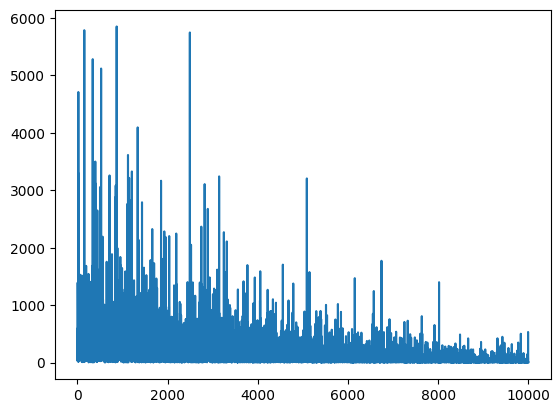

In [30]:
plt.plot([x['overall_loss'] for x in train_history])

In [31]:
with torch.no_grad():
    batch = next(iter(train_dl))
    x, b, masks, voxel_idxs, exp = batch['he_tiles']['2X'], batch['b'], batch['masks'], batch['voxel_idxs'], batch['X']
    if use_cuda:
        x, b, masks, voxel_idxs, exp = x.cuda(), b.cuda(), masks.cuda(), voxel_idxs.cuda(), exp.cuda()
    result = model.forward_with_expression(x, b, masks)
    

In [34]:
result['p'][:5]

tensor([[[0.4624, 0.5650, 0.4056, 0.3358]],

        [[0.4624, 0.5650, 0.4056, 0.3358]],

        [[0.4624, 0.5650, 0.4056, 0.3358]],

        [[0.4624, 0.5650, 0.4056, 0.3358]],

        [[0.4624, 0.5650, 0.4056, 0.3358]]], device='cuda:0')

In [35]:
result['r'][:5]

tensor([[[1.0000e-06, 1.0000e-06, 5.6808e+01, 4.4744e+01],
         [1.0009e-06, 1.0000e-06, 2.3589e+01, 3.1893e+01],
         [8.4996e-03, 1.0000e-06, 1.5250e+01, 2.8547e+01],
         [1.0000e-06, 1.0000e-06, 8.5162e+01, 9.1345e+01],
         [1.0004e-06, 1.0000e-06, 4.2693e+01, 7.1328e+01],
         [1.0000e-06, 1.0000e-06, 5.9362e+01, 4.5460e+01],
         [9.9496e-05, 1.0000e-06, 3.0337e+01, 5.2996e+01],
         [1.8098e-04, 1.0000e-06, 3.8840e+01, 6.8344e+01],
         [6.9315e-01, 6.9315e-01, 6.9315e-01, 6.9315e-01],
         [6.9315e-01, 6.9315e-01, 6.9315e-01, 6.9315e-01],
         [6.9315e-01, 6.9315e-01, 6.9315e-01, 6.9315e-01],
         [6.9315e-01, 6.9315e-01, 6.9315e-01, 6.9315e-01],
         [6.9315e-01, 6.9315e-01, 6.9315e-01, 6.9315e-01],
         [6.9315e-01, 6.9315e-01, 6.9315e-01, 6.9315e-01],
         [6.9315e-01, 6.9315e-01, 6.9315e-01, 6.9315e-01],
         [6.9315e-01, 6.9315e-01, 6.9315e-01, 6.9315e-01]],

        [[1.0000e-06, 1.0000e-06, 5.5803e+01, 4.3623e+

In [36]:
result['metagene_matrix'].shape

torch.Size([16, 16, 20])

In [26]:
result.keys()

dict_keys(['L', 'L_mu', 'L_std', 'E', 'E_mu', 'E_std', 'F', 'F_mu', 'F_std', 'metagene_matrix', 'r', 'p', 'z', 'z_mu', 'z_std', 'expression'])

In [27]:
batch['voxel_idxs'][0]

tensor([  50,  410, 2203, 3299,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0])

In [37]:
def reformat_results(adata, result, batch):
    voxel_idxs = torch.unique(batch['voxel_idxs']).detach().cpu().numpy() - 1
    voxel_idxs = [i for i in voxel_idxs if i != -1]
    recon_exp = np.zeros((len(voxel_idxs), adata.shape[1]))
    voxel_idx_to_row = {x:i for i, x in enumerate(voxel_idxs)}
    
    for i in range(batch['voxel_idxs'].shape[0]):
        for j in range(batch['n_voxels'][i]):
            vox_idx = (batch['voxel_idxs'][i, j] - 1).item()
            recon_exp[voxel_idx_to_row[vox_idx]] = result['expression'][i, j].detach().cpu().numpy()
    
    recon_adata = adata[voxel_idxs].copy()
    recon_adata.X = recon_exp
    return recon_adata
            

In [38]:
recon_adata = reformat_results(train_adata, result, batch)

In [39]:
recon_adata.var

gene_ids    feature_types  genome  highly_variable     means  \
EPCAM  ENSG00000119888  Gene Expression  GRCh38            False  0.839758   
IL7R   ENSG00000168685  Gene Expression  GRCh38            False  0.130898   
CD8A   ENSG00000153563  Gene Expression  GRCh38            False  0.011554   
BGN    ENSG00000182492  Gene Expression  GRCh38             True  1.036667   

       dispersions  dispersions_norm  
EPCAM     0.329964         -0.730939  
IL7R      0.793018          0.842909  
CD8A      0.652828          0.608221  
BGN       1.244118          2.419022

In [31]:
recon_adata.X[0, :]

array([2.59240255e-06, 5.00493252e-06, 1.08408813e-05, ...,
       1.98666839e-06, 4.13101134e-07, 1.54791326e-06])

In [32]:
recon_adata.X[:, 0]

array([2.59240255e-06, 2.59240255e-06, 2.59240255e-06, 2.59240392e-06,
       2.59240255e-06, 2.59240255e-06, 2.59240255e-06, 2.59240255e-06,
       2.59240255e-06, 2.59240255e-06, 2.59240255e-06, 2.59240255e-06,
       2.66493225e-06, 2.59240255e-06, 2.59240255e-06, 2.59240255e-06,
       2.59240255e-06, 2.59240255e-06, 2.59240255e-06, 2.59240255e-06,
       2.59240255e-06, 2.59240255e-06, 2.59240255e-06, 2.59240255e-06,
       2.59240255e-06, 2.59240255e-06, 2.59240255e-06, 2.59240255e-06,
       2.59240255e-06, 2.59240255e-06, 2.59240255e-06, 2.59240255e-06,
       2.59240255e-06, 2.59240255e-06, 2.59240255e-06, 2.59240255e-06,
       2.59240255e-06, 2.59240255e-06, 2.59240255e-06, 2.59240255e-06,
       2.59240255e-06, 2.59240255e-06, 2.59240255e-06, 2.59240255e-06,
       2.59240255e-06, 2.59240255e-06, 2.59240255e-06, 2.59240278e-06,
       9.66643821e-03, 2.59240255e-06, 2.59240255e-06, 2.59240255e-06,
       2.59240255e-06, 2.59240255e-06, 2.59240255e-06, 2.59240255e-06,
      

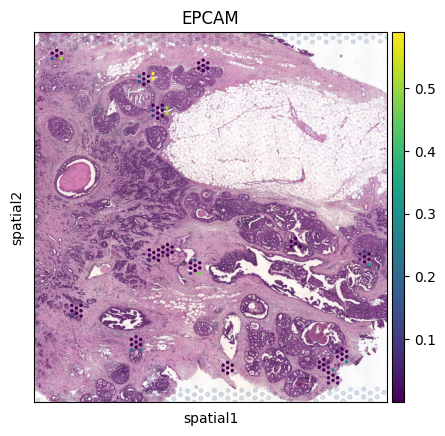

In [50]:
sc.pl.spatial(recon_adata, color='EPCAM')

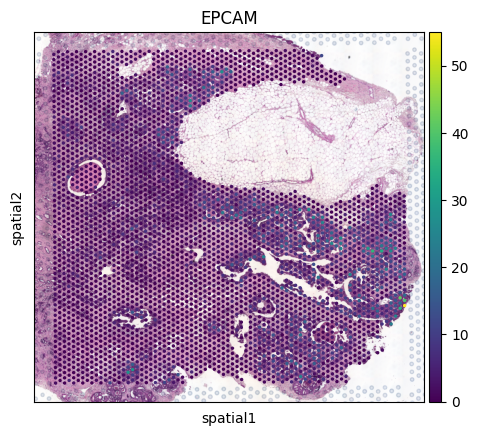

In [49]:
sc.pl.spatial(train_adata, color='EPCAM')

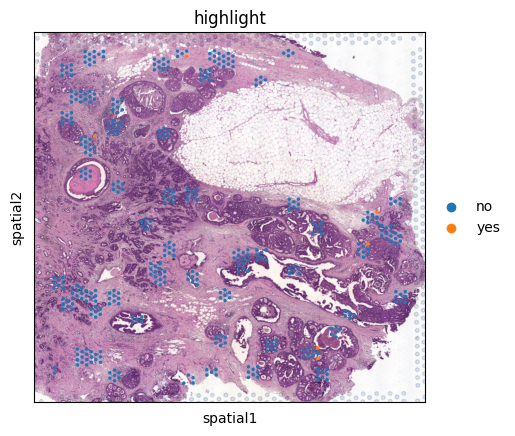

In [34]:
recon_adata.obs['highlight'] = ['yes' if x > .00001 else 'no' for x in recon_adata[:, 'BGN'].X.flatten()]
sc.pl.spatial(recon_adata, color='highlight')

In [53]:
def generate_reconstructed_adata(result, batch, idx=0):
    orig = train_adata[torch.unique(batch['voxel_idxs'][idx]).detach().numpy() - 1]
    recon = orig.copy()
    recon.X = result['expression'][idx, :batch['n_voxels'][idx]].detach().numpy()
    recon.obsm['metagenes'] = result['metagene_matrix'][idx, :batch['n_voxels'][idx]].detach().numpy()
    return recon
    

In [ ]:
recon = pl

In [47]:
f = train_adata[torch.unique(batch['voxel_idxs'][0]).detach().numpy() - 1].copy(
f

View of AnnData object with n_obs × n_vars = 7 × 2000
    obs: 'in_tissue', 'array_row', 'array_col', 'clusters', 'alla_label', 'spot_index'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'alla_label_colors', 'full_res_he', 'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'rescaled_he', 'rescaled_spot_masks', 'rescaled_spot_metadata', 'spatial', 'trimmed', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_16X_notrim', 'spatial_16X_trimmed', 'spatial_1X_notrim', 'spatial_1X_trimmed', 'spatial_2X_notrim', 'spatial_2X_trimmed', 'spatial_4X_notrim', 'spatial_4X_trimmed', 'spatial_8X_notrim', 'spatial_8X_trimmed', 'spatial_trimmed'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

/home/estorrs/.local/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


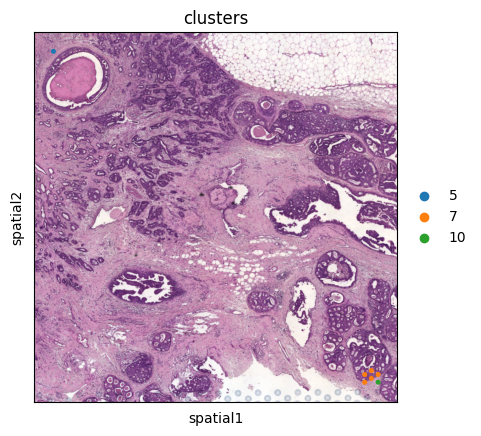

In [48]:
sc.pl.spatial(f, color='clusters')

In [49]:
result['expression'].shape

torch.Size([64, 16, 2000])

In [51]:
batch['n_voxels']

tensor([ 6,  9,  8,  9,  7,  7,  7,  6,  7,  7, 10,  8,  7,  8, 10,  7, 10,  8,
         8, 10,  7,  8,  9,  8,  9,  6,  7,  7,  9,  7,  8,  8,  9,  7,  7,  7,
         9,  9,  7,  9,  8,  8,  8,  5,  8,  7,  8,  6,  8,  8,  8,  8,  8,  8,
         7,  7,  8,  7,  8,  7,  8,  7,  8,  7])

In [ ]:
{'overall_loss': tensor(inf, grad_fn=<AddBackward0>),
 'reconstruction_loss': tensor(inf, grad_fn=<MeanBackward0>),
 'kl_loss': tensor(1566.5610, grad_fn=<AddBackward0>),
 'latent_loss': tensor(64.1603, grad_fn=<MeanBackward0>),
 'L_loss': tensor(504.8519, grad_fn=<MeanBackward0>),
 'E_loss': tensor(531.3380, grad_fn=<MeanBackward0>),
 'F_loss': tensor(466.2109, grad_fn=<MeanBackward0>)}

In [ ]:
def fit_model(model, opt, scheduler, train_dl, val_dl, epochs=20):
    use_cuda = next(model.parameters()).is_cuda
    history = []
    for epoch in range(epochs):
        train_loss, val_loss = 0., 0.
        val_recon_loss, val_kl_loss, val_clf_loss = 0., 0., 0.
        start = time.time()
        model.train()
        for i, b in enumerate(train_dl):
            x, x_raw, sf, y = b['x'], b['x_raw'], b['size_factor'], b['y']
            if use_cuda:
                x, x_raw, sf, y = x.cuda(), x_raw.cuda(), sf.cuda(), y.cuda()
            opt.zero_grad()
            out = model(x)
            loss, recon_loss, kl_loss, clf_loss = model.calculate_loss(out, x_raw, sf, y)
            loss.backward()
            opt.step()

            train_loss += float(loss.detach().cpu())
            scheduler.step()
        train_loss = train_loss / len(train_dl)

        time_delta = time.time() - start
        model.eval()
        with torch.no_grad():
            for i, b in enumerate(val_dl):
                x, x_raw, sf, y = b['x'], b['x_raw'], b['size_factor'], b['y']
                if use_cuda:
                    x, x_raw, sf, y = x.cuda(), x_raw.cuda(), sf.cuda(), y.cuda()

                out = model(x)
                loss, recon_loss, kl_loss, clf_loss = model.calculate_loss(out, x_raw, sf, y)
                val_loss += float(loss.detach().cpu())
                val_recon_loss += float(recon_loss.detach().cpu())
                val_kl_loss += float(kl_loss.detach().cpu())
                val_clf_loss += float(clf_loss.detach().cpu())

        val_loss, val_recon_loss, val_kl_loss, val_clf_loss = [
            l / len(val_dl) for l in [val_loss, val_recon_loss, val_kl_loss, val_clf_loss]]

        history.append({
            'epoch': epoch,
            'train loss': train_loss,
            'val loss': val_loss,
            'val reconstruction loss': val_recon_loss,
            'val_kl_loss': val_kl_loss,
            'val classification loss': val_clf_loss,
            'time': time_delta
        })
        logging.info(f'epoch: {epoch}, train loss: {train_loss:.3f}, val loss: {val_loss:.3f}, \
zinb loss: {val_recon_loss:.3f}, kl loss: {val_kl_loss:.3f}, \
clf loss: {val_clf_loss:.3f}, time: {time_delta:.2f}')

    return history

In [ ]:
{'overall_loss': tensor(inf, grad_fn=<AddBackward0>),
 'reconstruction_loss': tensor(inf, grad_fn=<MeanBackward0>),
 'kl_loss': tensor(1566.5610, grad_fn=<AddBackward0>),
 'latent_loss': tensor(64.1603, grad_fn=<MeanBackward0>),
 'L_loss': tensor(504.8519, grad_fn=<MeanBackward0>),
 'E_loss': tensor(531.3380, grad_fn=<MeanBackward0>),
 'F_loss': tensor(466.2109, grad_fn=<MeanBackward0>)}